# Tile Coding
---

Tile coding is an innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tilings_; then for any given sample value, you need only check which tiles it lies in. You can then encode the original continuous value by a vector of integer indices or bits that identifies each activated tile.

### 1. Import the Necessary Packages

In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's begin with an environment that has a continuous state space, but a discrete action space.

In [2]:
# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space: Box(6,)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [ 1.     1.     1.     1.    12.566 28.274]
Action space: Discrete(3)


Note that the state space is multi-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final two dimensions have a larger range. How do we discretize such a space using tiles?

### 3. Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, `bins = (10, 10)`, and `offsets = (-0.1, 0.5)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [3]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    grid = [(np.linspace(low[i], high[i], bins[i],False) + offsets[i])[1:] for i in range(len(bins))]
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

You can now use this function to define a set of tilings that are a little offset from each other.

In [4]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    # TODO: Implement this
    tilings = [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]
    
    return tilings


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

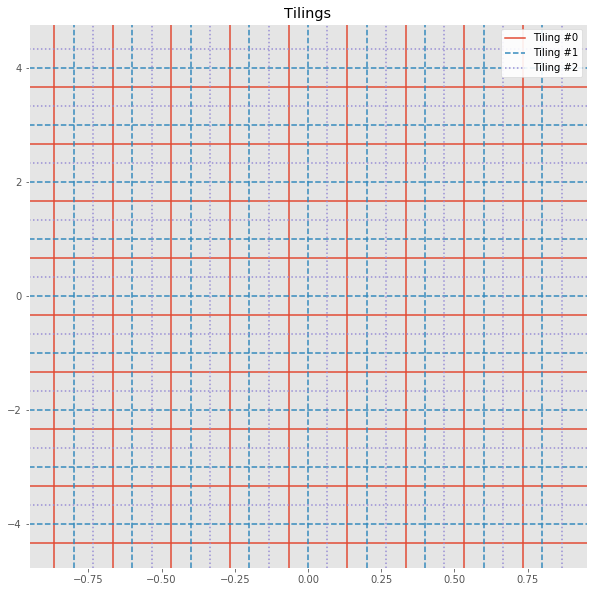

In [5]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


visualize_tilings(tilings);

Great! Now that we have a way to generate these tilings, we can next write our encoding function that will convert any given continuous state value to a discrete vector.

### 4. Tile Encoding

Implement the following to produce a vector that contains the indices for each tile that the input state value belongs to. The shape of the vector can be the same as the arrangment of tiles you have, or it can be ultimately flattened for convenience.

You can use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.

In [6]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    return tuple(int(np.digitize(s,g)) for s, g in zip(sample, grid))


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    # TODO: Implement this
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample


# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]


Note that we did not flatten the encoding above, which is why each sample's representation is a pair of indices for each tiling. This makes it easy to visualize it using the tilings.

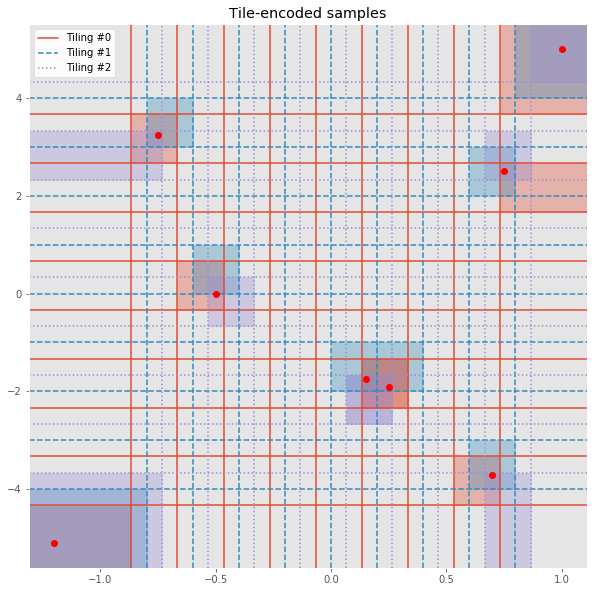

In [7]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing

    # Show tiling grids
    ax = visualize_tilings(tilings)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # Shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # So plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
    
    # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')

    ax.margins(x=0, y=0)  # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    return ax

visualize_encoded_samples(samples, encoded_samples, tilings);

Inspect the results and make sure you understand how the corresponding tiles are being chosen. Note that some samples may have one or more tiles in common.

### 5. Q-Table with Tile Coding

The next step is to design a special Q-table that is able to utilize this tile coding scheme. It should have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it should return a `<value>`. Similarly, it should also allow you to update the `<value>` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to).

The `<state>` supplied here is assumed to be from the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation when required.

In [8]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # TODO: Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(np.hstack([np.array(self.state_size), np.array(self.action_size)]))

        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings, flatten=False)
        
        # TODO: Retrieve q-value for each tiling, and return their average
        val = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            val += q_table.q_table[tuple(idx + (action,))]
        val /= len(encoded_state)
        return val

    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings, flatten=False)
        
        # TODO: Update q-value for each tiling by update factor alpha
        for idx, q_table in zip(encoded_state, self.q_tables):
            val_to_update = q_table.q_table[(idx + (action,))]
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * val_to_update


# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = 0.06666666666666667


If you update the q-value for a particular state (say, `(0.25, -1.91)`) and action (say, `0`), then you should notice the q-value of a nearby state (e.g. `(0.15, -1.75)` and same action) has changed as well! This is how tile-coding is able to generalize values across the state space better than a single uniform grid.

### 6. Implement a Q-Learning Agent using Tile-Coding

Now it's your turn to apply this discretization technique to design and test a complete learning agent! 

In [9]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tiling_specs, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        #self.tiling_specs = tiling_specs
        #self.state_tillings = create_tilings(env.low, env.high, tiling_specs)
        #self.state_sizes = list(tuple(len(splits) + 1 for splits in tilling for tilling in self.state_tillings))  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        #print("Environment:", self.env)
        #print("State space size:", self.state_size)
        #print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        # Create Q-tables
        self.TiledQTable = TiledQTable(env.observation_space.low, env.observation_space.high, tiling_specs, self.action_size)
        
    ##########################################
    def getActionProbArray_of_Q_table_with_Index(self, encoded_state):
        array = [table.q_table[idx] for idx, table in zip(encoded_state, self.TiledQTable.q_tables)]            
        return array
    ##########################################

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        return tuple(tile_encode(state, self.TiledQTable.tilings))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = state
        tile_encoded_last_state = self.preprocess_state(state)
        #tile_encoded_last_state = self.preprocess_state(state)
        action_prob_array = self.getActionProbArray_of_Q_table_with_Index(tile_encoded_last_state)
        action_prob_mean_array = sum(action_prob_array) / len(tile_encoded_last_state)
        action = np.argmax(np.array(action_prob_mean_array))
        self.last_action = action
        #self.last_action = np.argmax(self.TiledQTable.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        tile_encoded_state = self.preprocess_state(state)
        action_prob_array = self.getActionProbArray_of_Q_table_with_Index(tile_encoded_state)
        action_prob_mean_array = sum(action_prob_array) / len(tile_encoded_state)
        
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(np.array(action_prob_mean_array))
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward         
            # ArHe --> Here I stopped
            current_state_action_value = self.TiledQTable.get(self.last_state, self.last_action)
            new_value = current_state_action_value + self.alpha * \
                (reward + self.gamma * np.max(np.array(action_prob_mean_array)) - current_state_action_value)
            self.TiledQTable.update(self.last_state, self.last_action, new_value)

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(np.array(action_prob_mean_array))

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action
tiling_specs_acrobot = [((100, 100, 100, 100, 10, 10), (-0.03, -0.03, -0.03, -0.03, -0.2, -0.2)),
                ((22, 22), (-0.02, -0.2)),
                ((22, 22), (0.0, 0.0)),
                ((22, 22), (0.02, 0.2)),
                ((22, 22), (0.04, 0.4))]

q_agent = QLearningAgent(env, tiling_specs_acrobot)

QTable(): size = (10, 10, 3)
QTable(): size = (22, 22, 3)
QTable(): size = (22, 22, 3)
QTable(): size = (22, 22, 3)
QTable(): size = (22, 22, 3)
TiledQTable(): no. of internal tables =  5


In [18]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            #print("action: ", action)
            #print("state:  ", state)
            #print("reward: ", reward)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)


action:  0
state:   [ 0.998  0.067  0.999 -0.05   0.083 -0.215]
reward:  -1.0
action:  2
state:   [ 0.998  0.06   0.999 -0.046 -0.148  0.259]
reward:  -1.0
action:  2
state:   [ 1.     0.011  0.999  0.048 -0.334  0.652]
reward:  -1.0
action:  0
state:   [ 0.999 -0.04   0.991  0.133 -0.157  0.182]
reward:  -1.0
action:  1
state:   [ 0.998 -0.062  0.989  0.149 -0.065 -0.02 ]
reward:  -1.0
action:  0
state:   [ 0.999 -0.051  0.996  0.09   0.171 -0.563]
reward:  -1.0
action:  0
state:   [ 1.     0.002  0.998 -0.065  0.345 -0.961]
reward:  -1.0
action:  0
state:   [ 0.997  0.078  0.962 -0.272  0.396 -1.089]
reward:  -1.0
action:  0
state:   [ 0.989  0.151  0.887 -0.463  0.31  -0.922]
reward:  -1.0
action:  2
state:   [ 0.985  0.17   0.845 -0.535 -0.113  0.091]
reward:  -1.0
action:  2
state:   [ 0.994  0.108  0.902 -0.432 -0.507  1.073]
reward:  -1.0
action:  0
state:   [ 1.     0.003  0.976 -0.218 -0.509  1.138]
reward:  -1.0
action:  0
state:   [ 0.996 -0.084  1.    -0.014 -0.343  0.87 ]


action:  1
state:   [ 0.998  0.064  0.993 -0.118  1.473 -3.388]
reward:  -1.0
action:  0
state:   [ 0.943  0.332  0.721 -0.693  1.196 -2.926]
reward:  -1.0
action:  2
state:   [ 0.878  0.479  0.369 -0.929  0.401 -1.334]
reward:  -1.0
action:  0
state:   [ 0.869  0.496  0.216 -0.976 -0.208 -0.268]
reward:  -1.0
action:  0
state:   [ 0.913  0.408  0.266 -0.964 -0.749  0.778]
reward:  -1.0
action:  0
state:   [ 0.974  0.227  0.499 -0.867 -1.135  1.722]
reward:  -1.0
action:  2
state:   [ 0.999 -0.041  0.842 -0.54  -1.521  2.994]
reward:  -1.0
action:  1
state:   [ 0.943 -0.332  0.998  0.063 -1.368  3.165]
reward:  -1.0
action:  2
state:   [ 0.845 -0.535  0.792  0.61  -0.825  2.624]
reward:  -1.0
action:  1
state:   [ 0.802 -0.598  0.498  0.867  0.077  1.282]
reward:  -1.0
action:  2
state:   [ 0.854 -0.521  0.369  0.929  0.824  0.153]
reward:  -1.0
action:  1
state:   [ 0.951 -0.31   0.466  0.885  1.463 -1.205]
reward:  -1.0
action:  2
state:   [ 1.     0.004  0.726  0.688  1.658 -1.994]


reward:  -1.0
action:  2
state:   [ 0.996  0.093  0.787 -0.617  1.6   -0.774]
reward:  -1.0
action:  0
state:   [ 0.926  0.377  0.731 -0.682  1.272 -0.036]
reward:  -1.0
action:  0
state:   [ 0.836  0.549  0.784 -0.62   0.642  0.853]
reward:  -1.0
action:  0
state:   [ 0.804  0.594  0.914 -0.405 -0.092  1.631]
reward:  -1.0
action:  2
state:   [ 0.865  0.501  1.     0.029 -0.984  2.74 ]
reward:  -1.0
action:  0
state:   [ 0.957  0.29   0.848  0.53  -1.27   2.431]
reward:  -1.0
action:  2
state:   [ 1.     0.015  0.523  0.852 -1.456  2.083]
reward:  -1.0
action:  0
state:   [ 0.97  -0.244  0.263  0.965 -1.121  0.728]
reward:  -1.0
action:  2
state:   [ 0.907 -0.421  0.217  0.976 -0.713 -0.284]
reward:  -1.0
action:  0
state:   [ 0.879 -0.477  0.426  0.905  0.119 -1.943]
reward:  -1.0
action:  1
state:   [ 0.924 -0.381  0.823  0.567  0.919 -3.284]
reward:  -1.0
action:  2
state:   [ 0.986 -0.164  0.995 -0.102  1.249 -3.577]
reward:  -1.0
action:  2
state:   [ 0.998  0.068  0.736 -0.677  

state:   [ 0.994 -0.106  0.997  0.072  0.747 -3.214]
reward:  -1.0
action:  1
state:   [ 0.999  0.043  0.85  -0.526  0.677 -2.896]
reward:  -1.0
action:  0
state:   [ 0.988  0.156  0.478 -0.878  0.436 -2.22 ]
reward:  -1.0
action:  1
state:   [ 0.979  0.204  0.166 -0.986  0.057 -1.103]
reward:  -1.0
action:  2
state:   [ 0.984  0.176  0.078 -0.997 -0.327  0.208]
reward:  -1.0
action:  0
state:   [ 0.995  0.099  0.192 -0.981 -0.439  0.934]
reward:  -1.0
action:  0
state:   [ 1.     0.005  0.432 -0.902 -0.487  1.576]
reward:  -1.0
action:  2
state:   [ 0.993 -0.115  0.767 -0.641 -0.708  2.681]
reward:  -1.0
action:  1
state:   [ 0.968 -0.252  0.994 -0.113 -0.633  3.028]
reward:  -1.0
action:  2
state:   [ 0.938 -0.346  0.884  0.467 -0.298  2.814]
reward:  -1.0
action:  2
state:   [ 0.938 -0.348  0.569  0.823  0.295  1.922]
reward:  -1.0
action:  1
state:   [ 0.973 -0.23   0.345  0.939  0.894  0.622]
reward:  -1.0
action:  2
state:   [ 1.    -0.029  0.311  0.951  1.085 -0.216]
reward:  -1

action:  2
state:   [ 1.     0.016  0.934 -0.358  0.829  0.036]
reward:  -1.0
action:  2
state:   [ 0.988  0.151  0.962 -0.275  0.504  0.848]
reward:  -1.0
action:  0
state:   [ 0.972  0.235  0.995 -0.1    0.344  0.908]
reward:  -1.0
action:  2
state:   [ 0.966  0.258  0.99   0.143 -0.105  1.488]
reward:  -1.0
action:  2
state:   [ 0.98   0.201  0.891  0.454 -0.454  1.725]
reward:  -1.0
action:  2
state:   [ 0.996  0.09   0.692  0.722 -0.643  1.564]
reward:  -1.0
action:  1
state:   [ 0.999 -0.034  0.5    0.866 -0.576  0.812]
reward:  -1.0
action:  1
state:   [ 0.991 -0.132  0.435  0.901 -0.39  -0.091]
reward:  -1.0
action:  1
state:   [ 0.984 -0.18   0.537  0.844 -0.079 -1.086]
reward:  -1.0
action:  2
state:   [ 0.986 -0.169  0.754  0.657  0.188 -1.761]
reward:  -1.0
action:  1
state:   [ 0.995 -0.097  0.96   0.281  0.513 -2.488]
reward:  -1.0
action:  1
state:   [ 1.     0.017  0.973 -0.231  0.575 -2.563]
reward:  -1.0
action:  2
state:   [ 0.995  0.1    0.791 -0.612  0.231 -1.63 ]


reward:  -1.0
action:  2
state:   [ 0.87  -0.492  0.64  -0.768 -0.48  -2.875]
reward:  -1.0
action:  0
state:   [ 0.837 -0.547  0.144 -0.99  -0.133 -2.662]
reward:  -1.0
action:  2
state:   [ 0.842 -0.54  -0.336 -0.942  0.259 -2.273]
reward:  -1.0
action:  0
state:   [ 0.899 -0.437 -0.735 -0.678  0.917 -2.572]
reward:  -1.0
action:  0
state:   [ 0.977 -0.212 -0.981 -0.196  1.425 -2.91 ]
reward:  -1.0
action:  1
state:   [ 0.996  0.085 -0.92   0.392  1.495 -3.098]
reward:  -1.0
action:  2
state:   [ 0.938  0.346 -0.518  0.855  1.145 -3.145]
reward:  -1.0
action:  0
state:   [ 0.851  0.526  0.14   0.99   0.874 -3.744]
reward:  -1.0
action:  2
state:   [ 0.773  0.635  0.787  0.617  0.448 -3.872]
reward:  -1.0
action:  2
state:   [ 0.758  0.652  0.997 -0.072 -0.3   -3.328]
reward:  -1.0
action:  2
state:   [ 0.858  0.513  0.827 -0.562 -1.434 -1.801]
reward:  -1.0
action:  1
state:   [ 0.987  0.161  0.696 -0.718 -2.262 -0.257]
reward:  -1.0
action:  0
state:   [ 0.952 -0.306  0.728 -0.686 -

action:  0
state:   [ 0.998  0.067  0.965 -0.262 -0.093 -0.388]
reward:  -1.0
action:  0
state:   [ 0.999  0.049  0.942 -0.335 -0.089 -0.363]
reward:  -1.0
action:  0
state:   [ 0.999  0.032  0.918 -0.396 -0.075 -0.284]
reward:  -1.0
action:  0
state:   [ 1.     0.02   0.899 -0.437 -0.049 -0.169]
reward:  -1.0
action:  0
state:   [ 1.     0.013  0.89  -0.456 -0.015 -0.035]
reward:  -1.0
action:  0
state:   [ 1.     0.014  0.893 -0.45   0.022  0.102]
reward:  -1.0
action:  0
state:   [ 1.     0.022  0.908 -0.42   0.056  0.226]
reward:  -1.0
action:  1
state:   [ 1.     0.023  0.941 -0.338 -0.045  0.649]
reward:  -1.0
action:  1
state:   [ 1.     0.006  0.983 -0.181 -0.119  0.948]
reward:  -1.0
action:  2
state:   [ 0.999 -0.034  0.999  0.054 -0.257  1.365]
reward:  -1.0
action:  2
state:   [ 0.996 -0.088  0.943  0.334 -0.268  1.433]
reward:  -1.0
action:  2
state:   [ 0.991 -0.132  0.823  0.568 -0.155  1.16 ]
reward:  -1.0
action:  1
state:   [ 0.991 -0.134  0.725  0.688  0.127  0.378]


action:  0
state:   [ 0.271 -0.962 -0.293  0.956  2.448 -2.673]
reward:  -1.0
action:  1
state:   [ 0.771 -0.636  0.439  0.899  3.585 -4.932]
reward:  -1.0
action:  0
state:   [ 0.993  0.121  0.994 -0.107  4.317 -6.823]
reward:  -1.0
action:  0
state:   [ 0.607  0.795  0.244 -0.97   3.494 -4.992]
reward:  -1.0
action:  1
state:   [ 0.076  0.997 -0.497 -0.868  2.262 -2.806]
reward:  -1.0
action:  0
state:   [-0.255  0.967 -0.807 -0.59   1.074 -1.456]
reward:  -1.0
action:  0
state:   [-0.349  0.937 -0.899 -0.439 -0.082 -0.327]
reward:  -1.0
action:  2
state:   [-0.211  0.977 -0.856 -0.517 -1.36   1.24 ]
reward:  -1.0
action:  1
state:   [ 0.182  0.983 -0.583 -0.813 -2.59   2.894]
reward:  -1.0
action:  1
state:   [ 0.728  0.686  0.173 -0.985 -3.71   5.193]
reward:  -1.0
action:  0
state:   [ 0.998 -0.068  0.991 -0.135 -4.349  7.027]
reward:  -1.0
action:  1
state:   [ 0.643 -0.766  0.415  0.91  -3.493  5.284]
reward:  -1.0
action:  0
state:   [ 0.134 -0.991 -0.362  0.932 -2.141  2.843]


action:  0
state:   [ 0.647  0.763  0.495 -0.869  2.345 -3.359]
reward:  -1.0
action:  1
state:   [ 0.344  0.939  0.025 -1.     1.155 -1.61 ]
reward:  -1.0
action:  1
state:   [ 0.243  0.97  -0.142 -0.99  -0.101 -0.086]
reward:  -1.0
action:  2
state:   [ 0.389  0.921  0.016 -1.    -1.429  1.711]
reward:  -1.0
action:  1
state:   [ 0.718  0.696  0.511 -0.86  -2.569  3.529]
reward:  -1.0
action:  1
state:   [ 0.986  0.166  0.988 -0.156 -3.33   5.018]
reward:  -1.0
action:  2
state:   [ 0.88  -0.475  0.674  0.738 -3.105  4.461]
reward:  -1.0
action:  2
state:   [ 0.515 -0.857  0.02   1.    -2.188  2.731]
reward:  -1.0
action:  0
state:   [ 0.228 -0.974 -0.319  0.948 -0.905  0.773]
reward:  -1.0
action:  0
state:   [ 0.182 -0.983 -0.3    0.954  0.444 -0.965]
reward:  -1.0
action:  0
state:   [ 0.397 -0.918  0.07   0.998  1.799 -2.832]
reward:  -1.0
action:  1
state:   [ 0.777 -0.629  0.738  0.675  2.991 -4.782]
reward:  -1.0
action:  2
state:   [ 1.    -0.023  0.954 -0.299  3.393 -5.235]


action:  0
state:   [ 0.291 -0.957 -0.965  0.264  2.7   -1.377]
reward:  -1.0
action:  0
state:   [ 0.809 -0.587 -0.743  0.67   3.673 -3.33 ]
reward:  -1.0
action:  2
state:   [ 9.918e-01  1.279e-01 -1.459e-03  1.000e+00  3.777e+00 -5.010e+00]
reward:  -1.0
action:  0
state:   [ 0.642  0.767  0.926  0.377  3.596 -6.605]
reward:  -1.0
action:  0
state:   [ 0.079  0.997  0.641 -0.768  2.411 -5.64 ]
reward:  -1.0
action:  1
state:   [-0.229  0.973 -0.241 -0.971  0.692 -3.829]
reward:  -1.0
action:  2
state:   [-0.195  0.981 -0.739 -0.673 -1.014 -2.057]
reward:  -1.0
action:  0
state:   [ 0.15   0.989 -0.888 -0.459 -2.424 -0.519]
reward:  -1.0
action:  1
state:   [ 0.69   0.724 -0.847 -0.532 -3.593  1.366]
reward:  -1.0
action:  0
state:   [ 0.999  0.042 -0.542 -0.84  -3.921  2.955]
reward:  -1.0
action:  0
state:   [ 0.768 -0.64   0.131 -0.991 -3.335  3.94 ]
reward:  -1.0
action:  2
state:   [ 0.281 -0.96   0.834 -0.552 -2.537  4.432]
reward:  -1.0
action:  0
state:   [-0.094 -0.996  0.98

state:   [0.971 0.239 0.966 0.26  0.835 0.215]
reward:  -1.0
action:  0
state:   [ 0.924  0.382  0.964  0.267  0.635 -0.116]
reward:  -1.0
action:  0
state:   [ 0.885  0.466  0.974  0.226  0.277 -0.286]
reward:  -1.0
action:  2
state:   [ 0.891  0.454  0.974  0.229 -0.408  0.315]
reward:  -1.0
action:  2
state:   [ 0.946  0.323  0.942  0.337 -0.989  0.768]
reward:  -1.0
action:  0
state:   [ 0.993  0.119  0.902  0.432 -1.057  0.205]
reward:  -1.0
action:  0
state:   [ 0.997 -0.075  0.918  0.396 -0.842 -0.626]
reward:  -1.0
action:  0
state:   [ 0.979 -0.202  0.982  0.191 -0.427 -1.5  ]
reward:  -1.0
action:  2
state:   [ 0.963 -0.268  0.994 -0.106 -0.252 -1.432]
reward:  -1.0
action:  2
state:   [ 0.954 -0.301  0.935 -0.354 -0.094 -1.096]
reward:  -1.0
action:  1
state:   [ 0.957 -0.291  0.843 -0.538  0.192 -0.937]
reward:  -1.0
action:  1
state:   [ 0.973 -0.23   0.747 -0.665  0.434 -0.627]
reward:  -1.0
action:  2
state:   [ 0.99  -0.14   0.713 -0.701  0.456  0.155]
reward:  -1.0
act

state:   [ 0.669  0.744  0.87   0.492  0.869 -1.543]
reward:  -1.0
action:  2
state:   [ 0.615  0.788  0.959  0.283 -0.182 -0.699]
reward:  -1.0
action:  0
state:   [ 0.701  0.713  0.986  0.168 -0.952 -0.489]
reward:  -1.0
action:  1
state:   [ 0.865  0.502  0.993  0.118 -1.682 -0.054]
reward:  -1.0
action:  1
state:   [ 0.989  0.145  0.992  0.126 -2.045  0.072]
reward:  -1.0
action:  0
state:   [ 0.97  -0.243  0.996  0.085 -1.786 -0.535]
reward:  -1.0
action:  2
state:   [ 0.842 -0.54   1.    -0.029 -1.41  -0.616]
reward:  -1.0
action:  1
state:   [ 0.711 -0.703  0.98  -0.199 -0.658 -1.103]
reward:  -1.0
action:  2
state:   [ 0.667 -0.745  0.908 -0.42   0.055 -1.214]
reward:  -1.0
action:  1
state:   [ 0.735 -0.678  0.757 -0.654  0.884 -1.542]
reward:  -1.0
action:  2
state:   [ 0.873 -0.487  0.544 -0.839  1.439 -1.214]
reward:  -1.0
action:  2
state:   [ 0.982 -0.19   0.397 -0.918  1.665 -0.367]
reward:  -1.0
action:  0
state:   [ 0.99   0.143  0.4   -0.916  1.597  0.487]
reward:  -1

action:  0
state:   [ 0.833 -0.553  0.992  0.128  0.278  0.658]
reward:  -1.0
action:  0
state:   [ 0.901 -0.433  0.987  0.159  1.075 -0.337]
reward:  -1.0
action:  2
state:   [ 0.98  -0.197  0.997  0.077  1.368 -0.438]
reward:  -1.0
action:  2
state:   [ 0.997  0.076  1.     0.008  1.317 -0.195]
reward:  -1.0
action:  2
state:   [0.954 0.301 1.    0.019 0.939 0.337]
reward:  -1.0
action:  0
state:   [0.894 0.447 0.997 0.081 0.615 0.294]
reward:  -1.0
action:  0
state:   [0.856 0.517 0.99  0.14  0.165 0.306]
reward:  -1.0
action:  0
state:   [ 0.864  0.503  0.98   0.201 -0.315  0.301]
reward:  -1.0
action:  0
state:   [ 0.912  0.41   0.968  0.251 -0.717  0.182]
reward:  -1.0
action:  0
state:   [ 0.968  0.25   0.966  0.259 -0.943 -0.125]
reward:  -1.0
action:  2
state:   [ 0.999  0.034  0.967  0.256 -1.193  0.05 ]
reward:  -1.0
action:  0
state:   [ 0.984 -0.177  0.98   0.197 -0.893 -0.677]
reward:  -1.0
action:  2
state:   [ 0.944 -0.33   0.998  0.056 -0.669 -0.733]
reward:  -1.0
acti

action:  1
state:   [ 0.941  0.338  0.735 -0.678  0.615 -0.75 ]
reward:  -1.0
action:  0
state:   [ 0.911  0.412  0.681 -0.733  0.16  -0.011]
reward:  -1.0
action:  1
state:   [ 0.923  0.385  0.754 -0.657 -0.448  1.054]
reward:  -1.0
action:  0
state:   [ 0.965  0.261  0.903 -0.43  -0.835  1.623]
reward:  -1.0
action:  1
state:   [ 0.998  0.064  0.998 -0.063 -1.103  2.086]
reward:  -1.0
action:  2
state:   [ 0.986 -0.165  0.93   0.368 -1.136  2.193]
reward:  -1.0
action:  2
state:   [ 0.934 -0.357  0.719  0.695 -0.812  1.642]
reward:  -1.0
action:  2
state:   [ 0.888 -0.46   0.529  0.848 -0.294  0.778]
reward:  -1.0
action:  2
state:   [ 0.887 -0.461  0.476  0.879  0.274 -0.167]
reward:  -1.0
action:  2
state:   [ 0.932 -0.363  0.583  0.812  0.782 -1.078]
reward:  -1.0
action:  2
state:   [ 0.984 -0.177  0.793  0.61   1.12  -1.799]
reward:  -1.0
action:  1
state:   [ 0.998  0.069  0.974  0.225  1.29  -2.381]
reward:  -1.0
action:  1
state:   [ 0.952  0.305  0.971 -0.24   1.049 -2.186]


action:  2
state:   [ 0.839 -0.545  0.693  0.721 -0.602  1.706]
reward:  -1.0
action:  2
state:   [ 0.812 -0.584  0.5    0.866  0.128  0.704]
reward:  -1.0
action:  2
state:   [ 0.864 -0.503  0.469  0.883  0.818 -0.347]
reward:  -1.0
action:  2
state:   [ 0.953 -0.304  0.611  0.792  1.325 -1.316]
reward:  -1.0
action:  2
state:   [ 1.    -0.018  0.838  0.546  1.525 -1.963]
reward:  -1.0
action:  2
state:   [ 0.963  0.27   0.985  0.173  1.311 -1.951]
reward:  -1.0
action:  0
state:   [ 0.875  0.485  0.975 -0.221  0.964 -1.908]
reward:  -1.0
action:  2
state:   [ 0.818  0.576  0.884 -0.468  0.086 -0.692]
reward:  -1.0
action:  1
state:   [ 0.852  0.524  0.865 -0.502 -0.694  0.308]
reward:  -1.0
action:  0
state:   [ 0.937  0.351  0.92  -0.392 -1.203  0.88 ]
reward:  -1.0
action:  0
state:   [ 0.996  0.09   0.981 -0.195 -1.414  1.112]
reward:  -1.0
action:  1
state:   [ 0.981 -0.193  0.999  0.04  -1.367  1.161]
reward:  -1.0
action:  2
state:   [ 0.903 -0.43   0.965  0.263 -1.076  1.028]


state:   [ 0.963  0.268  0.993  0.117 -1.722  0.374]
reward:  -1.0
action:  0
state:   [ 0.997 -0.074  0.989  0.15  -1.655 -0.098]
reward:  -1.0
action:  2
state:   [ 0.925 -0.38   0.992  0.127 -1.449 -0.179]
reward:  -1.0
action:  2
state:   [ 0.806 -0.591  0.998  0.067 -0.938 -0.429]
reward:  -1.0
action:  0
state:   [ 0.747 -0.665  0.993 -0.116 -0.007 -1.387]
reward:  -1.0
action:  0
state:   [ 0.802 -0.597  0.891 -0.454  0.866 -2.097]
reward:  -1.0
action:  1
state:   [ 0.917 -0.398  0.631 -0.776  1.396 -1.99 ]
reward:  -1.0
action:  2
state:   [ 0.994 -0.111  0.36  -0.933  1.529 -1.076]
reward:  -1.0
action:  2
state:   [ 0.985  0.175  0.277 -0.961  1.274  0.265]
reward:  -1.0
action:  0
state:   [ 0.925  0.379  0.427 -0.904  0.797  1.362]
reward:  -1.0
action:  2
state:   [ 0.899  0.438  0.777 -0.63  -0.175  3.107]
reward:  -1.0
action:  2
state:   [ 0.947  0.322  0.997  0.081 -0.991  4.323]
reward:  -1.0
action:  0
state:   [ 0.991  0.133  0.639  0.769 -0.883  3.478]
reward:  -1

action:  2
state:   [ 0.998 -0.062  0.997 -0.077 -0.658  0.57 ]
reward:  -1.0
action:  2
state:   [ 0.981 -0.193  0.998  0.065 -0.637  0.81 ]
reward:  -1.0
action:  0
state:   [ 0.962 -0.274  0.987  0.158 -0.178  0.101]
reward:  -1.0
action:  2
state:   [ 0.959 -0.285  0.986  0.17   0.068  0.011]
reward:  -1.0
action:  2
state:   [ 0.969 -0.249  0.987  0.163  0.3   -0.07 ]
reward:  -1.0
action:  2
state:   [ 0.985 -0.173  0.989  0.146  0.459 -0.087]
reward:  -1.0
action:  2
state:   [ 0.997 -0.075  0.991  0.135  0.507 -0.008]
reward:  -1.0
action:  1
state:   [ 0.999  0.034  0.993  0.116  0.56  -0.168]
reward:  -1.0
action:  2
state:   [0.992 0.126 0.994 0.112 0.342 0.144]
reward:  -1.0
action:  0
state:   [ 0.982  0.19   0.994  0.108  0.303 -0.175]
reward:  -1.0
action:  0
state:   [ 0.971  0.239  0.999  0.048  0.185 -0.403]
reward:  -1.0
action:  1
state:   [ 0.969  0.246  1.    -0.011 -0.12  -0.182]
reward:  -1.0
action:  0
state:   [ 0.978  0.207  0.998 -0.057 -0.274 -0.28 ]
reward

state:   [ 0.902 -0.431  0.977 -0.212  0.148 -0.359]
reward:  -1.0
action:  2
state:   [ 0.928 -0.372  0.964 -0.266  0.479 -0.173]
reward:  -1.0
action:  2
state:   [ 0.966 -0.259  0.963 -0.27   0.689  0.147]
reward:  -1.0
action:  2
state:   [ 0.993 -0.117  0.98  -0.2    0.73   0.59 ]
reward:  -1.0
action:  0
state:   [ 0.999  0.046  0.995 -0.104  0.871  0.387]
reward:  -1.0
action:  0
state:   [ 0.976  0.217  0.999 -0.042  0.823  0.25 ]
reward:  -1.0
action:  2
state:   [0.944 0.33  0.998 0.07  0.338 0.866]
reward:  -1.0
action:  0
state:   [0.93  0.368 0.974 0.226 0.067 0.699]
reward:  -1.0
action:  1
state:   [ 0.939  0.343  0.93   0.368 -0.329  0.758]
reward:  -1.0
action:  0
state:   [ 0.965  0.261  0.884  0.467 -0.511  0.306]
reward:  -1.0
action:  1
state:   [ 0.99   0.142  0.868  0.497 -0.683  0.01 ]
reward:  -1.0
action:  0
state:   [ 1.     0.016  0.902  0.431 -0.546 -0.774]
reward:  -1.0
action:  2
state:   [ 0.996 -0.093  0.962  0.274 -0.534 -0.89 ]
reward:  -1.0
action:  

action:  2
state:   [ 0.994 -0.11   0.789  0.615  0.165 -2.629]
reward:  -1.0
action:  0
state:   [ 1.    -0.031  1.     0.029  0.573 -3.566]
reward:  -1.0
action:  2
state:   [ 0.998  0.058  0.815 -0.579  0.259 -2.75 ]
reward:  -1.0
action:  2
state:   [ 0.998  0.065  0.504 -0.864 -0.182 -1.484]
reward:  -1.0
action:  1
state:   [ 1.     0.007  0.32  -0.947 -0.368 -0.557]
reward:  -1.0
action:  2
state:   [ 0.997 -0.081  0.318 -0.948 -0.486  0.505]
reward:  -1.0
action:  1
state:   [ 0.986 -0.169  0.473 -0.881 -0.393  1.168]
reward:  -1.0
action:  0
state:   [ 0.975 -0.223  0.684 -0.729 -0.146  1.424]
reward:  -1.0
action:  0
state:   [ 0.974 -0.226  0.868 -0.496  0.118  1.529]
reward:  -1.0
action:  0
state:   [ 0.984 -0.176  0.976 -0.218  0.394  1.417]
reward:  -1.0
action:  1
state:   [ 0.996 -0.084  0.998  0.065  0.53   1.389]
reward:  -1.0
action:  2
state:   [1.    0.021 0.939 0.344 0.511 1.434]
reward:  -1.0
action:  0
state:   [0.99  0.142 0.848 0.53  0.677 0.63 ]
reward:  -1.

reward:  -1.0
action:  0
state:   [ 0.832 -0.555  0.741  0.672  0.186  1.103]
reward:  -1.0
action:  0
state:   [ 0.896 -0.444  0.694  0.72   1.074 -0.421]
reward:  -1.0
action:  2
state:   [ 0.98  -0.198  0.802  0.597  1.48  -1.181]
reward:  -1.0
action:  0
state:   [ 0.991  0.131  0.956  0.292  1.754 -2.147]
reward:  -1.0
action:  0
state:   [ 0.892  0.452  0.987 -0.163  1.536 -2.305]
reward:  -1.0
action:  1
state:   [ 0.762  0.647  0.857 -0.515  0.764 -1.391]
reward:  -1.0
action:  1
state:   [ 0.722  0.692  0.762 -0.648 -0.172 -0.233]
reward:  -1.0
action:  1
state:   [ 0.804  0.595  0.807 -0.59  -1.079  0.955]
reward:  -1.0
action:  1
state:   [ 0.941  0.34   0.945 -0.327 -1.767  1.959]
reward:  -1.0
action:  0
state:   [ 1.    -0.025  0.997  0.071 -1.863  1.942]
reward:  -1.0
action:  2
state:   [ 0.926 -0.378  0.9    0.436 -1.677  1.736]
reward:  -1.0
action:  2
state:   [ 0.785 -0.619  0.748  0.664 -1.067  0.948]
reward:  -1.0
action:  1
state:   [ 0.705 -0.709  0.704  0.71  -

state:   [ 0.982  0.191  0.619 -0.786  0.853 -0.152]
reward:  -1.0
action:  0
state:   [ 0.945  0.326  0.653 -0.758  0.509  0.609]
reward:  -1.0
action:  0
state:   [ 0.926  0.378  0.79  -0.613  0.033  1.375]
reward:  -1.0
action:  0
state:   [ 0.941  0.34   0.948 -0.318 -0.42   1.926]
reward:  -1.0
action:  1
state:   [ 0.976  0.217  0.994  0.112 -0.808  2.331]
reward:  -1.0
action:  1
state:   [ 0.999  0.045  0.847  0.532 -0.883  2.058]
reward:  -1.0
action:  0
state:   [ 0.994 -0.106  0.644  0.765 -0.602  1.001]
reward:  -1.0
action:  2
state:   [ 0.978 -0.208  0.532  0.847 -0.421  0.364]
reward:  -1.0
action:  2
state:   [ 0.964 -0.264  0.532  0.847 -0.139 -0.374]
reward:  -1.0
action:  2
state:   [ 0.966 -0.259  0.652  0.758  0.193 -1.115]
reward:  -1.0
action:  0
state:   [ 0.986 -0.167  0.873  0.488  0.735 -2.354]
reward:  -1.0
action:  2
state:   [ 1.    -0.009  1.     0.019  0.796 -2.426]
reward:  -1.0
action:  2
state:   [ 0.992  0.127  0.917 -0.399  0.524 -1.771]
reward:  -1

reward:  -1.0
action:  2
state:   [ 0.904 -0.427 -0.663  0.749  0.615  0.346]
reward:  -1.0
action:  0
state:   [ 0.964 -0.266 -0.617  0.787  1.059 -0.921]
reward:  -1.0
action:  2
state:   [ 0.999 -0.049 -0.398  0.917  1.107 -1.606]
reward:  -1.0
action:  2
state:   [ 0.987  0.158 -0.033  0.999  0.941 -2.127]
reward:  -1.0
action:  2
state:   [ 0.949  0.315  0.418  0.908  0.664 -2.5  ]
reward:  -1.0
action:  1
state:   [ 0.908  0.418  0.832  0.554  0.438 -2.972]
reward:  -1.0
action:  2
state:   [ 0.892  0.452  1.     0.019 -0.108 -2.593]
reward:  -1.0
action:  2
state:   [ 0.931  0.364  0.92  -0.392 -0.867 -1.546]
reward:  -1.0
action:  2
state:   [ 0.992  0.129  0.835 -0.55  -1.513 -0.26 ]
reward:  -1.0
action:  2
state:   [ 0.979 -0.203  0.866 -0.499 -1.755  0.788]
reward:  -1.0
action:  1
state:   [ 0.864 -0.503  0.943 -0.333 -1.397  0.953]
reward:  -1.0
action:  2
state:   [ 0.73  -0.684  0.99  -0.142 -0.821  0.948]
reward:  -1.0
action:  1
state:   [ 0.675 -0.738  1.    -0.014  

state:   [ 0.962 -0.274  0.986  0.167  0.296  1.019]
reward:  -1.0
action:  2
state:   [ 0.981 -0.193  0.938  0.348  0.528  0.833]
reward:  -1.0
action:  1
state:   [ 0.998 -0.06   0.895  0.445  0.793  0.235]
reward:  -1.0
action:  0
state:   [ 0.993  0.121  0.911  0.412  0.98  -0.572]
reward:  -1.0
action:  1
state:   [ 0.955  0.297  0.959  0.283  0.78  -0.745]
reward:  -1.0
action:  1
state:   [ 0.913  0.407  0.989  0.146  0.371 -0.615]
reward:  -1.0
action:  2
state:   [ 0.909  0.417  0.996  0.088 -0.27   0.037]
reward:  -1.0
action:  2
state:   [ 0.951  0.31   0.988  0.157 -0.848  0.629]
reward:  -1.0
action:  1
state:   [ 0.993  0.118  0.96   0.282 -1.075  0.591]
reward:  -1.0
action:  1
state:   [ 0.995 -0.095  0.932  0.363 -1.016  0.215]
reward:  -1.0
action:  1
state:   [ 0.964 -0.267  0.937  0.348 -0.699 -0.388]
reward:  -1.0
action:  2
state:   [ 0.93  -0.369  0.97   0.245 -0.358 -0.688]
reward:  -1.0
action:  2
state:   [ 0.917 -0.399  0.996  0.087  0.029 -0.889]
reward:  -1

action:  0
state:   [ 0.93   0.368  0.9    0.436 -1.512  0.732]
reward:  -1.0
action:  1
state:   [ 0.999  0.053  0.846  0.534 -1.656  0.3  ]
reward:  -1.0
action:  1
state:   [ 0.968 -0.251  0.857  0.516 -1.35  -0.558]
reward:  -1.0
action:  0
state:   [ 0.9   -0.437  0.955  0.295 -0.6   -1.835]
reward:  -1.0
action:  2
state:   [ 0.868 -0.497  0.995 -0.099 -0.099 -2.081]
reward:  -1.0
action:  2
state:   [ 0.878 -0.479  0.877 -0.481  0.289 -1.885]
reward:  -1.0
action:  2
state:   [ 0.917 -0.398  0.67  -0.742  0.605 -1.419]
reward:  -1.0
action:  2
state:   [ 0.965 -0.26   0.492 -0.871  0.83  -0.747]
reward:  -1.0
action:  2
state:   [ 0.996 -0.09   0.438 -0.899  0.86   0.182]
reward:  -1.0
action:  1
state:   [ 0.997  0.071  0.546 -0.838  0.706  1.1  ]
reward:  -1.0
action:  1
state:   [ 0.985  0.173  0.785 -0.619  0.294  2.151]
reward:  -1.0
action:  2
state:   [ 0.985  0.173  0.993 -0.117 -0.267  3.249]
reward:  -1.0
action:  0
state:   [ 0.993  0.12   0.879  0.477 -0.21   2.749]


reward:  -1.0
action:  0
state:   [ 0.945 -0.327 -0.213  0.977  2.96  -1.281]
reward:  -1.0
action:  2
state:   [ 0.963  0.268  0.186  0.982  2.95  -2.609]
reward:  -1.0
action:  1
state:   [ 0.687  0.727  0.711  0.703  2.396 -3.25 ]
reward:  -1.0
action:  1
state:   [ 0.361  0.933  0.988  0.154  1.423 -2.857]
reward:  -1.0
action:  1
state:   [ 0.202  0.979  0.948 -0.319  0.207 -1.89 ]
reward:  -1.0
action:  2
state:   [ 0.301  0.954  0.85  -0.526 -1.224 -0.371]
reward:  -1.0
action:  1
state:   [ 0.627  0.779  0.882 -0.471 -2.467  1.032]
reward:  -1.0
action:  1
state:   [ 0.954  0.301  0.988 -0.155 -3.3    2.187]
reward:  -1.0
action:  1
state:   [ 0.934 -0.356  0.959  0.285 -3.229  1.996]
reward:  -1.0
action:  1
state:   [ 0.6   -0.8    0.847  0.532 -2.308  0.642]
reward:  -1.0
action:  1
state:   [ 0.302 -0.953  0.856  0.517 -1.034 -0.786]
reward:  -1.0
action:  0
state:   [ 0.241 -0.97   0.973  0.229  0.396 -2.294]
reward:  -1.0
action:  0
state:   [ 0.441 -0.897  0.937 -0.349  

action:  0
state:   [ 1.     0.023  1.     0.006  0.537 -0.421]
reward:  -1.0
action:  2
state:   [ 0.994  0.109  0.999 -0.036  0.309  0.021]
reward:  -1.0
action:  2
state:   [0.99  0.141 1.    0.018 0.008 0.515]
reward:  -1.0
action:  2
state:   [ 0.994  0.113  0.987  0.162 -0.275  0.902]
reward:  -1.0
action:  1
state:   [ 0.999  0.051  0.947  0.323 -0.33   0.721]
reward:  -1.0
action:  1
state:   [ 1.    -0.012  0.906  0.424 -0.286  0.347]
reward:  -1.0
action:  1
state:   [ 0.998 -0.058  0.896  0.444 -0.165 -0.139]
reward:  -1.0
action:  2
state:   [ 0.996 -0.088  0.915  0.403 -0.129 -0.311]
reward:  -1.0
action:  2
state:   [ 0.994 -0.107  0.944  0.331 -0.069 -0.45 ]
reward:  -1.0
action:  0
state:   [ 0.996 -0.089  0.985  0.171  0.249 -1.177]
reward:  -1.0
action:  0
state:   [ 1.    -0.015  0.993 -0.114  0.462 -1.62 ]
reward:  -1.0
action:  1
state:   [ 0.998  0.07   0.916 -0.4    0.363 -1.294]
reward:  -1.0
action:  0
state:   [ 0.991  0.134  0.8   -0.601  0.262 -0.988]
reward

reward:  -1.0
action:  1
state:   [ 1.     0.008  0.975 -0.222 -0.239  1.945]
reward:  -1.0
action:  2
state:   [ 0.998 -0.055  0.978  0.208 -0.351  2.289]
reward:  -1.0
action:  2
state:   [ 0.993 -0.116  0.797  0.604 -0.231  2.019]
reward:  -1.0
action:  2
state:   [ 0.99  -0.14   0.546  0.838 -0.006  1.39 ]
reward:  -1.0
action:  0
state:   [ 0.995 -0.101  0.414  0.91   0.376  0.132]
reward:  -1.0
action:  0
state:   [ 1.     0.001  0.495  0.869  0.626 -1.026]
reward:  -1.0
action:  0
state:   [ 0.99   0.142  0.737  0.676  0.769 -2.046]
reward:  -1.0
action:  0
state:   [ 0.956  0.295  0.968  0.252  0.761 -2.738]
reward:  -1.0
action:  1
state:   [ 0.916  0.4    0.964 -0.266  0.314 -2.383]
reward:  -1.0
action:  2
state:   [ 0.922  0.387  0.811 -0.585 -0.465 -1.126]
reward:  -1.0
action:  1
state:   [ 0.97   0.243  0.735 -0.678 -1.023 -0.081]
reward:  -1.0
action:  1
state:   [ 1.     0.006  0.785 -0.619 -1.313  0.806]
reward:  -1.0
action:  0
state:   [ 0.97  -0.242  0.886 -0.463 -

state:   [ 0.96  -0.28   0.773  0.635  2.413 -0.994]
reward:  -1.0
action:  1
state:   [ 0.973  0.229  0.928  0.372  2.614 -1.924]
reward:  -1.0
action:  0
state:   [ 0.748  0.664  0.999 -0.04   2.226 -2.11 ]
reward:  -1.0
action:  1
state:   [ 0.476  0.879  0.931 -0.364  1.206 -1.149]
reward:  -1.0
action:  1
state:   [ 0.364  0.931  0.882 -0.472  0.025 -0.035]
reward:  -1.0
action:  0
state:   [ 0.456  0.89   0.913 -0.408 -1.032  0.748]
reward:  -1.0
action:  2
state:   [ 0.72   0.694  0.992 -0.127 -2.221  2.131]
reward:  -1.0
action:  0
state:   [ 0.965  0.264  0.951  0.308 -2.672  2.094]
reward:  -1.0
action:  2
state:   [ 0.962 -0.273  0.768  0.64  -2.639  1.544]
reward:  -1.0
action:  1
state:   [ 0.745 -0.667  0.66   0.752 -1.811 -0.026]
reward:  -1.0
action:  1
state:   [ 0.56  -0.829  0.773  0.634 -0.623 -1.58 ]
reward:  -1.0
action:  0
state:   [ 0.569 -0.822  0.979  0.204  0.717 -3.169]
reward:  -1.0
action:  0
state:   [ 0.757 -0.654  0.861 -0.509  1.725 -4.042]
reward:  -1

action:  1
state:   [ 0.76  -0.65   0.596  0.803 -1.307  2.902]
reward:  -1.0
action:  0
state:   [ 0.657 -0.754  0.238  0.971 -0.159  1.092]
reward:  -1.0
action:  1
state:   [ 0.708 -0.706  0.172  0.985  0.851 -0.42 ]
reward:  -1.0
action:  1
state:   [ 0.866 -0.501  0.399  0.917  1.701 -1.956]
reward:  -1.0
action:  1
state:   [ 0.992 -0.123  0.811  0.586  2.248 -3.309]
reward:  -1.0
action:  0
state:   [ 0.94   0.341  0.992 -0.128  2.331 -3.973]
reward:  -1.0
action:  0
state:   [ 0.728  0.685  0.657 -0.754  1.644 -3.112]
reward:  -1.0
action:  1
state:   [ 0.562  0.827  0.25  -0.968  0.532 -1.54 ]
reward:  -1.0
action:  2
state:   [ 0.576  0.818  0.123 -0.992 -0.69   0.253]
reward:  -1.0
action:  1
state:   [ 0.755  0.656  0.327 -0.945 -1.701  1.851]
reward:  -1.0
action:  2
state:   [ 0.96   0.279  0.78  -0.626 -2.565  3.719]
reward:  -1.0
action:  0
state:   [ 0.97  -0.242  0.993  0.114 -2.556  3.898]
reward:  -1.0
action:  1
state:   [ 0.768 -0.64   0.697  0.717 -1.853  2.785]


state:   [ 0.963 -0.268  0.687  0.726  0.476  0.599]
reward:  -1.0
action:  2
state:   [ 0.989 -0.146  0.649  0.761  0.749 -0.075]
reward:  -1.0
action:  1
state:   [ 1.     0.026  0.722  0.691  0.932 -0.893]
reward:  -1.0
action:  2
state:   [ 0.98   0.197  0.848  0.53   0.759 -1.093]
reward:  -1.0
action:  0
state:   [ 0.942  0.334  0.96   0.28   0.634 -1.604]
reward:  -1.0
action:  0
state:   [ 0.905  0.425  0.998 -0.055  0.318 -1.709]
reward:  -1.0
action:  0
state:   [ 0.897  0.441  0.932 -0.363 -0.155 -1.395]
reward:  -1.0
action:  0
state:   [ 0.931  0.365  0.829 -0.559 -0.668 -0.801]
reward:  -1.0
action:  0
state:   [ 0.98   0.197  0.773 -0.634 -1.052 -0.141]
reward:  -1.0
action:  2
state:   [ 0.999 -0.052  0.827 -0.563 -1.399  0.982]
reward:  -1.0
action:  1
state:   [ 0.948 -0.318  0.937 -0.349 -1.252  1.34 ]
reward:  -1.0
action:  2
state:   [ 0.856 -0.517  0.998 -0.064 -0.9    1.507]
reward:  -1.0
action:  2
state:   [ 0.786 -0.618  0.977  0.214 -0.303  1.232]
reward:  -1

state:   [ 1.000e+00  5.275e-04  9.974e-01 -7.189e-02 -3.447e-01  7.603e-01]
reward:  -1.0
action:  2
state:   [ 0.997 -0.079  0.993  0.114 -0.43   1.057]
reward:  -1.0
action:  1
state:   [ 0.989 -0.148  0.956  0.292 -0.243  0.721]
reward:  -1.0
action:  1
state:   [ 0.985 -0.17   0.925  0.381  0.024  0.207]
reward:  -1.0
action:  2
state:   [ 0.989 -0.151  0.917  0.399  0.165 -0.012]
reward:  -1.0
action:  0
state:   [ 0.997 -0.082  0.949  0.316  0.515 -0.856]
reward:  -1.0
action:  1
state:   [ 1.     0.032  0.993  0.118  0.593 -1.122]
reward:  -1.0
action:  1
state:   [ 0.99   0.142  0.995 -0.104  0.484 -1.044]
reward:  -1.0
action:  0
state:   [ 0.974  0.225  0.952 -0.307  0.345 -0.99 ]
reward:  -1.0
action:  0
state:   [ 0.963  0.269  0.886 -0.464  0.088 -0.682]
reward:  -1.0
action:  0
state:   [ 0.966  0.257  0.839 -0.545 -0.207 -0.239]
reward:  -1.0
action:  1
state:   [ 0.984  0.179  0.855 -0.519 -0.576  0.528]
reward:  -1.0
action:  1
state:   [ 0.999  0.04   0.93  -0.368 -0

action:  2
state:   [ 0.999  0.039  0.877 -0.481  0.571 -0.793]
reward:  -1.0
action:  0
state:   [ 0.989  0.147  0.807 -0.591  0.491 -0.474]
reward:  -1.0
action:  0
state:   [ 0.974  0.225  0.777 -0.629  0.285  0.003]
reward:  -1.0
action:  0
state:   [ 0.967  0.254  0.81  -0.587  0.007  0.527]
reward:  -1.0
action:  0
state:   [ 0.974  0.228  0.889 -0.457 -0.266  0.973]
reward:  -1.0
action:  0
state:   [ 0.988  0.156  0.968 -0.25  -0.449  1.202]
reward:  -1.0
action:  1
state:   [ 0.999  0.048  1.     0.017 -0.606  1.436]
reward:  -1.0
action:  2
state:   [ 0.996 -0.085  0.947  0.32  -0.68   1.575]
reward:  -1.0
action:  1
state:   [ 0.981 -0.195  0.834  0.551 -0.411  0.953]
reward:  -1.0
action:  0
state:   [ 0.974 -0.228  0.788  0.615  0.08  -0.178]
reward:  -1.0
action:  2
state:   [ 0.982 -0.189  0.837  0.547  0.312 -0.642]
reward:  -1.0
action:  0
state:   [ 0.996 -0.086  0.939  0.343  0.708 -1.606]
reward:  -1.0
action:  0
state:   [ 0.997  0.079  0.999 -0.035  0.892 -2.154]


state:   [ 0.798 -0.603  0.863  0.506  0.958 -1.068]
reward:  -1.0
action:  2
state:   [ 0.923 -0.384  0.968  0.251  1.527 -1.632]
reward:  -1.0
action:  2
state:   [ 0.998 -0.064  0.997 -0.082  1.694 -1.608]
reward:  -1.0
action:  0
state:   [ 0.962  0.274  0.918 -0.396  1.638 -1.526]
reward:  -1.0
action:  1
state:   [ 0.853  0.522  0.813 -0.582  1.03  -0.553]
reward:  -1.0
action:  1
state:   [ 0.781  0.625  0.814 -0.58   0.202  0.573]
reward:  -1.0
action:  2
state:   [ 0.817  0.577  0.935 -0.355 -0.785  1.953]
reward:  -1.0
action:  2
state:   [ 0.931  0.366  0.991  0.134 -1.555  2.906]
reward:  -1.0
action:  0
state:   [ 0.999  0.053  0.787  0.617 -1.589  2.254]
reward:  -1.0
action:  1
state:   [ 0.97  -0.244  0.519  0.855 -1.348  1.279]
reward:  -1.0
action:  1
state:   [ 0.893 -0.449  0.401  0.916 -0.802  0.018]
reward:  -1.0
action:  2
state:   [ 0.845 -0.535  0.493  0.87  -0.156 -1.041]
reward:  -1.0
action:  2
state:   [ 0.866 -0.501  0.735  0.678  0.547 -2.034]
reward:  -1

action:  1
state:   [ 0.999  0.039  0.913 -0.408  1.578 -3.888]
reward:  -1.0
action:  0
state:   [ 0.948  0.319  0.43  -0.903  1.219 -3.045]
reward:  -1.0
action:  0
state:   [ 0.871  0.49  -0.048 -0.999  0.641 -1.876]
reward:  -1.0
action:  1
state:   [ 0.841  0.54  -0.28  -0.96  -0.053 -0.493]
reward:  -1.0
action:  2
state:   [ 0.884  0.468 -0.224 -0.975 -0.765  1.074]
reward:  -1.0
action:  0
state:   [ 0.958  0.286  0.097 -0.995 -1.187  2.144]
reward:  -1.0
action:  1
state:   [ 1.     0.014  0.606 -0.795 -1.537  3.36 ]
reward:  -1.0
action:  0
state:   [ 0.958 -0.287  0.98  -0.198 -1.433  3.66 ]
reward:  -1.0
action:  2
state:   [ 0.856 -0.516  0.866  0.5   -0.98   3.375]
reward:  -1.0
action:  1
state:   [ 0.8   -0.6    0.486  0.874 -0.016  1.976]
reward:  -1.0
action:  2
state:   [ 0.846 -0.533  0.233  0.972  0.811  0.735]
reward:  -1.0
action:  1
state:   [ 0.947 -0.321  0.234  0.972  1.483 -0.719]
reward:  -1.0
action:  1
state:   [ 1.     0.005  0.486  0.874  1.775 -1.935]


action:  0
state:   [ 1.    -0.027  0.999 -0.036  1.121 -1.309]
reward:  -1.0
action:  2
state:   [ 0.985  0.174  0.97  -0.243  0.857 -0.713]
reward:  -1.0
action:  0
state:   [ 0.947  0.32   0.933 -0.361  0.619 -0.487]
reward:  -1.0
action:  1
state:   [ 0.921  0.389  0.923 -0.384  0.1    0.246]
reward:  -1.0
action:  1
state:   [ 0.934  0.357  0.963 -0.269 -0.435  0.947]
reward:  -1.0
action:  1
state:   [ 0.973  0.232  1.    -0.032 -0.842  1.404]
reward:  -1.0
action:  1
state:   [ 0.999  0.046  0.967  0.255 -0.993  1.409]
reward:  -1.0
action:  0
state:   [ 0.991 -0.13   0.893  0.45  -0.733  0.618]
reward:  -1.0
action:  0
state:   [ 0.973 -0.232  0.882  0.471 -0.283 -0.396]
reward:  -1.0
action:  2
state:   [ 0.965 -0.262  0.931  0.366 -0.017 -0.742]
reward:  -1.0
action:  2
state:   [ 0.971 -0.241  0.98   0.201  0.226 -0.945]
reward:  -1.0
action:  2
state:   [ 0.984 -0.18   1.     0.013  0.376 -0.912]
reward:  -1.0
action:  2
state:   [ 0.995 -0.101  0.99  -0.144  0.401 -0.621]


state:   [ 0.999  0.049  0.229  0.973 -0.187  0.033]
reward:  -1.0
action:  1
state:   [ 1.     0.012  0.297  0.955 -0.169 -0.754]
reward:  -1.0
action:  0
state:   [ 1.000e+00  9.377e-05  5.373e-01  8.434e-01  7.901e-02 -1.919e+00]
reward:  -1.0
action:  2
state:   [ 1.     0.026  0.846  0.534  0.173 -2.441]
reward:  -1.0
action:  2
state:   [ 0.998  0.059  0.998  0.06   0.119 -2.476]
reward:  -1.0
action:  0
state:   [ 0.997  0.083  0.902 -0.432  0.076 -2.482]
reward:  -1.0
action:  1
state:   [ 0.998  0.066  0.651 -0.759 -0.245 -1.628]
reward:  -1.0
action:  1
state:   [ 1.    -0.008  0.458 -0.889 -0.459 -0.717]
reward:  -1.0
action:  0
state:   [ 0.995 -0.095  0.375 -0.927 -0.387 -0.216]
reward:  -1.0
action:  1
state:   [ 0.987 -0.163  0.397 -0.918 -0.283  0.432]
reward:  -1.0
action:  1
state:   [ 0.979 -0.203  0.524 -0.852 -0.126  1.001]
reward:  -1.0
action:  2
state:   [ 0.974 -0.225  0.743 -0.67  -0.113  1.846]
reward:  -1.0
action:  1
state:   [ 0.972 -0.237  0.949 -0.316  0

action:  2
state:   [ 0.99  -0.143  0.988 -0.153 -0.328 -0.545]
reward:  -1.0
action:  0
state:   [ 0.984 -0.179  0.958 -0.288 -0.034 -0.819]
reward:  -1.0
action:  0
state:   [ 0.987 -0.158  0.891 -0.454  0.24  -0.942]
reward:  -1.0
action:  1
state:   [ 0.995 -0.102  0.812 -0.583  0.316 -0.546]
reward:  -1.0
action:  0
state:   [ 1.    -0.025  0.757 -0.653  0.432 -0.323]
reward:  -1.0
action:  1
state:   [ 0.999  0.051  0.758 -0.653  0.315  0.346]
reward:  -1.0
action:  1
state:   [ 0.996  0.094  0.841 -0.54   0.106  1.051]
reward:  -1.0
action:  1
state:   [ 0.996  0.092  0.956 -0.295 -0.124  1.629]
reward:  -1.0
action:  0
state:   [ 0.998  0.065  1.     0.022 -0.125  1.517]
reward:  -1.0
action:  1
state:   [ 0.999  0.036  0.95   0.311 -0.143  1.368]
reward:  -1.0
action:  2
state:   [ 1.000e+00  9.271e-04  8.351e-01  5.501e-01 -1.966e-01  1.245e+00]
reward:  -1.0
action:  2
state:   [ 0.999 -0.038  0.697  0.717 -0.182  0.893]
reward:  -1.0
action:  2
state:   [ 0.998 -0.069  0.59

action:  2
state:   [ 0.763 -0.646 -0.315  0.949 -0.078  0.327]
reward:  -1.0
action:  2
state:   [ 0.798 -0.603 -0.263  0.965  0.628 -0.871]
reward:  -1.0
action:  0
state:   [ 0.904 -0.428  0.077  0.997  1.407 -2.569]
reward:  -1.0
action:  2
state:   [ 0.994 -0.113  0.651  0.759  1.833 -3.705]
reward:  -1.0
action:  0
state:   [ 9.593e-01  2.825e-01  1.000e+00  1.295e-04  2.047e+00 -4.669e+00]
reward:  -1.0
action:  0
state:   [ 0.801  0.599  0.64  -0.769  1.39  -3.87 ]
reward:  -1.0
action:  2
state:   [ 0.698  0.717  0.115 -0.993  0.181 -1.933]
reward:  -1.0
action:  1
state:   [ 0.745  0.668 -0.112 -0.994 -0.833 -0.345]
reward:  -1.0
action:  2
state:   [ 8.898e-01  4.564e-01 -8.075e-04 -1.000e+00 -1.684e+00  1.448e+00]
reward:  -1.0
action:  2
state:   [ 0.997  0.08   0.446 -0.895 -2.202  3.156]
reward:  -1.0
action:  0
state:   [ 0.937 -0.35   0.92  -0.393 -2.084  3.714]
reward:  -1.0
action:  0
state:   [ 0.759 -0.651  0.96   0.28  -1.325  2.954]
reward:  -1.0
action:  2
state

action:  2
state:   [ 0.995 -0.099  0.827  0.562  0.22  -0.106]
reward:  -1.0
action:  2
state:   [ 0.999 -0.049  0.855  0.519  0.273 -0.397]
reward:  -1.0
action:  1
state:   [ 1.     0.017  0.916  0.402  0.376 -0.895]
reward:  -1.0
action:  0
state:   [ 0.994  0.107  0.986  0.168  0.496 -1.503]
reward:  -1.0
action:  0
state:   [ 0.979  0.202  0.987 -0.16   0.44  -1.712]
reward:  -1.0
action:  0
state:   [ 0.964  0.266  0.885 -0.466  0.194 -1.464]
reward:  -1.0
action:  0
state:   [ 0.963  0.271  0.748 -0.663 -0.149 -0.911]
reward:  -1.0
action:  0
state:   [ 0.978  0.211  0.666 -0.746 -0.46  -0.261]
reward:  -1.0
action:  0
state:   [ 0.995  0.099  0.672 -0.74  -0.646  0.333]
reward:  -1.0
action:  2
state:   [ 0.998 -0.058  0.791 -0.612 -0.896  1.376]
reward:  -1.0
action:  2
state:   [ 0.97  -0.243  0.954 -0.3   -0.934  2.089]
reward:  -1.0
action:  2
state:   [ 0.916 -0.401  0.991  0.137 -0.686  2.226]
reward:  -1.0
action:  1
state:   [ 0.883 -0.469  0.872  0.489 -0.043  1.435]


action:  0
state:   [ 0.987  0.16   0.91   0.415  0.742 -0.994]
reward:  -1.0
action:  0
state:   [ 0.955  0.298  0.984  0.177  0.647 -1.44 ]
reward:  -1.0
action:  1
state:   [ 0.924  0.382  0.996 -0.087  0.225 -1.152]
reward:  -1.0
action:  1
state:   [ 0.927  0.376  0.965 -0.261 -0.296 -0.592]
reward:  -1.0
action:  1
state:   [ 0.962  0.273  0.95  -0.313 -0.773  0.045]
reward:  -1.0
action:  1
state:   [ 0.996  0.088  0.968 -0.251 -1.067  0.556]
reward:  -1.0
action:  1
state:   [ 0.991 -0.131  0.993 -0.117 -1.082  0.757]
reward:  -1.0
action:  1
state:   [ 0.948 -0.319  1.     0.023 -0.805  0.588]
reward:  -1.0
action:  1
state:   [ 0.905 -0.425  0.995  0.1   -0.32   0.155]
reward:  -1.0
action:  0
state:   [ 0.907 -0.42   0.999  0.046  0.369 -0.692]
reward:  -1.0
action:  1
state:   [ 0.952 -0.307  0.992 -0.129  0.823 -1.008]
reward:  -1.0
action:  1
state:   [ 0.993 -0.12   0.945 -0.327  1.049 -0.962]
reward:  -1.0
action:  1
state:   [ 0.996  0.088  0.884 -0.468  0.988 -0.517]


action:  1
state:   [ 0.571 -0.821  0.281  0.96  -1.173  0.31 ]
reward:  -1.0
action:  0
state:   [ 0.481 -0.877  0.396  0.918  0.131 -1.518]
reward:  -1.0
action:  0
state:   [ 0.616 -0.788  0.779  0.627  1.478 -3.334]
reward:  -1.0
action:  0
state:   [ 0.88  -0.475  0.99  -0.144  2.53  -4.684]
reward:  -1.0
action:  0
state:   [ 0.999  0.042  0.488 -0.873  2.716 -4.193]
reward:  -1.0
action:  1
state:   [ 0.855  0.519 -0.164 -0.986  2.256 -2.517]
reward:  -1.0
action:  0
state:   [ 0.599  0.801 -0.497 -0.868  1.514 -1.04 ]
reward:  -1.0
action:  1
state:   [ 0.431  0.902 -0.535 -0.845  0.426  0.581]
reward:  -1.0
action:  0
state:   [ 0.454  0.891 -0.305 -0.952 -0.693  1.964]
reward:  -1.0
action:  0
state:   [ 0.66   0.751  0.228 -0.974 -1.785  3.465]
reward:  -1.0
action:  1
state:   [ 0.927  0.376  0.896 -0.445 -2.795  5.25 ]
reward:  -1.0
action:  2
state:   [ 0.977 -0.212  0.792  0.61  -2.977  5.452]
reward:  -1.0
action:  0
state:   [ 0.752 -0.659  0.036  0.999 -2.043  3.297]


reward:  -1.0
action:  1
state:   [ 0.986 -0.165  0.78  -0.626 -0.531  0.433]
reward:  -1.0
action:  2
state:   [ 0.964 -0.264  0.868 -0.497 -0.473  1.105]
reward:  -1.0
action:  2
state:   [ 0.94  -0.34   0.969 -0.248 -0.302  1.541]
reward:  -1.0
action:  2
state:   [ 0.928 -0.371  0.997  0.074 -0.014  1.644]
reward:  -1.0
action:  2
state:   [ 0.941 -0.339  0.928  0.372  0.374  1.372]
reward:  -1.0
action:  2
state:   [ 0.973 -0.229  0.822  0.569  0.753  0.845]
reward:  -1.0
action:  2
state:   [ 0.998 -0.055  0.754  0.657  0.971  0.289]
reward:  -1.0
action:  0
state:   [ 0.987  0.162  0.784  0.621  1.154 -0.711]
reward:  -1.0
action:  0
state:   [ 0.927  0.376  0.897  0.442  1.03  -1.348]
reward:  -1.0
action:  1
state:   [ 0.856  0.518  0.981  0.193  0.519 -1.221]
reward:  -1.0
action:  0
state:   [ 0.827  0.562  0.999 -0.044 -0.011 -1.117]
reward:  -1.0
action:  0
state:   [ 0.86   0.511  0.972 -0.236 -0.588 -0.796]
reward:  -1.0
action:  0
state:   [ 0.934  0.358  0.938 -0.347 -

action:  1
state:   [ 0.924 -0.382 -0.332  0.943  0.199 -1.581]
reward:  -1.0
action:  2
state:   [ 0.954 -0.3    0.082  0.997  0.671 -2.645]
reward:  -1.0
action:  2
state:   [ 0.992 -0.123  0.66   0.751  1.128 -3.705]
reward:  -1.0
action:  2
state:   [ 0.992  0.122  0.999  0.051  1.231 -4.069]
reward:  -1.0
action:  0
state:   [ 0.942  0.337  0.738 -0.674  0.875 -3.631]
reward:  -1.0
action:  1
state:   [ 0.905  0.424  0.245 -0.97   0.067 -2.179]
reward:  -1.0
action:  0
state:   [ 0.926  0.378 -0.071 -0.998 -0.539 -1.02 ]
reward:  -1.0
action:  1
state:   [ 0.973  0.229 -0.147 -0.989 -0.985  0.222]
reward:  -1.0
action:  1
state:   [ 1.     0.014  0.003 -1.    -1.138  1.246]
reward:  -1.0
action:  2
state:   [ 0.976 -0.216  0.354 -0.935 -1.153  2.308]
reward:  -1.0
action:  2
state:   [ 0.905 -0.425  0.791 -0.612 -1.036  3.148]
reward:  -1.0
action:  2
state:   [ 0.816 -0.578  1.     0.012 -0.67   3.414]
reward:  -1.0
action:  0
state:   [ 0.796 -0.606  0.84   0.542  0.362  2.09 ]


state:   [ 0.945 -0.328  0.948  0.318 -0.635 -2.342]
reward:  -1.0
action:  0
state:   [ 0.923 -0.384  0.972 -0.235 -0.011 -3.133]
reward:  -1.0
action:  1
state:   [ 0.931 -0.364  0.669 -0.743  0.196 -2.789]
reward:  -1.0
action:  0
state:   [ 0.953 -0.302  0.203 -0.979  0.46  -2.48 ]
reward:  -1.0
action:  0
state:   [ 0.983 -0.185 -0.256 -0.967  0.749 -2.147]
reward:  -1.0
action:  2
state:   [ 1.    -0.026 -0.572 -0.82   0.845 -1.356]
reward:  -1.0
action:  2
state:   [ 0.99   0.141 -0.715 -0.699  0.795 -0.498]
reward:  -1.0
action:  0
state:   [ 0.958  0.287 -0.744 -0.668  0.669  0.104]
reward:  -1.0
action:  2
state:   [ 0.928  0.373 -0.645 -0.764  0.214  1.309]
reward:  -1.0
action:  2
state:   [ 0.934  0.357 -0.295 -0.956 -0.421  2.754]
reward:  -1.0
action:  1
state:   [ 0.978  0.21   0.388 -0.922 -1.135  4.261]
reward:  -1.0
action:  2
state:   [ 0.996 -0.093  0.99  -0.144 -1.791  5.804]
reward:  -1.0
action:  2
state:   [ 0.916 -0.402  0.563  0.827 -1.228  5.018]
reward:  -1

state:   [ 0.871 -0.492  0.748  0.663 -0.531  0.563]
reward:  -1.0
action:  0
state:   [ 0.86  -0.51   0.768  0.64   0.325 -0.862]
reward:  -1.0
action:  0
state:   [ 0.926 -0.378  0.926  0.377  1.122 -2.179]
reward:  -1.0
action:  0
state:   [ 0.994 -0.107  0.99  -0.139  1.607 -2.936]
reward:  -1.0
action:  2
state:   [ 0.982  0.191  0.796 -0.605  1.317 -2.037]
reward:  -1.0
action:  1
state:   [ 0.917  0.399  0.578 -0.816  0.825 -0.962]
reward:  -1.0
action:  1
state:   [ 0.872  0.489  0.519 -0.855  0.164  0.261]
reward:  -1.0
action:  0
state:   [ 0.885  0.465  0.638 -0.77  -0.435  1.187]
reward:  -1.0
action:  0
state:   [ 0.942  0.336  0.847 -0.531 -0.945  1.952]
reward:  -1.0
action:  1
state:   [ 0.994  0.11   0.995 -0.096 -1.316  2.576]
reward:  -1.0
action:  0
state:   [ 0.99  -0.14   0.93   0.368 -1.119  2.023]
reward:  -1.0
action:  1
state:   [ 0.947 -0.322  0.76   0.649 -0.719  1.21 ]
reward:  -1.0
action:  0
state:   [ 0.919 -0.394  0.686  0.728 -0.041 -0.138]
reward:  -1

state:   [ 0.922  0.386  0.983 -0.185  1.792 -2.86 ]
reward:  -1.0
action:  1
state:   [ 0.774  0.634  0.785 -0.62   1.042 -1.862]
reward:  -1.0
action:  1
state:   [ 0.697  0.717  0.611 -0.791  0.08  -0.573]
reward:  -1.0
action:  2
state:   [ 0.761  0.649  0.649 -0.761 -0.997  1.058]
reward:  -1.0
action:  2
state:   [ 0.916  0.4    0.881 -0.474 -1.906  2.612]
reward:  -1.0
action:  0
state:   [ 1.000e+00  2.063e-03  9.980e-01  6.399e-02 -2.087e+00  2.776e+00]
reward:  -1.0
action:  1
state:   [ 0.924 -0.382  0.842  0.54  -1.76   2.133]
reward:  -1.0
action:  1
state:   [ 0.782 -0.623  0.639  0.769 -1.005  0.897]
reward:  -1.0
action:  1
state:   [ 0.71  -0.704  0.602  0.798 -0.066 -0.432]
reward:  -1.0
action:  0
state:   [ 0.774 -0.634  0.78   0.626  1.013 -2.037]
reward:  -1.0
action:  1
state:   [ 0.92  -0.391  0.987  0.158  1.771 -3.032]
reward:  -1.0
action:  1
state:   [ 1.    -0.016  0.894 -0.448  1.984 -3.001]
reward:  -1.0
action:  2
state:   [ 0.942  0.335  0.589 -0.808  1

action:  1
state:   [ 1.    -0.014  0.999  0.041 -0.904 -1.291]
reward:  -1.0
action:  2
state:   [ 0.98  -0.2    0.983 -0.182 -0.938 -0.936]
reward:  -1.0
action:  2
state:   [ 0.93  -0.369  0.946 -0.325 -0.795 -0.545]
reward:  -1.0
action:  0
state:   [ 0.887 -0.463  0.889 -0.457 -0.222 -0.901]
reward:  -1.0
action:  1
state:   [ 0.889 -0.458  0.793 -0.609  0.274 -0.884]
reward:  -1.0
action:  1
state:   [ 0.931 -0.366  0.683 -0.731  0.719 -0.723]
reward:  -1.0
action:  2
state:   [ 9.777e-01 -2.099e-01  6.248e-01 -7.808e-01  8.756e-01  6.073e-04]
reward:  -1.0
action:  0
state:   [ 1.    -0.019  0.652 -0.758  0.998  0.404]
reward:  -1.0
action:  2
state:   [ 0.99   0.143  0.792 -0.611  0.585  1.642]
reward:  -1.0
action:  2
state:   [ 0.979  0.202  0.978 -0.207  0.026  2.771]
reward:  -1.0
action:  1
state:   [ 0.983  0.183  0.934  0.358 -0.176  2.843]
reward:  -1.0
action:  2
state:   [ 0.99   0.138  0.612  0.791 -0.248  2.536]
reward:  -1.0
action:  0
state:   [ 0.994  0.106  0.25

reward:  -1.0
action:  0
state:   [ 0.994  0.108  0.975 -0.22  -0.162  0.735]
reward:  -1.0
action:  1
state:   [ 0.998  0.061  0.999 -0.048 -0.299  0.966]
reward:  -1.0
action:  0
state:   [ 1.     0.01   0.994  0.113 -0.196  0.606]
reward:  -1.0
action:  2
state:   [ 0.999 -0.039  0.968  0.249 -0.279  0.752]
reward:  -1.0
action:  1
state:   [ 0.997 -0.082  0.934  0.358 -0.143  0.366]
reward:  -1.0
action:  1
state:   [ 0.996 -0.093  0.924  0.382  0.037 -0.108]
reward:  -1.0
action:  1
state:   [ 0.998 -0.068  0.948  0.319  0.205 -0.558]
reward:  -1.0
action:  2
state:   [ 1.    -0.029  0.978  0.211  0.181 -0.537]
reward:  -1.0
action:  0
state:   [ 1.     0.026  0.999  0.051  0.35  -1.039]
reward:  -1.0
action:  2
state:   [ 0.997  0.076  0.993 -0.116  0.138 -0.594]
reward:  -1.0
action:  2
state:   [ 0.997  0.077  0.984 -0.175 -0.129 -0.003]
reward:  -1.0
action:  1
state:   [ 0.999  0.04   0.988 -0.152 -0.236  0.231]
reward:  -1.0
action:  2
state:   [ 1.    -0.026  0.998 -0.056 -

reward:  -1.0
action:  1
state:   [ 0.933 -0.359  0.881  0.472 -0.23  -0.311]
reward:  -1.0
action:  0
state:   [ 0.94  -0.34   0.95   0.311  0.429 -1.414]
reward:  -1.0
action:  0
state:   [ 0.979 -0.204  0.999 -0.053  0.948 -2.192]
reward:  -1.0
action:  1
state:   [ 1.    -0.004  0.887 -0.462  1.011 -1.972]
reward:  -1.0
action:  1
state:   [ 0.984  0.179  0.693 -0.721  0.786 -1.218]
reward:  -1.0
action:  1
state:   [ 0.956  0.294  0.581 -0.814  0.384 -0.22 ]
reward:  -1.0
action:  1
state:   [ 0.947  0.321  0.631 -0.776 -0.112  0.849]
reward:  -1.0
action:  0
state:   [ 0.965  0.263  0.798 -0.603 -0.486  1.533]
reward:  -1.0
action:  0
state:   [ 0.99   0.141  0.957 -0.291 -0.72   1.911]
reward:  -1.0
action:  0
state:   [ 1.    -0.004  0.997  0.08  -0.696  1.75 ]
reward:  -1.0
action:  1
state:   [ 0.991 -0.132  0.92   0.392 -0.551  1.404]
reward:  -1.0
action:  1
state:   [ 0.977 -0.212  0.815  0.58  -0.237  0.711]
reward:  -1.0
action:  1
state:   [ 0.975 -0.222  0.778  0.628  

state:   [ 0.831 -0.557  0.495  0.869  0.488 -1.427]
reward:  -1.0
action:  1
state:   [ 0.916 -0.402  0.804  0.594  1.251 -2.7  ]
reward:  -1.0
action:  0
state:   [ 0.995 -0.098  1.    -0.024  1.814 -3.731]
reward:  -1.0
action:  2
state:   [ 0.972  0.236  0.769 -0.639  1.467 -2.792]
reward:  -1.0
action:  1
state:   [ 0.888  0.459  0.424 -0.906  0.879 -1.557]
reward:  -1.0
action:  0
state:   [ 0.83   0.557  0.231 -0.973  0.251 -0.475]
reward:  -1.0
action:  2
state:   [ 0.85   0.527  0.297 -0.955 -0.607  1.161]
reward:  -1.0
action:  2
state:   [ 0.939  0.345  0.643 -0.765 -1.405  2.798]
reward:  -1.0
action:  2
state:   [ 1.     0.01   0.985 -0.171 -1.937  4.046]
reward:  -1.0
action:  1
state:   [ 0.937 -0.351  0.82   0.572 -1.622  3.522]
reward:  -1.0
action:  1
state:   [ 0.821 -0.571  0.382  0.924 -0.835  2.133]
reward:  -1.0
action:  1
state:   [ 0.773 -0.634  0.112  0.994  0.042  0.669]
reward:  -1.0
action:  0
state:   [ 0.833 -0.553  0.147  0.989  0.947 -1.03 ]
reward:  -1

reward:  -1.0
action:  2
state:   [ 1.    -0.014  0.993  0.12  -0.609  0.446]
reward:  -1.0
action:  2
state:   [ 0.99  -0.139  0.975  0.221 -0.617  0.538]
reward:  -1.0
action:  2
state:   [ 0.969 -0.246  0.949  0.315 -0.457  0.41 ]
reward:  -1.0
action:  0
state:   [ 0.959 -0.284  0.953  0.305  0.075 -0.527]
reward:  -1.0
action:  1
state:   [ 0.973 -0.232  0.989  0.15   0.449 -1.025]
reward:  -1.0
action:  1
state:   [ 0.993 -0.118  0.997 -0.081  0.679 -1.237]
reward:  -1.0
action:  0
state:   [ 0.999  0.036  0.939 -0.344  0.823 -1.387]
reward:  -1.0
action:  2
state:   [ 0.986  0.168  0.857 -0.515  0.477 -0.473]
reward:  -1.0
action:  2
state:   [ 0.976  0.217  0.863 -0.506  0.012  0.584]
reward:  -1.0
action:  1
state:   [ 0.983  0.185  0.941 -0.338 -0.331  1.238]
reward:  -1.0
action:  2
state:   [ 0.997  0.081  1.    -0.02  -0.686  1.937]
reward:  -1.0
action:  2
state:   [ 0.998 -0.07   0.925  0.381 -0.78   2.072]
reward:  -1.0
action:  2
state:   [ 0.978 -0.21   0.719  0.695 -

action:  0
state:   [ 0.94  -0.341  0.833 -0.553 -2.041  2.922]
reward:  -1.0
action:  1
state:   [ 0.759 -0.651  1.     0.003 -1.481  2.804]
reward:  -1.0
action:  2
state:   [ 0.602 -0.799  0.872  0.49  -0.63   2.187]
reward:  -1.0
action:  0
state:   [ 0.602 -0.799  0.704  0.711  0.631  0.575]
reward:  -1.0
action:  0
state:   [ 0.778 -0.628  0.742  0.671  1.789 -1.136]
reward:  -1.0
action:  0
state:   [ 0.973 -0.23   0.941  0.339  2.599 -2.658]
reward:  -1.0
action:  2
state:   [ 0.959  0.282  0.983 -0.183  2.451 -2.416]
reward:  -1.0
action:  2
state:   [ 0.764  0.646  0.855 -0.519  1.629 -1.103]
reward:  -1.0
action:  1
state:   [ 0.599  0.801  0.801 -0.599  0.613  0.137]
reward:  -1.0
action:  1
state:   [ 0.588  0.809  0.88  -0.475 -0.484  1.323]
reward:  -1.0
action:  1
state:   [ 0.737  0.676  0.992 -0.124 -1.481  2.32 ]
reward:  -1.0
action:  1
state:   [ 0.931  0.365  0.925  0.38  -2.114  2.66 ]
reward:  -1.0
action:  1
state:   [ 0.998 -0.065  0.647  0.762 -2.18   1.962]


action:  0
state:   [ 0.039 -0.999  0.157  0.988  0.791 -0.048]
reward:  -1.0
action:  0
state:   [ 0.333 -0.943  0.337  0.942  2.201 -1.884]
reward:  -1.0
action:  1
state:   [ 0.784 -0.621  0.791  0.612  3.362 -3.808]
reward:  -1.0
action:  0
state:   [ 0.997  0.08   0.967 -0.253  3.945 -4.913]
reward:  -1.0
action:  0
state:   [ 0.682  0.731  0.443 -0.897  3.314 -3.396]
reward:  -1.0
action:  2
state:   [ 0.213  0.977  0.022 -1.     2.004 -1.061]
reward:  -1.0
action:  1
state:   [-0.051  0.999 -0.027 -1.     0.652  0.498]
reward:  -1.0
action:  2
state:   [-0.036  0.999  0.227 -0.974 -0.806  2.063]
reward:  -1.0
action:  0
state:   [ 0.249  0.968  0.686 -0.728 -2.064  3.241]
reward:  -1.0
action:  1
state:   [ 0.711  0.703  1.    -0.016 -3.257  4.603]
reward:  -1.0
action:  2
state:   [ 0.998  0.064  0.607  0.795 -3.726  4.347]
reward:  -1.0
action:  2
state:   [ 0.794 -0.608 -0.04   0.999 -3.338  2.463]
reward:  -1.0
action:  0
state:   [ 0.352 -0.936 -0.279  0.96  -2.138  0.016]


state:   [ 0.969  0.248  0.891 -0.454 -0.178  1.4  ]
reward:  -1.0
action:  1
state:   [ 0.984  0.176  0.992 -0.128 -0.529  1.957]
reward:  -1.0
action:  0
state:   [ 0.998  0.068  0.971  0.239 -0.529  1.652]
reward:  -1.0
action:  0
state:   [ 1.    -0.022  0.876  0.482 -0.343  0.924]
reward:  -1.0
action:  1
state:   [ 0.997 -0.076  0.808  0.589 -0.189  0.323]
reward:  -1.0
action:  0
state:   [ 0.997 -0.082  0.828  0.561  0.132 -0.669]
reward:  -1.0
action:  1
state:   [ 0.999 -0.037  0.92   0.391  0.302 -1.238]
reward:  -1.0
action:  1
state:   [ 0.999  0.032  0.993  0.118  0.369 -1.534]
reward:  -1.0
action:  0
state:   [ 0.994  0.112  0.976 -0.217  0.403 -1.761]
reward:  -1.0
action:  0
state:   [ 0.984  0.179  0.851 -0.526  0.251 -1.524]
reward:  -1.0
action:  1
state:   [ 0.981  0.193  0.713 -0.701 -0.112 -0.682]
reward:  -1.0
action:  0
state:   [ 0.989  0.149  0.657 -0.754 -0.32  -0.1  ]
reward:  -1.0
action:  0
state:   [ 0.997  0.072  0.682 -0.731 -0.44   0.425]
reward:  -1

action:  2
state:   [ 0.932 -0.363  0.983  0.184  0.93  -0.801]
reward:  -1.0
action:  2
state:   [ 0.987 -0.158  1.     0.017  1.144 -0.817]
reward:  -1.0
action:  0
state:   [ 0.996  0.092  0.983 -0.182  1.307 -1.106]
reward:  -1.0
action:  0
state:   [ 0.943  0.333  0.924 -0.382  1.112 -0.905]
reward:  -1.0
action:  1
state:   [ 0.875  0.483  0.883 -0.47   0.512 -0.047]
reward:  -1.0
action:  2
state:   [ 0.866  0.5    0.931 -0.365 -0.324  1.192]
reward:  -1.0
action:  0
state:   [ 0.918  0.396  0.995 -0.096 -0.805  1.524]
reward:  -1.0
action:  2
state:   [ 0.982  0.19   0.963  0.27  -1.298  2.066]
reward:  -1.0
action:  0
state:   [ 0.998 -0.06   0.816  0.578 -1.158  1.273]
reward:  -1.0
action:  0
state:   [ 0.968 -0.25   0.727  0.687 -0.729  0.1  ]
reward:  -1.0
action:  0
state:   [ 0.943 -0.332  0.798  0.603 -0.106 -1.199]
reward:  -1.0
action:  2
state:   [ 0.95  -0.312  0.939  0.344  0.296 -1.716]
reward:  -1.0
action:  1
state:   [ 0.977 -0.215  0.999 -0.045  0.677 -2.161]


reward:  -1.0
action:  0
state:   [ 0.992 -0.124  0.999  0.051  0.121  0.104]
reward:  -1.0
action:  0
state:   [ 0.997 -0.071  1.     0.021  0.393 -0.391]
reward:  -1.0
action:  0
state:   [ 1.     0.026  0.996 -0.095  0.555 -0.733]
reward:  -1.0
action:  0
state:   [ 0.99   0.139  0.968 -0.251  0.554 -0.816]
reward:  -1.0
action:  0
state:   [ 0.972  0.234  0.92  -0.392  0.391 -0.635]
reward:  -1.0
action:  1
state:   [ 0.962  0.272  0.895 -0.447 -0.006  0.048]
reward:  -1.0
action:  1
state:   [ 0.973  0.232  0.927 -0.375 -0.4    0.723]
reward:  -1.0
action:  2
state:   [ 0.994  0.11   0.988 -0.152 -0.811  1.539]
reward:  -1.0
action:  2
state:   [ 0.997 -0.073  0.98   0.198 -0.968  1.887]
reward:  -1.0
action:  2
state:   [ 0.968 -0.253  0.847  0.532 -0.809  1.637]
reward:  -1.0
action:  1
state:   [ 0.933 -0.361  0.7    0.714 -0.309  0.682]
reward:  -1.0
action:  1
state:   [ 0.93  -0.366  0.677  0.736  0.252 -0.371]
reward:  -1.0
action:  1
state:   [ 0.963 -0.269  0.795  0.606  

action:  2
state:   [ 0.927 -0.374  0.635  0.772  0.575  0.612]
reward:  -1.0
action:  2
state:   [ 0.975 -0.223  0.605  0.796  0.977 -0.214]
reward:  -1.0
action:  2
state:   [ 1.    -0.01   0.689  0.724  1.123 -0.845]
reward:  -1.0
action:  2
state:   [ 0.979  0.203  0.821  0.57   0.976 -1.121]
reward:  -1.0
action:  1
state:   [ 0.93   0.366  0.937  0.349  0.694 -1.318]
reward:  -1.0
action:  1
state:   [ 0.892  0.452  0.994  0.105  0.22  -1.143]
reward:  -1.0
action:  0
state:   [ 0.892  0.453  0.993 -0.117 -0.216 -1.046]
reward:  -1.0
action:  1
state:   [ 0.933  0.36   0.965 -0.263 -0.784 -0.427]
reward:  -1.0
action:  0
state:   [ 0.984  0.179  0.948 -0.317 -1.071 -0.153]
reward:  -1.0
action:  0
state:   [ 0.999 -0.043  0.944 -0.331 -1.111 -0.021]
reward:  -1.0
action:  2
state:   [ 0.963 -0.268  0.961 -0.276 -1.124  0.546]
reward:  -1.0
action:  0
state:   [ 0.902 -0.432  0.978 -0.209 -0.589  0.104]
reward:  -1.0
action:  1
state:   [ 0.872 -0.489  0.977 -0.213 -0.041 -0.154]


reward:  -1.0
action:  1
state:   [ 1.    -0.024  0.987  0.161 -1.67   0.719]
reward:  -1.0
action:  0
state:   [ 0.948 -0.317  0.973  0.229 -1.252 -0.082]
reward:  -1.0
action:  2
state:   [ 0.862 -0.507  0.983  0.184 -0.806 -0.389]
reward:  -1.0
action:  2
state:   [ 0.805 -0.593  0.997  0.074 -0.217 -0.709]
reward:  -1.0
action:  2
state:   [ 0.815 -0.579  0.996 -0.091  0.384 -0.922]
reward:  -1.0
action:  0
state:   [ 0.895 -0.446  0.94  -0.341  1.134 -1.572]
reward:  -1.0
action:  1
state:   [ 0.981 -0.196  0.796 -0.605  1.458 -1.359]
reward:  -1.0
action:  1
state:   [ 0.995  0.095  0.657 -0.754  1.403 -0.602]
reward:  -1.0
action:  1
state:   [ 0.943  0.332  0.647 -0.762  0.971  0.509]
reward:  -1.0
action:  0
state:   [ 0.888  0.46   0.781 -0.625  0.397  1.397]
reward:  -1.0
action:  1
state:   [ 0.887  0.463  0.959 -0.284 -0.35   2.41 ]
reward:  -1.0
action:  1
state:   [ 0.938  0.346  0.969  0.247 -0.873  2.836]
reward:  -1.0
action:  0
state:   [ 0.986  0.168  0.725  0.689 -

state:   [ 0.75  -0.662  0.973  0.23   1.612 -4.276]
reward:  -1.0
action:  0
state:   [ 0.949 -0.317  0.767 -0.641  2.257 -4.713]
reward:  -1.0
action:  2
state:   [ 0.994  0.113  0.07  -0.998  2.052 -3.255]
reward:  -1.0
action:  1
state:   [ 0.882  0.472 -0.428 -0.904  1.678 -1.86 ]
reward:  -1.0
action:  1
state:   [ 0.723  0.691 -0.621 -0.784  0.989 -0.414]
reward:  -1.0
action:  2
state:   [ 6.489e-01  7.609e-01 -5.515e-01 -8.342e-01  8.239e-05  1.287e+00]
reward:  -1.0
action:  1
state:   [ 0.722  0.692 -0.169 -0.986 -1.017  2.882]
reward:  -1.0
action:  1
state:   [ 0.897  0.442  0.552 -0.834 -2.028  4.682]
reward:  -1.0
action:  0
state:   [ 1.    -0.007  0.998  0.059 -2.453  5.445]
reward:  -1.0
action:  1
state:   [ 0.899 -0.437  0.496  0.869 -1.87   4.229]
reward:  -1.0
action:  0
state:   [ 0.748 -0.663 -0.129  0.992 -0.851  2.279]
reward:  -1.0
action:  2
state:   [ 0.69  -0.724 -0.437  0.899  0.011  0.966]
reward:  -1.0
action:  1
state:   [ 0.753 -0.658 -0.477  0.879  0

state:   [ 0.999  0.043  0.951  0.308  0.416 -0.569]
reward:  -1.0
action:  0
state:   [ 0.991  0.135  0.99   0.144  0.486 -1.081]
reward:  -1.0
action:  1
state:   [ 0.977  0.212  0.998 -0.064  0.274 -0.952]
reward:  -1.0
action:  0
state:   [ 0.969  0.249  0.968 -0.251  0.085 -0.908]
reward:  -1.0
action:  0
state:   [ 0.97   0.242  0.916 -0.402 -0.161 -0.661]
reward:  -1.0
action:  0
state:   [ 0.982  0.187  0.872 -0.489 -0.392 -0.312]
reward:  -1.0
action:  1
state:   [ 0.997  0.081  0.874 -0.485 -0.654  0.344]
reward:  -1.0
action:  1
state:   [ 0.998 -0.062  0.926 -0.376 -0.746  0.822]
reward:  -1.0
action:  1
state:   [ 0.979 -0.202  0.981 -0.196 -0.633  1.005]
reward:  -1.0
action:  0
state:   [ 0.958 -0.286  0.999 -0.04  -0.206  0.53 ]
reward:  -1.0
action:  1
state:   [ 0.957 -0.291  0.999  0.039  0.16   0.245]
reward:  -1.0
action:  2
state:   [ 0.971 -0.239  0.996  0.09   0.369  0.273]
reward:  -1.0
action:  2
state:   [ 0.988 -0.152  0.989  0.148  0.504  0.305]
reward:  -1

action:  0
state:   [ 1.    -0.025  0.997  0.078  1.597 -3.723]
reward:  -1.0
action:  2
state:   [ 0.965  0.261  0.826 -0.564  1.207 -2.872]
reward:  -1.0
action:  2
state:   [ 0.906  0.423  0.514 -0.858  0.491 -1.405]
reward:  -1.0
action:  1
state:   [ 0.892  0.452  0.375 -0.927 -0.166 -0.148]
reward:  -1.0
action:  1
state:   [ 0.931  0.365  0.462 -0.887 -0.769  1.091]
reward:  -1.0
action:  0
state:   [ 0.984  0.181  0.706 -0.708 -1.116  1.902]
reward:  -1.0
action:  2
state:   [ 0.997 -0.08   0.957 -0.289 -1.439  2.937]
reward:  -1.0
action:  2
state:   [ 0.935 -0.354  0.948  0.318 -1.294  3.056]
reward:  -1.0
action:  1
state:   [ 0.851 -0.525  0.672  0.741 -0.576  1.967]
reward:  -1.0
action:  0
state:   [ 0.839 -0.544  0.482  0.876  0.353  0.362]
reward:  -1.0
action:  1
state:   [ 0.909 -0.417  0.533  0.846  1.067 -0.937]
reward:  -1.0
action:  0
state:   [ 0.988 -0.151  0.783  0.623  1.667 -2.385]
reward:  -1.0
action:  1
state:   [ 0.981  0.197  0.992  0.127  1.743 -2.906]


action:  0
state:   [ 0.965  0.261 -0.493  0.87  -0.708  0.083]
reward:  -1.0
action:  0
state:   [ 0.995  0.098 -0.455  0.89  -0.905 -0.572]
reward:  -1.0
action:  2
state:   [ 0.996 -0.091 -0.3    0.954 -0.92  -1.183]
reward:  -1.0
action:  2
state:   [ 0.97  -0.241  0.028  1.    -0.546 -2.201]
reward:  -1.0
action:  1
state:   [ 0.962 -0.272  0.583  0.813  0.262 -3.762]
reward:  -1.0
action:  2
state:   [ 0.987 -0.158  0.995  0.095  0.803 -4.561]
reward:  -1.0
action:  2
state:   [ 1.    -0.015  0.729 -0.684  0.534 -3.706]
reward:  -1.0
action:  0
state:   [ 0.998  0.06   0.163 -0.987  0.207 -2.794]
reward:  -1.0
action:  0
state:   [ 0.997  0.076 -0.303 -0.953 -0.015 -1.959]
reward:  -1.0
action:  1
state:   [ 0.998  0.058 -0.575 -0.818 -0.141 -1.136]
reward:  -1.0
action:  2
state:   [ 1.     0.021 -0.685 -0.729 -0.203 -0.308]
reward:  -1.0
action:  2
state:   [ 1.    -0.018 -0.677 -0.736 -0.183  0.408]
reward:  -1.0
action:  1
state:   [ 0.999 -0.043 -0.575 -0.818 -0.064  0.91 ]


reward:  -1.0
action:  2
state:   [ 1.    -0.022  0.494  0.869  0.53  -0.458]
reward:  -1.0
action:  0
state:   [ 0.995  0.102  0.656  0.755  0.688 -1.499]
reward:  -1.0
action:  1
state:   [ 0.973  0.231  0.877  0.48   0.602 -1.998]
reward:  -1.0
action:  0
state:   [ 0.942  0.337  0.999  0.052  0.462 -2.395]
reward:  -1.0
action:  0
state:   [ 0.921  0.39   0.916 -0.402  0.068 -2.157]
reward:  -1.0
action:  0
state:   [ 0.936  0.352  0.713 -0.701 -0.474 -1.426]
reward:  -1.0
action:  0
state:   [ 0.977  0.215  0.562 -0.827 -0.924 -0.552]
reward:  -1.0
action:  1
state:   [ 1.    -0.002  0.559 -0.829 -1.208  0.478]
reward:  -1.0
action:  1
state:   [ 0.971 -0.241  0.692 -0.721 -1.156  1.174]
reward:  -1.0
action:  2
state:   [ 0.897 -0.441  0.875 -0.483 -0.94   1.774]
reward:  -1.0
action:  2
state:   [ 0.823 -0.568  0.992 -0.126 -0.503  1.936]
reward:  -1.0
action:  0
state:   [ 0.814 -0.58   0.985  0.17   0.372  0.987]
reward:  -1.0
action:  1
state:   [ 0.891 -0.453  0.958  0.288  

state:   [ 0.996  0.09   0.987 -0.162 -0.856 -1.089]
reward:  -1.0
action:  1
state:   [ 0.996 -0.093  0.941 -0.34  -0.949 -0.742]
reward:  -1.0
action:  2
state:   [ 0.959 -0.283  0.909 -0.416 -0.952 -0.114]
reward:  -1.0
action:  2
state:   [ 0.898 -0.441  0.918 -0.396 -0.705  0.295]
reward:  -1.0
action:  0
state:   [ 0.862 -0.507  0.924 -0.383 -0.029 -0.173]
reward:  -1.0
action:  1
state:   [ 0.887 -0.462  0.904 -0.428  0.528 -0.3  ]
reward:  -1.0
action:  0
state:   [ 0.95  -0.311  0.861 -0.509  1.075 -0.566]
reward:  -1.0
action:  2
state:   [ 0.996 -0.095  0.837 -0.547  1.092  0.173]
reward:  -1.0
action:  2
state:   [ 0.995  0.099  0.901 -0.433  0.803  1.149]
reward:  -1.0
action:  2
state:   [ 0.977  0.213  0.992 -0.123  0.345  2.057]
reward:  -1.0
action:  2
state:   [ 0.971  0.24   0.942  0.335 -0.032  2.486]
reward:  -1.0
action:  2
state:   [ 0.977  0.213  0.674  0.739 -0.231  2.342]
reward:  -1.0
action:  1
state:   [ 0.987  0.163  0.332  0.943 -0.281  1.66 ]
reward:  -1

action:  2
state:   [ 0.876 -0.483 -0.36   0.933  0.203  1.736]
reward:  -1.0
action:  2
state:   [ 0.919 -0.394 -0.568  0.823  0.75   0.654]
reward:  -1.0
action:  2
state:   [ 0.976 -0.219 -0.601  0.799  1.039 -0.203]
reward:  -1.0
action:  0
state:   [ 1.     0.005 -0.476  0.879  1.167 -1.243]
reward:  -1.0
action:  0
state:   [ 0.974  0.227 -0.16   0.987  1.046 -2.092]
reward:  -1.0
action:  1
state:   [ 0.918  0.397  0.304  0.953  0.738 -2.594]
reward:  -1.0
action:  2
state:   [ 0.872  0.49   0.745  0.667  0.291 -2.683]
reward:  -1.0
action:  0
state:   [ 0.856  0.517  0.989  0.145 -0.01  -3.078]
reward:  -1.0
action:  0
state:   [ 0.884  0.468  0.902 -0.431 -0.605 -2.686]
reward:  -1.0
action:  0
state:   [ 0.959  0.285  0.637 -0.771 -1.355 -1.596]
reward:  -1.0
action:  1
state:   [ 0.999 -0.043  0.495 -0.869 -1.87  -0.192]
reward:  -1.0
action:  2
state:   [ 0.91  -0.414  0.57  -0.822 -1.876  0.972]
reward:  -1.0
action:  2
state:   [ 0.725 -0.688  0.757 -0.653 -1.379  1.446]


action:  2
state:   [ 0.978 -0.209  0.963  0.271 -0.244  0.626]
reward:  -1.0
action:  1
state:   [ 0.974 -0.225  0.94   0.34   0.09   0.09 ]
reward:  -1.0
action:  1
state:   [ 0.985 -0.175  0.952  0.305  0.405 -0.447]
reward:  -1.0
action:  1
state:   [ 0.997 -0.072  0.984  0.177  0.61  -0.833]
reward:  -1.0
action:  2
state:   [ 0.999  0.042  1.     0.03   0.51  -0.604]
reward:  -1.0
action:  2
state:   [ 0.993  0.121  0.999 -0.048  0.263 -0.153]
reward:  -1.0
action:  2
state:   [ 0.99   0.142  1.    -0.026 -0.052  0.376]
reward:  -1.0
action:  2
state:   [ 0.995  0.102  0.995  0.097 -0.341  0.818]
reward:  -1.0
action:  2
state:   [ 1.     0.014  0.959  0.282 -0.515  1.024]
reward:  -1.0
action:  0
state:   [ 0.998 -0.067  0.913  0.407 -0.279  0.279]
reward:  -1.0
action:  0
state:   [ 0.996 -0.092  0.925  0.381  0.029 -0.56 ]
reward:  -1.0
action:  1
state:   [ 0.998 -0.069  0.973  0.233  0.196 -0.974]
reward:  -1.0
action:  2
state:   [ 0.999 -0.033  0.999  0.051  0.153 -0.824]


action:  1
state:   [ 1.    -0.013  1.     0.003 -0.728  2.315]
reward:  -1.0
action:  0
state:   [ 0.991 -0.133  0.918  0.396 -0.436  1.638]
reward:  -1.0
action:  0
state:   [ 0.984 -0.177  0.805  0.593 -0.004  0.608]
reward:  -1.0
action:  0
state:   [ 0.991 -0.135  0.798  0.602  0.418 -0.483]
reward:  -1.0
action:  1
state:   [ 1.    -0.03   0.886  0.464  0.616 -1.126]
reward:  -1.0
action:  2
state:   [ 0.996  0.086  0.969  0.247  0.516 -1.141]
reward:  -1.0
action:  1
state:   [ 0.984  0.177  1.     0.014  0.377 -1.156]
reward:  -1.0
action:  1
state:   [ 0.974  0.226  0.982 -0.19   0.101 -0.859]
reward:  -1.0
action:  1
state:   [ 0.977  0.213  0.95  -0.311 -0.232 -0.37 ]
reward:  -1.0
action:  2
state:   [ 0.992  0.125  0.954 -0.299 -0.645  0.479]
reward:  -1.0
action:  1
state:   [ 1.    -0.018  0.985 -0.171 -0.76   0.795]
reward:  -1.0
action:  1
state:   [ 0.987 -0.163  1.    -0.007 -0.662  0.805]
reward:  -1.0
action:  1
state:   [ 0.964 -0.267  0.992  0.13  -0.376  0.524]


action:  1
state:   [ 0.979  0.204  0.926 -0.379  1.1   -1.419]
reward:  -1.0
action:  2
state:   [ 0.932  0.362  0.845 -0.535  0.522 -0.299]
reward:  -1.0
action:  1
state:   [ 0.914  0.406  0.861 -0.509 -0.056  0.602]
reward:  -1.0
action:  2
state:   [ 0.944  0.33   0.957 -0.292 -0.741  1.736]
reward:  -1.0
action:  1
state:   [ 0.989  0.15   0.995  0.097 -1.072  2.091]
reward:  -1.0
action:  0
state:   [ 0.998 -0.055  0.896  0.445 -0.931  1.456]
reward:  -1.0
action:  1
state:   [ 0.976 -0.216  0.775  0.632 -0.661  0.732]
reward:  -1.0
action:  2
state:   [ 0.949 -0.315  0.717  0.697 -0.347  0.12 ]
reward:  -1.0
action:  2
state:   [ 0.939 -0.343  0.746  0.666  0.051 -0.554]
reward:  -1.0
action:  0
state:   [ 0.962 -0.273  0.882  0.472  0.681 -1.79 ]
reward:  -1.0
action:  1
state:   [ 0.995 -0.103  0.997  0.071  0.996 -2.313]
reward:  -1.0
action:  0
state:   [ 0.994  0.11   0.914 -0.406  1.078 -2.44 ]
reward:  -1.0
action:  0
state:   [ 0.955  0.298  0.655 -0.756  0.802 -1.865]


action:  2
state:   [ 0.998 -0.068  0.843  0.538 -0.904  1.263]
reward:  -1.0
action:  0
state:   [ 0.978 -0.21   0.756  0.655 -0.502  0.164]
reward:  -1.0
action:  1
state:   [ 0.963 -0.269  0.791  0.612 -0.09  -0.721]
reward:  -1.0
action:  1
state:   [ 0.97  -0.243  0.909  0.417  0.347 -1.532]
reward:  -1.0
action:  2
state:   [ 0.988 -0.154  0.995  0.101  0.53  -1.679]
reward:  -1.0
action:  1
state:   [ 0.999 -0.035  0.97  -0.241  0.632 -1.689]
reward:  -1.0
action:  0
state:   [ 0.995  0.095  0.839 -0.544  0.635 -1.549]
reward:  -1.0
action:  0
state:   [ 0.979  0.205  0.669 -0.743  0.452 -1.04 ]
reward:  -1.0
action:  2
state:   [ 0.97   0.245  0.606 -0.795 -0.051  0.235]
reward:  -1.0
action:  2
state:   [ 0.983  0.185  0.735 -0.678 -0.553  1.496]
reward:  -1.0
action:  0
state:   [ 0.998  0.058  0.921 -0.389 -0.699  1.891]
reward:  -1.0
action:  1
state:   [ 0.996 -0.09   1.     0.011 -0.733  2.111]
reward:  -1.0
action:  0
state:   [ 0.98  -0.201  0.933  0.36  -0.358  1.387]


state:   [ 0.987  0.158  1.    -0.009  0.817 -0.186]
reward:  -1.0
action:  0
state:   [ 0.953  0.304  0.998 -0.058  0.656 -0.278]
reward:  -1.0
action:  2
state:   [ 0.927  0.374  0.999 -0.04   0.075  0.469]
reward:  -1.0
action:  1
state:   [ 0.939  0.345  0.996  0.09  -0.377  0.8  ]
reward:  -1.0
action:  2
state:   [ 0.974  0.225  0.956  0.294 -0.841  1.234]
reward:  -1.0
action:  1
state:   [ 0.999  0.045  0.867  0.498 -0.938  0.928]
reward:  -1.0
action:  1
state:   [ 0.991 -0.13   0.798  0.603 -0.786  0.282]
reward:  -1.0
action:  2
state:   [ 0.965 -0.264  0.794  0.608 -0.55  -0.235]
reward:  -1.0
action:  0
state:   [ 0.95  -0.311  0.885  0.466  0.065 -1.441]
reward:  -1.0
action:  2
state:   [ 0.964 -0.266  0.987  0.159  0.384 -1.743]
reward:  -1.0
action:  0
state:   [ 0.989 -0.149  0.969 -0.247  0.775 -2.251]
reward:  -1.0
action:  2
state:   [ 1.    -0.005  0.807 -0.59   0.635 -1.491]
reward:  -1.0
action:  1
state:   [ 0.994  0.106  0.654 -0.757  0.462 -0.745]
reward:  -1

action:  2
state:   [ 0.987 -0.163  0.956 -0.294 -1.229  0.814]
reward:  -1.0
action:  2
state:   [ 0.922 -0.388  0.995 -0.097 -1.058  1.124]
reward:  -1.0
action:  1
state:   [ 0.85  -0.527  0.996  0.088 -0.477  0.677]
reward:  -1.0
action:  1
state:   [ 0.836 -0.549  0.987  0.16   0.225  0.032]
reward:  -1.0
action:  2
state:   [ 0.887 -0.462  0.991  0.136  0.755 -0.255]
reward:  -1.0
action:  1
state:   [ 0.962 -0.273  0.999  0.035  1.242 -0.717]
reward:  -1.0
action:  1
state:   [ 1.    -0.006  0.992 -0.124  1.409 -0.798]
reward:  -1.0
action:  2
state:   [ 0.969  0.245  0.976 -0.217  1.072 -0.1  ]
reward:  -1.0
action:  2
state:   [ 0.919  0.394  0.989 -0.15   0.476  0.793]
reward:  -1.0
action:  2
state:   [ 0.908  0.42   0.996  0.091 -0.19   1.589]
reward:  -1.0
action:  1
state:   [ 0.939  0.344  0.91   0.414 -0.612  1.693]
reward:  -1.0
action:  2
state:   [ 0.982  0.187  0.716  0.698 -0.972  1.699]
reward:  -1.0
action:  1
state:   [ 1.    -0.011  0.5    0.866 -0.985  0.99 ]


reward:  -1.0
action:  2
state:   [ 1.     0.005  0.713  0.701 -0.102 -2.274]
reward:  -1.0
action:  0
state:   [ 1.     0.023  0.978  0.208  0.257 -3.3  ]
reward:  -1.0
action:  0
state:   [ 0.997  0.081  0.889 -0.459  0.24  -3.375]
reward:  -1.0
action:  1
state:   [ 0.997  0.083  0.499 -0.867 -0.218 -2.295]
reward:  -1.0
action:  1
state:   [ 1.     0.005  0.174 -0.985 -0.527 -1.207]
reward:  -1.0
action:  2
state:   [ 0.993 -0.116  0.047 -0.999 -0.638 -0.121]
reward:  -1.0
action:  1
state:   [ 0.975 -0.224  0.085 -0.996 -0.429  0.467]
reward:  -1.0
action:  0
state:   [ 0.963 -0.269  0.198 -0.98  -0.034  0.675]
reward:  -1.0
action:  0
state:   [ 0.971 -0.24   0.349 -0.937  0.321  0.907]
reward:  -1.0
action:  1
state:   [ 0.986 -0.165  0.566 -0.825  0.41   1.569]
reward:  -1.0
action:  2
state:   [ 0.995 -0.104  0.853 -0.521  0.182  2.639]
reward:  -1.0
action:  2
state:   [ 0.996 -0.089  0.998  0.059  0.013  3.296]
reward:  -1.0
action:  1
state:   [ 0.998 -0.058  0.788  0.616  

state:   [ 0.969 -0.246  0.808  0.589 -0.808  2.217]
reward:  -1.0
action:  1
state:   [ 0.936 -0.351  0.565  0.825 -0.283  1.153]
reward:  -1.0
action:  0
state:   [ 0.94  -0.342  0.491  0.871  0.371 -0.284]
reward:  -1.0
action:  1
state:   [ 0.974 -0.225  0.63   0.777  0.831 -1.372]
reward:  -1.0
action:  1
state:   [ 1.    -0.028  0.866  0.5    1.117 -2.227]
reward:  -1.0
action:  0
state:   [ 0.978  0.21   1.     0.004  1.215 -2.829]
reward:  -1.0
action:  0
state:   [ 0.911  0.413  0.855 -0.518  0.865 -2.523]
reward:  -1.0
action:  0
state:   [ 0.859  0.512  0.569 -0.822  0.224 -1.629]
reward:  -1.0
action:  0
state:   [ 0.871  0.491  0.375 -0.927 -0.452 -0.572]
reward:  -1.0
action:  0
state:   [ 0.934  0.358  0.367 -0.93  -0.995  0.47 ]
reward:  -1.0
action:  1
state:   [ 0.993  0.121  0.557 -0.831 -1.397  1.641]
reward:  -1.0
action:  2
state:   [ 0.983 -0.183  0.862 -0.507 -1.608  2.76 ]
reward:  -1.0
action:  0
state:   [ 0.893 -0.45   1.     0.003 -1.139  2.43 ]
reward:  -1

reward:  -1.0
action:  0
state:   [ 0.977 -0.212  0.947 -0.32   1.405 -1.258]
reward:  -1.0
action:  2
state:   [ 0.998  0.061  0.874 -0.486  1.277 -0.484]
reward:  -1.0
action:  2
state:   [ 0.963  0.271  0.879 -0.477  0.811  0.614]
reward:  -1.0
action:  0
state:   [ 0.922  0.388  0.947 -0.321  0.411  1.075]
reward:  -1.0
action:  0
state:   [ 0.906  0.422  0.997 -0.08  -0.023  1.35 ]
reward:  -1.0
action:  2
state:   [ 0.933  0.359  0.966  0.259 -0.635  1.994]
reward:  -1.0
action:  0
state:   [ 0.975  0.221  0.816  0.578 -0.778  1.48 ]
reward:  -1.0
action:  0
state:   [ 0.998  0.068  0.673  0.739 -0.742  0.636]
reward:  -1.0
action:  2
state:   [ 0.996 -0.084  0.609  0.793 -0.749  0.168]
reward:  -1.0
action:  0
state:   [ 0.981 -0.193  0.677  0.736 -0.319 -1.08 ]
reward:  -1.0
action:  0
state:   [ 0.98  -0.201  0.886  0.464  0.241 -2.327]
reward:  -1.0
action:  1
state:   [ 0.993 -0.12   0.999 -0.041  0.538 -2.789]
reward:  -1.0
action:  0
state:   [ 1.000e+00  1.168e-03  8.204e

state:   [ 0.972  0.234  0.992  0.13  -0.131 -1.1  ]
reward:  -1.0
action:  2
state:   [ 0.985  0.17   0.999 -0.041 -0.517 -0.59 ]
reward:  -1.0
action:  0
state:   [ 0.998  0.062  0.985 -0.171 -0.553 -0.706]
reward:  -1.0
action:  2
state:   [ 0.998 -0.07   0.968 -0.249 -0.742 -0.104]
reward:  -1.0
action:  0
state:   [ 0.981 -0.195  0.958 -0.286 -0.496 -0.288]
reward:  -1.0
action:  2
state:   [ 0.959 -0.282  0.954 -0.299 -0.386  0.133]
reward:  -1.0
action:  0
state:   [ 0.95  -0.313  0.952 -0.306  0.076 -0.215]
reward:  -1.0
action:  2
state:   [ 0.96  -0.28   0.95  -0.313  0.261  0.149]
reward:  -1.0
action:  1
state:   [ 0.979 -0.203  0.96  -0.279  0.51   0.218]
reward:  -1.0
action:  1
state:   [ 0.996 -0.088  0.974 -0.224  0.637  0.358]
reward:  -1.0
action:  2
state:   [ 1.     0.027  0.995 -0.102  0.491  0.881]
reward:  -1.0
action:  1
state:   [0.993 0.117 0.996 0.085 0.397 0.964]
reward:  -1.0
action:  2
state:   [0.986 0.169 0.953 0.303 0.131 1.232]
reward:  -1.0
action:  

action:  0
state:   [ 0.893 -0.451  0.978 -0.21   1.438 -3.279]
reward:  -1.0
action:  2
state:   [ 0.987 -0.16   0.687 -0.727  1.561 -2.611]
reward:  -1.0
action:  0
state:   [ 0.988  0.156  0.292 -0.957  1.558 -1.915]
reward:  -1.0
action:  0
state:   [ 0.904  0.426  0.014 -1.     1.232 -0.867]
reward:  -1.0
action:  2
state:   [ 0.818  0.575  0.008 -1.     0.443  0.819]
reward:  -1.0
action:  1
state:   [ 0.818  0.576  0.316 -0.949 -0.452  2.332]
reward:  -1.0
action:  1
state:   [ 0.909  0.417  0.808 -0.589 -1.358  3.815]
reward:  -1.0
action:  2
state:   [ 0.996  0.088  0.968  0.25  -1.923  4.738]
reward:  -1.0
action:  2
state:   [ 0.962 -0.273  0.421  0.907 -1.617  3.903]
reward:  -1.0
action:  2
state:   [ 0.858 -0.514 -0.215  0.977 -0.998  2.607]
reward:  -1.0
action:  1
state:   [ 0.788 -0.616 -0.558  0.83  -0.241  1.174]
reward:  -1.0
action:  2
state:   [ 0.8   -0.6   -0.654  0.756  0.431  0.043]
reward:  -1.0
action:  1
state:   [ 0.881 -0.473 -0.558  0.83   1.055 -1.243]


reward:  -1.0
action:  1
state:   [ 0.967  0.257  0.274 -0.962 -1.152  1.869]
reward:  -1.0
action:  1
state:   [ 1.    -0.005  0.694 -0.72  -1.458  2.98 ]
reward:  -1.0
action:  0
state:   [ 0.959 -0.284  0.985 -0.175 -1.294  3.138]
reward:  -1.0
action:  2
state:   [ 0.871 -0.492  0.902  0.432 -0.883  2.924]
reward:  -1.0
action:  1
state:   [ 0.822 -0.569  0.611  0.791 -0.014  1.683]
reward:  -1.0
action:  2
state:   [ 0.862 -0.507  0.418  0.909  0.739  0.575]
reward:  -1.0
action:  2
state:   [ 0.948 -0.318  0.413  0.911  1.295 -0.509]
reward:  -1.0
action:  2
state:   [ 0.999 -0.035  0.58   0.814  1.522 -1.365]
reward:  -1.0
action:  0
state:   [ 0.96   0.279  0.843  0.538  1.602 -2.38 ]
reward:  -1.0
action:  1
state:   [ 0.844  0.536  0.997  0.081  1.158 -2.358]
reward:  -1.0
action:  0
state:   [ 0.742  0.671  0.936 -0.353  0.493 -1.972]
reward:  -1.0
action:  2
state:   [ 0.748  0.664  0.817 -0.576 -0.59  -0.532]
reward:  -1.0
action:  2
state:   [ 0.874  0.485  0.842 -0.539 -

state:   [ 0.99   0.138  0.92  -0.392 -0.088 -0.318]
reward:  -1.0
action:  0
state:   [ 0.994  0.11   0.902 -0.431 -0.188 -0.108]
reward:  -1.0
action:  2
state:   [ 0.999  0.041  0.928 -0.372 -0.492  0.737]
reward:  -1.0
action:  0
state:   [ 0.999 -0.051  0.973 -0.231 -0.406  0.706]
reward:  -1.0
action:  1
state:   [ 0.992 -0.126  0.997 -0.08  -0.325  0.786]
reward:  -1.0
action:  0
state:   [ 0.987 -0.16   0.999  0.032 -0.008  0.311]
reward:  -1.0
action:  0
state:   [ 0.992 -0.128  0.999  0.04   0.323 -0.23 ]
reward:  -1.0
action:  0
state:   [ 0.999 -0.037  0.999 -0.053  0.567 -0.665]
reward:  -1.0
action:  0
state:   [ 0.996  0.087  0.978 -0.208  0.648 -0.853]
reward:  -1.0
action:  1
state:   [ 0.981  0.195  0.943 -0.333  0.416 -0.418]
reward:  -1.0
action:  0
state:   [ 0.967  0.256  0.921 -0.389  0.198 -0.164]
reward:  -1.0
action:  1
state:   [ 0.967  0.256  0.933 -0.36  -0.196  0.476]
reward:  -1.0
action:  1
state:   [ 0.983  0.183  0.977 -0.215 -0.532  1.001]
reward:  -1

state:   [ 0.97  -0.243  0.917 -0.398 -0.979  0.278]
reward:  -1.0
action:  1
state:   [ 0.917 -0.4    0.942 -0.336 -0.639  0.344]
reward:  -1.0
action:  1
state:   [ 0.882 -0.471  0.959 -0.282 -0.137  0.201]
reward:  -1.0
action:  1
state:   [ 0.895 -0.447  0.965 -0.264  0.401 -0.004]
reward:  -1.0
action:  1
state:   [ 0.944 -0.33   0.961 -0.278  0.843 -0.115]
reward:  -1.0
action:  2
state:   [ 0.988 -0.153  0.965 -0.261  0.947  0.314]
reward:  -1.0
action:  1
state:   [ 0.999  0.04   0.984 -0.179  0.951  0.543]
reward:  -1.0
action:  2
state:   [ 0.98   0.199  1.    -0.01   0.625  1.149]
reward:  -1.0
action:  2
state:   [0.96  0.281 0.964 0.264 0.225 1.584]
reward:  -1.0
action:  0
state:   [0.95  0.312 0.859 0.513 0.089 1.097]
reward:  -1.0
action:  0
state:   [ 0.95   0.313  0.764  0.645 -0.082  0.527]
reward:  -1.0
action:  0
state:   [ 0.96   0.28   0.734  0.679 -0.253 -0.089]
reward:  -1.0
action:  1
state:   [ 0.978  0.208  0.77   0.638 -0.465 -0.469]
reward:  -1.0
action:  

action:  1
state:   [ 0.994 -0.107  0.299  0.954  1.199 -0.625]
reward:  -1.0
action:  2
state:   [ 0.991  0.133  0.476  0.879  1.152 -1.245]
reward:  -1.0
action:  2
state:   [ 0.944  0.329  0.7    0.714  0.831 -1.479]
reward:  -1.0
action:  1
state:   [ 0.894  0.448  0.889  0.459  0.44  -1.66 ]
reward:  -1.0
action:  2
state:   [ 0.882  0.47   0.982  0.187 -0.203 -1.183]
reward:  -1.0
action:  0
state:   [ 0.917  0.398  0.999 -0.052 -0.595 -1.185]
reward:  -1.0
action:  1
state:   [ 0.971  0.24   0.971 -0.237 -1.055 -0.673]
reward:  -1.0
action:  2
state:   [ 1.    -0.011  0.959 -0.284 -1.428  0.16 ]
reward:  -1.0
action:  2
state:   [ 0.954 -0.299  0.981 -0.196 -1.435  0.683]
reward:  -1.0
action:  1
state:   [ 0.854 -0.52   0.997 -0.079 -0.943  0.434]
reward:  -1.0
action:  0
state:   [ 0.794 -0.608  0.997 -0.075 -0.103 -0.409]
reward:  -1.0
action:  1
state:   [ 0.825 -0.565  0.979 -0.204  0.617 -0.866]
reward:  -1.0
action:  1
state:   [ 0.915 -0.404  0.92  -0.393  1.182 -1.053]


action:  1
state:   [ 0.943 -0.333  0.992  0.125 -0.425  1.654]
reward:  -1.0
action:  0
state:   [ 0.935 -0.354  0.934  0.356  0.209  0.695]
reward:  -1.0
action:  1
state:   [ 0.964 -0.268  0.909  0.417  0.686 -0.032]
reward:  -1.0
action:  0
state:   [ 0.996 -0.086  0.948  0.32   1.123 -0.978]
reward:  -1.0
action:  1
state:   [ 0.99   0.144  0.995  0.1    1.132 -1.202]
reward:  -1.0
action:  2
state:   [ 0.945  0.326  0.996 -0.088  0.693 -0.616]
reward:  -1.0
action:  1
state:   [ 0.912  0.41   0.987 -0.164  0.201 -0.122]
reward:  -1.0
action:  2
state:   [ 0.923  0.385  0.995 -0.099 -0.468  0.76 ]
reward:  -1.0
action:  2
state:   [ 0.97   0.242  0.992  0.124 -1.004  1.414]
reward:  -1.0
action:  1
state:   [ 1.     0.027  0.922  0.388 -1.121  1.245]
reward:  -1.0
action:  2
state:   [ 0.981 -0.194  0.812  0.584 -1.053  0.938]
reward:  -1.0
action:  0
state:   [ 0.939 -0.344  0.772  0.636 -0.476 -0.31 ]
reward:  -1.0
action:  2
state:   [ 0.92  -0.391  0.846  0.533 -0.022 -0.95 ]


reward:  -1.0
action:  1
state:   [ 0.972  0.237  0.973 -0.233  1.196 -0.675]
reward:  -1.0
action:  2
state:   [ 0.913  0.409  0.962 -0.273  0.589  0.29 ]
reward:  -1.0
action:  2
state:   [ 0.893  0.45   0.993 -0.117 -0.14   1.277]
reward:  -1.0
action:  0
state:   [ 0.922  0.387  0.989  0.147 -0.528  1.317]
reward:  -1.0
action:  1
state:   [ 0.968  0.251  0.913  0.408 -0.877  1.336]
reward:  -1.0
action:  0
state:   [ 0.997  0.075  0.813  0.582 -0.867  0.628]
reward:  -1.0
action:  0
state:   [ 0.997 -0.078  0.794  0.608 -0.63  -0.346]
reward:  -1.0
action:  2
state:   [ 0.982 -0.188  0.857  0.515 -0.462 -0.776]
reward:  -1.0
action:  0
state:   [ 0.974 -0.229  0.961  0.276  0.054 -1.803]
reward:  -1.0
action:  2
state:   [ 0.98  -0.199  0.996 -0.086  0.219 -1.778]
reward:  -1.0
action:  1
state:   [ 0.99  -0.14   0.907 -0.422  0.362 -1.644]
reward:  -1.0
action:  1
state:   [ 0.998 -0.065  0.752 -0.66   0.378 -1.162]
reward:  -1.0
action:  1
state:   [ 1.     0.006  0.631 -0.776  

action:  0
state:   [ 0.966 -0.257 -0.015 -1.     0.178 -1.004]
reward:  -1.0
action:  2
state:   [ 0.98  -0.2   -0.146 -0.989  0.402 -0.31 ]
reward:  -1.0
action:  0
state:   [ 0.996 -0.088 -0.178 -0.984  0.7    0.021]
reward:  -1.0
action:  1
state:   [ 0.998  0.055 -0.097 -0.995  0.691  0.843]
reward:  -1.0
action:  1
state:   [ 0.986  0.166  0.178 -0.984  0.367  1.969]
reward:  -1.0
action:  2
state:   [ 0.985  0.17   0.67  -0.742 -0.351  3.605]
reward:  -1.0
action:  1
state:   [ 0.999  0.047  1.    -0.009 -0.796  4.454]
reward:  -1.0
action:  2
state:   [ 0.995 -0.101  0.653  0.758 -0.571  3.998]
reward:  -1.0
action:  0
state:   [ 0.99  -0.143  0.078  0.997  0.121  2.363]
reward:  -1.0
action:  0
state:   [ 0.997 -0.074 -0.253  0.967  0.519  1.03 ]
reward:  -1.0
action:  0
state:   [ 0.999  0.044 -0.348  0.937  0.617  0.011]
reward:  -1.0
action:  2
state:   [ 0.99   0.143 -0.315  0.949  0.361 -0.335]
reward:  -1.0
action:  0
state:   [ 0.98   0.197 -0.181  0.984  0.182 -1.051]


reward:  -1.0
action:  2
state:   [ 0.823  0.568 -1.     0.013 -0.621  2.57 ]
reward:  -1.0
action:  1
state:   [ 0.915  0.402 -0.829 -0.56  -1.254  3.541]
reward:  -1.0
action:  2
state:   [ 0.995  0.103 -0.123 -0.992 -1.862  5.084]
reward:  -1.0
action:  2
state:   [ 0.944 -0.33   0.887 -0.461 -2.476  6.985]
reward:  -1.0
action:  2
state:   [ 0.71  -0.704  0.621  0.784 -1.673  6.259]
reward:  -1.0
action:  1
state:   [ 0.594 -0.804 -0.334  0.943  0.133  3.904]
reward:  -1.0
action:  2
state:   [ 0.724 -0.689 -0.81   0.586  1.52   2.208]
reward:  -1.0
action:  1
state:   [ 0.936 -0.353 -0.946  0.325  2.367  0.866]
reward:  -1.0
action:  2
state:   [ 0.991  0.136 -0.979  0.204  2.496  0.535]
reward:  -1.0
action:  2
state:   [ 0.828  0.561 -0.998  0.056  2.009  1.106]
reward:  -1.0
action:  2
state:   [ 0.615  0.789 -0.959 -0.284  1.051  2.441]
reward:  -1.0
action:  0
state:   [ 0.541  0.841 -0.609 -0.793 -0.214  3.911]
reward:  -1.0
action:  2
state:   [ 0.709  0.705  0.355 -0.935 -

action:  1
state:   [ 0.999  0.04   0.964 -0.266  0.92  -2.271]
reward:  -1.0
action:  1
state:   [ 0.98   0.2    0.786 -0.618  0.655 -1.619]
reward:  -1.0
action:  2
state:   [ 0.961  0.276  0.648 -0.762  0.119 -0.361]
reward:  -1.0
action:  1
state:   [ 0.967  0.256  0.668 -0.744 -0.318  0.627]
reward:  -1.0
action:  1
state:   [ 0.988  0.156  0.813 -0.582 -0.69   1.519]
reward:  -1.0
action:  0
state:   [ 1.     0.008  0.959 -0.282 -0.759  1.757]
reward:  -1.0
action:  0
state:   [ 0.992 -0.129  0.999  0.046 -0.572  1.48 ]
reward:  -1.0
action:  2
state:   [ 0.973 -0.231  0.941  0.338 -0.435  1.435]
reward:  -1.0
action:  2
state:   [ 0.958 -0.288  0.828  0.561 -0.138  1.028]
reward:  -1.0
action:  2
state:   [ 0.96  -0.281  0.736  0.677  0.211  0.436]
reward:  -1.0
action:  1
state:   [ 0.98  -0.199  0.74   0.672  0.621 -0.483]
reward:  -1.0
action:  2
state:   [ 0.998 -0.059  0.83   0.558  0.757 -0.93 ]
reward:  -1.0
action:  0
state:   [ 0.993  0.114  0.949  0.314  0.941 -1.737]


action:  2
state:   [ 0.911 -0.412  0.309  0.951 -0.708  0.765]
reward:  -1.0
action:  2
state:   [ 0.871 -0.491  0.261  0.965 -0.164 -0.267]
reward:  -1.0
action:  0
state:   [ 0.893 -0.449  0.459  0.888  0.645 -1.871]
reward:  -1.0
action:  2
state:   [ 0.961 -0.278  0.813  0.583  1.166 -2.781]
reward:  -1.0
action:  2
state:   [ 1.    -0.024  1.     0.026  1.332 -3.022]
reward:  -1.0
action:  2
state:   [ 0.977  0.214  0.87  -0.492  0.996 -2.251]
reward:  -1.0
action:  2
state:   [ 0.937  0.349  0.667 -0.745  0.388 -0.966]
reward:  -1.0
action:  2
state:   [ 0.933  0.359  0.626 -0.78  -0.28   0.42 ]
reward:  -1.0
action:  0
state:   [ 0.964  0.268  0.741 -0.672 -0.662  1.136]
reward:  -1.0
action:  0
state:   [ 0.994  0.113  0.898 -0.441 -0.881  1.606]
reward:  -1.0
action:  2
state:   [ 0.996 -0.09   0.998 -0.058 -1.097  2.28 ]
reward:  -1.0
action:  1
state:   [ 0.959 -0.283  0.932  0.363 -0.816  1.903]
reward:  -1.0
action:  1
state:   [ 0.921 -0.389  0.784  0.621 -0.283  1.032]


action:  0
state:   [ 0.968  0.252  0.975 -0.221 -0.115  0.435]
reward:  -1.0
action:  0
state:   [ 0.978  0.21   0.992 -0.128 -0.304  0.492]
reward:  -1.0
action:  1
state:   [ 0.992  0.126  1.    -0.003 -0.531  0.729]
reward:  -1.0
action:  0
state:   [ 1.     0.023  0.994  0.112 -0.475  0.384]
reward:  -1.0
action:  0
state:   [ 0.999 -0.055  0.99   0.139 -0.289 -0.127]
reward:  -1.0
action:  0
state:   [ 0.996 -0.088  0.998  0.059 -0.037 -0.665]
reward:  -1.0
action:  2
state:   [ 0.995 -0.097  0.999 -0.049 -0.059 -0.403]
reward:  -1.0
action:  0
state:   [ 0.996 -0.085  0.986 -0.165  0.174 -0.736]
reward:  -1.0
action:  1
state:   [ 0.999 -0.045  0.956 -0.293  0.211 -0.554]
reward:  -1.0
action:  1
state:   [ 1.    -0.005  0.93  -0.369  0.181 -0.231]
reward:  -1.0
action:  1
state:   [ 1.     0.024  0.927 -0.375  0.101  0.168]
reward:  -1.0
action:  2
state:   [ 1.     0.021  0.962 -0.274 -0.128  0.888]
reward:  -1.0
action:  2
state:   [ 1.    -0.024  0.999 -0.041 -0.303  1.422]


state:   [ 0.97  -0.241  0.731  0.682 -0.391  0.171]
reward:  -1.0
action:  2
state:   [ 0.958 -0.287  0.749  0.663 -0.076 -0.439]
reward:  -1.0
action:  2
state:   [ 0.963 -0.269  0.837  0.547  0.257 -1.004]
reward:  -1.0
action:  2
state:   [ 0.981 -0.193  0.944  0.33   0.51  -1.367]
reward:  -1.0
action:  1
state:   [ 0.998 -0.067  1.     0.022  0.719 -1.702]
reward:  -1.0
action:  1
state:   [ 0.997  0.076  0.953 -0.304  0.678 -1.529]
reward:  -1.0
action:  0
state:   [ 0.98   0.2    0.829 -0.559  0.542 -1.249]
reward:  -1.0
action:  0
state:   [ 0.96   0.279  0.704 -0.71   0.255 -0.683]
reward:  -1.0
action:  1
state:   [ 0.959  0.284  0.676 -0.737 -0.203  0.298]
reward:  -1.0
action:  0
state:   [ 0.977  0.215  0.762 -0.648 -0.499  0.915]
reward:  -1.0
action:  1
state:   [ 0.996  0.084  0.903 -0.429 -0.793  1.652]
reward:  -1.0
action:  2
state:   [ 0.995 -0.098  0.999 -0.04  -0.984  2.289]
reward:  -1.0
action:  0
state:   [ 0.967 -0.256  0.938  0.348 -0.577  1.568]
reward:  -1

state:   [ 0.892 -0.451  0.968  0.25  -0.662 -0.488]
reward:  -1.0
action:  2
state:   [ 0.853 -0.522  0.993  0.121 -0.139 -0.809]
reward:  -1.0
action:  2
state:   [ 0.866 -0.5    0.998 -0.061  0.375 -0.985]
reward:  -1.0
action:  1
state:   [ 0.924 -0.383  0.958 -0.286  0.904 -1.247]
reward:  -1.0
action:  1
state:   [ 0.984 -0.178  0.862 -0.507  1.188 -1.09 ]
reward:  -1.0
action:  1
state:   [ 0.998  0.061  0.768 -0.641  1.157 -0.489]
reward:  -1.0
action:  1
state:   [ 0.966  0.26   0.761 -0.649  0.818  0.415]
reward:  -1.0
action:  0
state:   [ 0.927  0.376  0.849 -0.528  0.391  1.077]
reward:  -1.0
action:  0
state:   [ 0.915  0.404  0.959 -0.282 -0.086  1.585]
reward:  -1.0
action:  1
state:   [ 0.941  0.338  0.996  0.087 -0.587  2.068]
reward:  -1.0
action:  0
state:   [ 0.978  0.208  0.892  0.453 -0.728  1.674]
reward:  -1.0
action:  0
state:   [ 0.998  0.067  0.745  0.667 -0.676  0.888]
reward:  -1.0
action:  1
state:   [ 0.998 -0.062  0.667  0.745 -0.582  0.182]
reward:  -1

reward:  -1.0
action:  0
state:   [ 0.999 -0.033  0.979 -0.202  1.91  -1.771]
reward:  -1.0
action:  0
state:   [ 0.942  0.336  0.859 -0.513  1.76  -1.455]
reward:  -1.0
action:  0
state:   [ 0.801  0.598  0.732 -0.682  1.172 -0.613]
reward:  -1.0
action:  0
state:   [ 0.699  0.715  0.714 -0.7    0.352  0.353]
reward:  -1.0
action:  1
state:   [ 0.72   0.694  0.836 -0.549 -0.641  1.577]
reward:  -1.0
action:  0
state:   [ 0.846  0.533  0.981 -0.192 -1.366  2.222]
reward:  -1.0
action:  0
state:   [ 0.97   0.244  0.966  0.259 -1.714  2.201]
reward:  -1.0
action:  2
state:   [ 0.993 -0.116  0.768  0.64  -1.824  1.982]
reward:  -1.0
action:  2
state:   [ 0.9   -0.436  0.532  0.846 -1.464  1.095]
reward:  -1.0
action:  0
state:   [ 0.791 -0.612  0.489  0.872 -0.562 -0.592]
reward:  -1.0
action:  0
state:   [ 0.787 -0.617  0.716  0.698  0.505 -2.279]
reward:  -1.0
action:  0
state:   [ 0.896 -0.445  0.987  0.162  1.477 -3.711]
reward:  -1.0
action:  2
state:   [ 0.99  -0.14   0.845 -0.534  

action:  1
state:   [ 0.957 -0.289  0.608  0.794  0.506 -0.994]
reward:  -1.0
action:  0
state:   [ 0.991 -0.137  0.832  0.554  1.027 -2.264]
reward:  -1.0
action:  0
state:   [ 0.995  0.1    0.999  0.044  1.283 -3.044]
reward:  -1.0
action:  0
state:   [ 0.942  0.335  0.848 -0.531  1.049 -2.826]
reward:  -1.0
action:  1
state:   [ 0.885  0.466  0.532 -0.847  0.361 -1.631]
reward:  -1.0
action:  1
state:   [ 0.885  0.465  0.357 -0.934 -0.356 -0.326]
reward:  -1.0
action:  1
state:   [ 0.939  0.343  0.415 -0.91  -0.958  0.944]
reward:  -1.0
action:  0
state:   [ 0.992  0.125  0.647 -0.762 -1.247  1.766]
reward:  -1.0
action:  2
state:   [ 0.988 -0.153  0.921 -0.389 -1.485  2.809]
reward:  -1.0
action:  2
state:   [ 0.905 -0.425  0.98   0.198 -1.287  3.016]
reward:  -1.0
action:  2
state:   [ 0.805 -0.594  0.737  0.676 -0.626  2.305]
reward:  -1.0
action:  2
state:   [ 0.779 -0.627  0.456  0.89   0.215  1.214]
reward:  -1.0
action:  0
state:   [ 0.861 -0.509  0.393  0.92   1.179 -0.509]


action:  0
state:   [ 0.678 -0.735  0.986  0.166  1.646 -7.438]
reward:  -1.0
action:  2
state:   [ 0.888 -0.461  0.309 -0.951  1.575 -6.381]
reward:  -1.0
action:  1
state:   [ 0.98  -0.2   -0.745 -0.667  1.249 -5.318]
reward:  -1.0
action:  2
state:   [ 0.999  0.036 -0.96   0.281  1.171 -4.98 ]
reward:  -1.0
action:  0
state:   [ 0.956  0.292 -0.21   0.978  1.488 -5.938]
reward:  -1.0
action:  2
state:   [ 0.808  0.589  0.889  0.458  1.767 -7.02 ]
reward:  -1.0
action:  0
state:   [ 0.615  0.788  0.629 -0.777  0.682 -6.096]
reward:  -1.0
action:  2
state:   [ 0.684  0.73  -0.24  -0.971 -1.531 -3.165]
reward:  -1.0
action:  2
state:   [ 0.939  0.344 -0.578 -0.816 -2.954 -0.682]
reward:  -1.0
action:  2
state:   [ 0.96  -0.281 -0.539 -0.842 -3.229  0.992]
reward:  -1.0
action:  1
state:   [ 0.645 -0.765 -0.307 -0.952 -2.512  1.407]
reward:  -1.0
action:  2
state:   [ 0.297 -0.955 -0.046 -0.999 -1.44   1.125]
reward:  -1.0
action:  0
state:   [ 0.148 -0.989  0.053 -0.999 -0.076 -0.178]


reward:  -1.0
action:  1
state:   [ 0.998 -0.066  0.978  0.209  0.304 -0.088]
reward:  -1.0
action:  2
state:   [ 1.    -0.009  0.98   0.2    0.254  0.011]
reward:  -1.0
action:  2
state:   [1.    0.031 0.976 0.216 0.141 0.155]
reward:  -1.0
action:  1
state:   [ 0.998  0.059  0.974  0.227  0.127 -0.037]
reward:  -1.0
action:  1
state:   [ 0.997  0.08   0.979  0.204  0.081 -0.196]
reward:  -1.0
action:  2
state:   [ 0.997  0.076  0.982  0.188 -0.12   0.03 ]
reward:  -1.0
action:  0
state:   [ 0.998  0.06   0.989  0.147 -0.034 -0.438]
reward:  -1.0
action:  1
state:   [ 0.999  0.049  0.999  0.053 -0.082 -0.492]
reward:  -1.0
action:  1
state:   [ 1.     0.027  0.999 -0.044 -0.13  -0.46 ]
reward:  -1.0
action:  2
state:   [ 1.    -0.015  0.996 -0.092 -0.292 -0.021]
reward:  -1.0
action:  2
state:   [ 0.996 -0.084  0.998 -0.055 -0.383  0.368]
reward:  -1.0
action:  2
state:   [ 0.987 -0.161  0.999  0.046 -0.369  0.611]
reward:  -1.0
action:  2
state:   [ 0.975 -0.223  0.985  0.175 -0.242 

action:  0
state:   [ 0.973 -0.231  0.872  0.489  2.859 -4.186]
reward:  -1.0
action:  0
state:   [ 0.935  0.356  0.92  -0.393  2.937 -4.589]
reward:  -1.0
action:  0
state:   [ 0.639  0.769  0.366 -0.931  2.119 -3.208]
reward:  -1.0
action:  0
state:   [ 0.367  0.93  -0.115 -0.993  1.032 -1.72 ]
reward:  -1.0
action:  0
state:   [ 0.281  0.96  -0.319 -0.948 -0.13  -0.394]
reward:  -1.0
action:  2
state:   [ 0.427  0.904 -0.222 -0.975 -1.417  1.428]
reward:  -1.0
action:  0
state:   [ 0.735  0.678  0.214 -0.977 -2.391  2.999]
reward:  -1.0
action:  0
state:   [ 0.981  0.193  0.828 -0.561 -3.035  4.489]
reward:  -1.0
action:  0
state:   [ 0.917 -0.398  0.948  0.317 -2.823  4.321]
reward:  -1.0
action:  1
state:   [ 0.631 -0.776  0.501  0.865 -1.888  2.798]
reward:  -1.0
action:  1
state:   [ 0.408 -0.913  0.13   0.992 -0.715  1.173]
reward:  -1.0
action:  1
state:   [ 0.389 -0.921  0.047  0.999  0.502 -0.337]
reward:  -1.0
action:  1
state:   [ 0.579 -0.815  0.268  0.963  1.667 -1.939]


action:  0
state:   [ 0.997 -0.077  0.453  0.891 -2.052  3.718]
reward:  -1.0
action:  2
state:   [ 0.897 -0.441 -0.156  0.988 -1.697  2.511]
reward:  -1.0
action:  2
state:   [ 0.739 -0.673 -0.506  0.862 -1.082  1.234]
reward:  -1.0
action:  1
state:   [ 0.645 -0.764 -0.589  0.808 -0.201 -0.244]
reward:  -1.0
action:  0
state:   [ 0.691 -0.723 -0.398  0.917  0.818 -1.97 ]
reward:  -1.0
action:  1
state:   [ 0.851 -0.524  0.146  0.989  1.729 -3.629]
reward:  -1.0
action:  1
state:   [ 0.992 -0.125  0.866  0.5    2.474 -5.279]
reward:  -1.0
action:  2
state:   [ 0.936  0.353  0.865 -0.501  2.188 -4.812]
reward:  -1.0
action:  2
state:   [ 0.766  0.643  0.266 -0.964  1.148 -2.903]
reward:  -1.0
action:  0
state:   [ 0.672  0.741 -0.173 -0.985  0.21  -1.534]
reward:  -1.0
action:  0
state:   [ 0.708  0.707 -0.341 -0.94  -0.688 -0.216]
reward:  -1.0
action:  1
state:   [ 0.845  0.534 -0.237 -0.972 -1.48   1.304]
reward:  -1.0
action:  2
state:   [ 0.979  0.203  0.194 -0.981 -2.067  3.031]


state:   [ 0.651  0.759  0.966 -0.257  0.702 -0.78 ]
reward:  -1.0
action:  0
state:   [ 0.61   0.792  0.938 -0.347 -0.182 -0.151]
reward:  -1.0
action:  0
state:   [ 0.704  0.71   0.95  -0.313 -1.047  0.502]
reward:  -1.0
action:  0
state:   [ 0.874  0.487  0.987 -0.162 -1.723  1.005]
reward:  -1.0
action:  1
state:   [ 0.993  0.115  0.996  0.085 -2.121  1.361]
reward:  -1.0
action:  1
state:   [ 0.955 -0.296  0.947  0.322 -1.939  0.945]
reward:  -1.0
action:  0
state:   [ 0.817 -0.576  0.923  0.384 -1.139 -0.316]
reward:  -1.0
action:  2
state:   [ 0.72  -0.694  0.965  0.264 -0.383 -0.938]
reward:  -1.0
action:  1
state:   [ 0.73  -0.684  1.    -0.005  0.519 -1.734]
reward:  -1.0
action:  2
state:   [ 0.834 -0.552  0.933 -0.359  1.128 -1.814]
reward:  -1.0
action:  2
state:   [ 0.949 -0.315  0.768 -0.64   1.465 -1.377]
reward:  -1.0
action:  0
state:   [ 1.000e+00  7.664e-04  5.880e-01 -8.088e-01  1.671e+00 -9.956e-01]
reward:  -1.0
action:  1
state:   [ 0.953  0.302  0.515 -0.857  1

state:   [ 0.989 -0.151  0.638 -0.77  -0.382  0.5  ]
reward:  -1.0
action:  0
state:   [ 0.979 -0.202  0.725 -0.688 -0.127  0.681]
reward:  -1.0
action:  1
state:   [ 0.977 -0.211  0.836 -0.549  0.03   1.082]
reward:  -1.0
action:  0
state:   [ 0.984 -0.178  0.933 -0.359  0.303  1.042]
reward:  -1.0
action:  1
state:   [ 0.994 -0.107  0.99  -0.139  0.41   1.201]
reward:  -1.0
action:  2
state:   [ 1.    -0.031  0.991  0.134  0.357  1.495]
reward:  -1.0
action:  2
state:   [0.999 0.037 0.906 0.423 0.316 1.487]
reward:  -1.0
action:  1
state:   [0.994 0.107 0.777 0.63  0.373 0.939]
reward:  -1.0
action:  0
state:   [0.982 0.188 0.709 0.705 0.426 0.09 ]
reward:  -1.0
action:  0
state:   [ 0.964  0.265  0.748  0.664  0.348 -0.635]
reward:  -1.0
action:  0
state:   [ 0.948  0.318  0.859  0.511  0.198 -1.233]
reward:  -1.0
action:  0
state:   [ 0.941  0.338  0.97   0.241  0.01  -1.661]
reward:  -1.0
action:  0
state:   [ 0.948  0.317  0.994 -0.106 -0.244 -1.775]
reward:  -1.0
action:  1
stat

action:  1
state:   [ 0.973  0.232  0.95  -0.312  0.155 -2.686]
reward:  -1.0
action:  2
state:   [ 0.979  0.202  0.741 -0.672 -0.459 -1.459]
reward:  -1.0
action:  0
state:   [ 0.997  0.083  0.576 -0.818 -0.723 -0.752]
reward:  -1.0
action:  1
state:   [ 0.997 -0.08   0.526 -0.85  -0.863  0.121]
reward:  -1.0
action:  2
state:   [ 0.967 -0.253  0.624 -0.782 -0.854  1.032]
reward:  -1.0
action:  2
state:   [ 0.917 -0.398  0.812 -0.583 -0.657  1.672]
reward:  -1.0
action:  1
state:   [ 0.879 -0.477  0.96  -0.279 -0.198  1.674]
reward:  -1.0
action:  2
state:   [ 0.88  -0.475  0.998  0.059  0.234  1.681]
reward:  -1.0
action:  0
state:   [ 0.931 -0.365  0.956  0.294  0.97   0.683]
reward:  -1.0
action:  1
state:   [ 0.991 -0.132  0.934  0.356  1.395 -0.006]
reward:  -1.0
action:  0
state:   [ 0.985  0.173  0.961  0.275  1.598 -0.777]
reward:  -1.0
action:  1
state:   [ 0.894  0.449  0.993  0.121  1.249 -0.717]
reward:  -1.0
action:  0
state:   [ 0.786  0.618  1.    -0.015  0.721 -0.603]


reward:  -1.0
action:  1
state:   [ 0.946  0.323  0.83  -0.557  0.93  -1.117]
reward:  -1.0
action:  0
state:   [ 0.891  0.454  0.733 -0.681  0.463 -0.428]
reward:  -1.0
action:  0
state:   [ 0.874  0.486  0.728 -0.686 -0.108  0.357]
reward:  -1.0
action:  0
state:   [ 0.909  0.416  0.82  -0.572 -0.654  1.088]
reward:  -1.0
action:  0
state:   [ 0.967  0.254  0.944 -0.33  -1.037  1.575]
reward:  -1.0
action:  0
state:   [ 0.999  0.035  1.    -0.013 -1.121  1.57 ]
reward:  -1.0
action:  0
state:   [ 0.986 -0.168  0.968  0.25  -0.87   1.004]
reward:  -1.0
action:  2
state:   [ 0.948 -0.317  0.908  0.419 -0.632  0.745]
reward:  -1.0
action:  1
state:   [ 0.922 -0.387  0.877  0.481 -0.106 -0.061]
reward:  -1.0
action:  1
state:   [ 0.935 -0.355  0.918  0.396  0.444 -0.87 ]
reward:  -1.0
action:  1
state:   [ 0.974 -0.226  0.986  0.167  0.872 -1.467]
reward:  -1.0
action:  1
state:   [ 0.999 -0.032  0.989 -0.148  1.039 -1.606]
reward:  -1.0
action:  2
state:   [ 0.988  0.152  0.92  -0.393  

action:  2
state:   [ 0.996  0.084  0.817 -0.576  0.382 -0.036]
reward:  -1.0
action:  1
state:   [ 0.991  0.137  0.851 -0.525  0.143  0.649]
reward:  -1.0
action:  0
state:   [ 0.989  0.151  0.924 -0.382 -0.003  0.941]
reward:  -1.0
action:  1
state:   [ 0.992  0.125  0.988 -0.154 -0.244  1.382]
reward:  -1.0
action:  0
state:   [ 0.997  0.075  0.995  0.104 -0.238  1.152]
reward:  -1.0
action:  1
state:   [ 1.     0.024  0.949  0.315 -0.253  0.967]
reward:  -1.0
action:  1
state:   [ 1.    -0.02   0.889  0.458 -0.18   0.557]
reward:  -1.0
action:  0
state:   [ 0.999 -0.032  0.876  0.481  0.066 -0.293]
reward:  -1.0
action:  0
state:   [ 1.     0.005  0.935  0.354  0.297 -1.093]
reward:  -1.0
action:  2
state:   [ 0.999  0.054  0.989  0.148  0.177 -0.988]
reward:  -1.0
action:  1
state:   [ 0.997  0.083  0.999 -0.051  0.1   -0.974]
reward:  -1.0
action:  1
state:   [ 0.996  0.09   0.975 -0.223 -0.041 -0.734]
reward:  -1.0
action:  1
state:   [ 0.998  0.066  0.944 -0.329 -0.199 -0.356]


state:   [ 0.934 -0.356  1.    -0.013 -0.075 -0.61 ]
reward:  -1.0
action:  2
state:   [ 0.939 -0.343  0.992 -0.128  0.215 -0.526]
reward:  -1.0
action:  1
state:   [ 0.964 -0.266  0.969 -0.246  0.568 -0.636]
reward:  -1.0
action:  1
state:   [ 0.991 -0.133  0.933 -0.359  0.765 -0.511]
reward:  -1.0
action:  2
state:   [ 1.     0.009  0.92  -0.391  0.631  0.192]
reward:  -1.0
action:  1
state:   [ 0.993  0.121  0.95  -0.312  0.465  0.661]
reward:  -1.0
action:  1
state:   [ 0.982  0.188  0.99  -0.14   0.207  1.08 ]
reward:  -1.0
action:  0
state:   [0.976 0.216 0.998 0.067 0.081 0.964]
reward:  -1.0
action:  0
state:   [ 0.975  0.221  0.973  0.23  -0.024  0.662]
reward:  -1.0
action:  0
state:   [ 0.978  0.208  0.948  0.318 -0.107  0.24 ]
reward:  -1.0
action:  0
state:   [ 0.983  0.181  0.948  0.319 -0.16  -0.243]
reward:  -1.0
action:  0
state:   [ 0.989  0.147  0.974  0.225 -0.176 -0.722]
reward:  -1.0
action:  2
state:   [ 0.996  0.087  0.994  0.11  -0.425 -0.436]
reward:  -1.0
act

action:  1
state:   [ 1.    -0.007  0.997  0.076  0.519  0.12 ]
reward:  -1.0
action:  2
state:   [0.997 0.082 0.992 0.128 0.355 0.401]
reward:  -1.0
action:  1
state:   [0.99  0.142 0.98  0.2   0.248 0.332]
reward:  -1.0
action:  1
state:   [0.984 0.176 0.966 0.257 0.09  0.249]
reward:  -1.0
action:  1
state:   [ 0.984  0.177  0.955  0.295 -0.083  0.14 ]
reward:  -1.0
action:  0
state:   [ 0.987  0.158  0.961  0.276 -0.106 -0.341]
reward:  -1.0
action:  0
state:   [ 0.991  0.137  0.986  0.164 -0.108 -0.787]
reward:  -1.0
action:  2
state:   [ 0.996  0.089  0.999  0.042 -0.368 -0.432]
reward:  -1.0
action:  0
state:   [ 1.     0.021  0.997 -0.074 -0.301 -0.718]
reward:  -1.0
action:  1
state:   [ 0.999 -0.042  0.979 -0.203 -0.322 -0.57 ]
reward:  -1.0
action:  2
state:   [ 0.993 -0.116  0.965 -0.262 -0.409 -0.038]
reward:  -1.0
action:  2
state:   [ 0.98  -0.197  0.975 -0.223 -0.395  0.418]
reward:  -1.0
action:  0
state:   [ 0.971 -0.238  0.984 -0.176 -0.016  0.051]
reward:  -1.0
acti

state:   [ 0.974  0.227  0.941 -0.338 -1.064 -0.964]
reward:  -1.0
action:  2
state:   [ 1.    -0.029  0.907 -0.422 -1.465  0.029]
reward:  -1.0
action:  2
state:   [ 0.946 -0.325  0.938 -0.347 -1.48   0.713]
reward:  -1.0
action:  1
state:   [ 0.835 -0.55   0.977 -0.215 -0.98   0.592]
reward:  -1.0
action:  2
state:   [ 0.752 -0.66   0.995 -0.105 -0.378  0.493]
reward:  -1.0
action:  1
state:   [ 0.756 -0.655  0.998 -0.064  0.44  -0.087]
reward:  -1.0
action:  1
state:   [ 0.853 -0.523  0.991 -0.133  1.169 -0.575]
reward:  -1.0
action:  0
state:   [ 0.969 -0.249  0.954 -0.3    1.75  -1.047]
reward:  -1.0
action:  1
state:   [ 0.994  0.105  0.889 -0.458  1.736 -0.574]
reward:  -1.0
action:  2
state:   [ 0.922  0.388  0.891 -0.454  1.139  0.656]
reward:  -1.0
action:  2
state:   [ 0.856  0.517  0.977 -0.211  0.297  1.895]
reward:  -1.0
action:  0
state:   [ 0.854  0.521  0.982  0.19  -0.229  2.068]
reward:  -1.0
action:  0
state:   [ 0.895  0.446  0.834  0.552 -0.611  1.811]
reward:  -1

action:  1
state:   [ 0.991 -0.13   0.864 -0.503 -1.205  2.922]
reward:  -1.0
action:  2
state:   [ 0.932 -0.361  0.994  0.114 -1.106  3.317]
reward:  -1.0
action:  2
state:   [ 0.859 -0.512  0.747  0.665 -0.514  2.679]
reward:  -1.0
action:  2
state:   [ 0.846 -0.533  0.405  0.914  0.281  1.56 ]
reward:  -1.0
action:  0
state:   [ 0.915 -0.403  0.274  0.962  1.145 -0.152]
reward:  -1.0
action:  0
state:   [ 0.992 -0.126  0.451  0.893  1.684 -1.714]
reward:  -1.0
action:  0
state:   [ 0.973  0.233  0.808  0.59   1.86  -2.921]
reward:  -1.0
action:  2
state:   [ 0.846  0.533  0.998  0.059  1.326 -2.632]
reward:  -1.0
action:  2
state:   [ 0.741  0.672  0.934 -0.358  0.385 -1.527]
reward:  -1.0
action:  2
state:   [ 0.76   0.65   0.861 -0.509 -0.669 -0.14 ]
reward:  -1.0
action:  2
state:   [ 0.888  0.459  0.912 -0.409 -1.599  1.243]
reward:  -1.0
action:  0
state:   [ 0.993  0.119  0.991 -0.131 -1.901  1.551]
reward:  -1.0
action:  2
state:   [ 0.963 -0.27   0.977  0.213 -1.932  1.774]


action:  2
state:   [ 0.94  -0.341  0.674  0.739  0.199  0.461]
reward:  -1.0
action:  2
state:   [ 0.964 -0.266  0.66   0.751  0.574 -0.264]
reward:  -1.0
action:  2
state:   [ 0.992 -0.128  0.743  0.669  0.806 -0.871]
reward:  -1.0
action:  2
state:   [ 0.999  0.04   0.868  0.496  0.833 -1.213]
reward:  -1.0
action:  1
state:   [ 0.98   0.201  0.971  0.238  0.755 -1.506]
reward:  -1.0
action:  1
state:   [ 0.947  0.32   0.999 -0.052  0.445 -1.352]
reward:  -1.0
action:  2
state:   [ 0.937  0.349  0.971 -0.239 -0.151 -0.508]
reward:  -1.0
action:  0
state:   [ 0.958  0.288  0.95  -0.313 -0.477 -0.251]
reward:  -1.0
action:  1
state:   [ 0.987  0.158  0.952 -0.305 -0.827  0.316]
reward:  -1.0
action:  1
state:   [ 1.    -0.024  0.979 -0.204 -0.968  0.678]
reward:  -1.0
action:  1
state:   [ 0.978 -0.209  0.998 -0.061 -0.847  0.716]
reward:  -1.0
action:  2
state:   [ 0.936 -0.353  0.996  0.093 -0.627  0.779]
reward:  -1.0
action:  2
state:   [ 0.901 -0.434  0.973  0.231 -0.235  0.58 ]


action:  1
state:   [ 0.677  0.736  0.915 -0.403 -0.902  0.588]
reward:  -1.0
action:  2
state:   [ 0.856  0.517  0.987 -0.163 -1.891  1.859]
reward:  -1.0
action:  2
state:   [ 0.995  0.102  0.96   0.279 -2.412  2.431]
reward:  -1.0
action:  1
state:   [ 0.935 -0.354  0.768  0.641 -2.124  1.559]
reward:  -1.0
action:  1
state:   [ 0.757 -0.654  0.644  0.765 -1.326  0.165]
reward:  -1.0
action:  1
state:   [ 0.641 -0.767  0.724  0.69  -0.268 -1.243]
reward:  -1.0
action:  1
state:   [ 0.684 -0.73   0.927  0.375  0.816 -2.481]
reward:  -1.0
action:  1
state:   [ 0.845 -0.535  0.981 -0.196  1.65  -3.207]
reward:  -1.0
action:  1
state:   [ 0.981 -0.192  0.678 -0.735  1.985 -2.91 ]
reward:  -1.0
action:  0
state:   [ 0.978  0.208  0.233 -0.972  1.969 -2.079]
reward:  -1.0
action:  0
state:   [ 0.843  0.537 -0.06  -0.998  1.538 -0.843]
reward:  -1.0
action:  1
state:   [ 0.702  0.712 -0.07  -0.998  0.665  0.748]
reward:  -1.0
action:  2
state:   [ 0.69   0.723  0.263 -0.965 -0.528  2.636]


action:  0
state:   [ 0.759  0.651  0.982 -0.188 -2.341  5.863]
reward:  -1.0
action:  2
state:   [ 0.983  0.181  0.529  0.849 -2.721  5.737]
reward:  -1.0
action:  1
state:   [ 0.946 -0.323 -0.414  0.91  -2.363  4.106]
reward:  -1.0
action:  1
state:   [ 0.734 -0.679 -0.891  0.453 -1.755  2.664]
reward:  -1.0
action:  0
state:   [ 0.539 -0.843 -0.996  0.091 -0.76   1.138]
reward:  -1.0
action:  2
state:   [ 0.495 -0.869 -1.    -0.023  0.255  0.005]
reward:  -1.0
action:  1
state:   [ 0.624 -0.781 -0.994  0.106  1.291 -1.285]
reward:  -1.0
action:  1
state:   [ 0.851 -0.526 -0.884  0.467  2.075 -2.503]
reward:  -1.0
action:  1
state:   [ 0.995 -0.1   -0.448  0.894  2.387 -3.709]
reward:  -1.0
action:  0
state:   [ 0.926  0.378  0.41   0.912  2.459 -5.159]
reward:  -1.0
action:  0
state:   [ 0.648  0.762  1.     0.01   2.193 -5.93 ]
reward:  -1.0
action:  1
state:   [ 0.388  0.922  0.511 -0.86   0.744 -4.308]
reward:  -1.0
action:  0
state:   [ 0.404  0.915 -0.149 -0.989 -0.913 -2.524]


reward:  -1.0
action:  0
state:   [ 0.414  0.91  -0.32  -0.947 -0.482  0.378]
reward:  -1.0
action:  0
state:   [ 0.588  0.809 -0.113 -0.994 -1.514  1.772]
reward:  -1.0
action:  0
state:   [ 0.852  0.524  0.382 -0.924 -2.355  3.293]
reward:  -1.0
action:  0
state:   [ 1.     0.025  0.926 -0.378 -2.797  4.443]
reward:  -1.0
action:  2
state:   [ 0.863 -0.505  0.861  0.509 -2.586  4.415]
reward:  -1.0
action:  0
state:   [ 0.593 -0.805  0.339  0.941 -1.435  2.458]
reward:  -1.0
action:  0
state:   [ 0.455 -0.89   0.042  0.999 -0.177  0.615]
reward:  -1.0
action:  2
state:   [ 0.519 -0.855  0.047  0.999  0.892 -0.675]
reward:  -1.0
action:  2
state:   [ 0.733 -0.681  0.314  0.95   1.843 -2.062]
reward:  -1.0
action:  1
state:   [ 0.957 -0.292  0.783  0.623  2.62  -3.678]
reward:  -1.0
action:  0
state:   [ 0.964  0.266  0.984 -0.178  2.87  -4.517]
reward:  -1.0
action:  1
state:   [ 0.716  0.698  0.571 -0.821  2.068 -3.15 ]
reward:  -1.0
action:  0
state:   [ 0.466  0.885  0.119 -0.993  

action:  2
state:   [ 0.981 -0.195  0.905  0.426 -0.642  1.566]
reward:  -1.0
action:  0
state:   [ 0.963 -0.27   0.799  0.601 -0.118  0.454]
reward:  -1.0
action:  1
state:   [ 0.968 -0.252  0.796  0.605  0.309 -0.407]
reward:  -1.0
action:  1
state:   [ 0.988 -0.155  0.883  0.47   0.66  -1.171]
reward:  -1.0
action:  0
state:   [ 1.     0.011  0.986  0.167  0.961 -1.965]
reward:  -1.0
action:  1
state:   [ 0.981  0.193  0.975 -0.22   0.823 -1.831]
reward:  -1.0
action:  1
state:   [ 0.949  0.316  0.864 -0.504  0.416 -1.168]
reward:  -1.0
action:  1
state:   [ 0.938  0.346  0.782 -0.624 -0.104 -0.267]
reward:  -1.0
action:  1
state:   [ 0.961  0.278  0.806 -0.592 -0.597  0.651]
reward:  -1.0
action:  1
state:   [ 0.992  0.124  0.911 -0.412 -0.945  1.398]
reward:  -1.0
action:  1
state:   [ 0.997 -0.078  0.995 -0.102 -1.032  1.729]
reward:  -1.0
action:  2
state:   [ 0.961 -0.276  0.966  0.259 -0.926  1.816]
reward:  -1.0
action:  1
state:   [ 0.915 -0.404  0.851  0.526 -0.409  1.047]


action:  1
state:   [ 0.981 -0.192  0.886  0.463 -1.001  2.29 ]
reward:  -1.0
action:  2
state:   [ 0.936 -0.353  0.637  0.771 -0.638  1.632]
reward:  -1.0
action:  1
state:   [ 0.909 -0.416  0.463  0.887 -0.035  0.449]
reward:  -1.0
action:  2
state:   [ 0.926 -0.377  0.464  0.886  0.449 -0.464]
reward:  -1.0
action:  1
state:   [ 0.97  -0.243  0.637  0.771  0.945 -1.592]
reward:  -1.0
action:  1
state:   [ 1.    -0.022  0.892  0.451  1.244 -2.452]
reward:  -1.0
action:  2
state:   [ 0.977  0.212  1.    -0.02   1.047 -2.29 ]
reward:  -1.0
action:  0
state:   [ 0.922  0.387  0.894 -0.448  0.735 -2.054]
reward:  -1.0
action:  1
state:   [ 0.887  0.461  0.714 -0.7    0.068 -1.019]
reward:  -1.0
action:  0
state:   [ 0.907  0.422  0.625 -0.781 -0.495 -0.17 ]
reward:  -1.0
action:  0
state:   [ 0.958  0.285  0.663 -0.749 -0.939  0.645]
reward:  -1.0
action:  1
state:   [ 0.998  0.064  0.814 -0.581 -1.271  1.562]
reward:  -1.0
action:  1
state:   [ 0.981 -0.196  0.968 -0.25  -1.277  2.009]


action:  1
state:   [ 0.994 -0.113  0.969 -0.248  1.171 -2.48 ]
reward:  -1.0
action:  2
state:   [ 0.995  0.103  0.785 -0.62   0.939 -1.608]
reward:  -1.0
action:  1
state:   [ 0.966  0.257  0.62  -0.785  0.602 -0.692]
reward:  -1.0
action:  1
state:   [ 0.945  0.328  0.593 -0.805  0.13   0.365]
reward:  -1.0
action:  2
state:   [ 0.956  0.292  0.748 -0.664 -0.508  1.728]
reward:  -1.0
action:  1
state:   [ 0.989  0.149  0.958 -0.288 -0.923  2.529]
reward:  -1.0
action:  1
state:   [ 0.999 -0.049  0.972  0.234 -0.996  2.615]
reward:  -1.0
action:  1
state:   [ 0.975 -0.221  0.765  0.644 -0.696  1.925]
reward:  -1.0
action:  1
state:   [ 0.95  -0.311  0.554  0.833 -0.227  0.89 ]
reward:  -1.0
action:  0
state:   [ 0.955 -0.297  0.521  0.854  0.367 -0.499]
reward:  -1.0
action:  2
state:   [ 0.981 -0.195  0.662  0.75   0.666 -1.227]
reward:  -1.0
action:  0
state:   [ 1.    -0.021  0.885  0.466  1.055 -2.354]
reward:  -1.0
action:  2
state:   [ 0.984  0.178  1.     0.013  0.888 -2.234]


action:  2
state:   [ 0.874  0.486 -0.321 -0.947  0.311 -1.545]
reward:  -1.0
action:  2
state:   [ 0.878  0.479 -0.464 -0.886 -0.374 -0.031]
reward:  -1.0
action:  2
state:   [ 0.934  0.357 -0.337 -0.942 -0.941  1.418]
reward:  -1.0
action:  2
state:   [ 0.991  0.132  0.084 -0.996 -1.372  2.867]
reward:  -1.0
action:  0
state:   [ 0.988 -0.155  0.679 -0.734 -1.469  3.685]
reward:  -1.0
action:  1
state:   [ 0.904 -0.427  0.999 -0.033 -1.292  4.03 ]
reward:  -1.0
action:  1
state:   [ 0.81  -0.586  0.77   0.638 -0.475  3.052]
reward:  -1.0
action:  2
state:   [ 0.81  -0.587  0.379  0.925  0.469  1.808]
reward:  -1.0
action:  2
state:   [ 0.901 -0.434  0.16   0.987  1.269  0.48 ]
reward:  -1.0
action:  0
state:   [ 0.992 -0.128  0.235  0.972  1.851 -1.202]
reward:  -1.0
action:  2
state:   [ 0.971  0.238  0.531  0.847  1.76  -1.925]
reward:  -1.0
action:  1
state:   [ 0.848  0.53   0.838  0.545  1.374 -2.309]
reward:  -1.0
action:  0
state:   [ 0.71   0.704  0.995  0.098  0.798 -2.379]


action:  2
state:   [ 0.7    0.714  0.894 -0.447 -2.083  3.504]
reward:  -1.0
action:  0
state:   [ 0.952  0.306  0.958  0.286 -2.634  3.783]
reward:  -1.0
action:  1
state:   [ 0.977 -0.215  0.564  0.826 -2.532  2.83 ]
reward:  -1.0
action:  1
state:   [ 0.787 -0.617  0.193  0.981 -1.881  1.184]
reward:  -1.0
action:  2
state:   [ 0.579 -0.815  0.102  0.995 -0.956 -0.253]
reward:  -1.0
action:  1
state:   [ 0.519 -0.855  0.309  0.951  0.254 -1.859]
reward:  -1.0
action:  0
state:   [ 0.668 -0.744  0.768  0.641  1.599 -3.75 ]
reward:  -1.0
action:  0
state:   [ 0.918 -0.397  0.978 -0.208  2.583 -5.045]
reward:  -1.0
action:  1
state:   [ 0.994  0.113  0.414 -0.91   2.514 -4.051]
reward:  -1.0
action:  0
state:   [ 0.837  0.548 -0.243 -0.97   2.089 -2.642]
reward:  -1.0
action:  0
state:   [ 0.6    0.8   -0.589 -0.808  1.337 -1.218]
reward:  -1.0
action:  2
state:   [ 0.467  0.884 -0.641 -0.768  0.218  0.561]
reward:  -1.0
action:  2
state:   [ 0.533  0.846 -0.393 -0.919 -0.986  2.372]


action:  2
state:   [ 0.877  0.48   0.795 -0.606  0.392 -0.078]
reward:  -1.0
action:  0
state:   [ 0.867  0.497  0.828 -0.561 -0.194  0.628]
reward:  -1.0
action:  0
state:   [ 0.91   0.414  0.918 -0.396 -0.726  1.218]
reward:  -1.0
action:  2
state:   [ 0.977  0.215  0.998 -0.062 -1.318  2.152]
reward:  -1.0
action:  1
state:   [ 0.998 -0.06   0.933  0.361 -1.378  2.03 ]
reward:  -1.0
action:  1
state:   [ 0.953 -0.302  0.762  0.647 -1.044  1.245]
reward:  -1.0
action:  2
state:   [ 0.89  -0.455  0.639  0.769 -0.579  0.462]
reward:  -1.0
action:  1
state:   [ 0.869 -0.496  0.658  0.753  0.127 -0.718]
reward:  -1.0
action:  2
state:   [ 0.907 -0.421  0.81   0.586  0.699 -1.513]
reward:  -1.0
action:  1
state:   [ 0.972 -0.236  0.973  0.233  1.215 -2.321]
reward:  -1.0
action:  1
state:   [ 1.     0.025  0.968 -0.25   1.347 -2.412]
reward:  -1.0
action:  0
state:   [ 0.96   0.28   0.76  -0.65   1.171 -2.024]
reward:  -1.0
action:  2
state:   [ 0.9    0.436  0.564 -0.826  0.484 -0.591]


state:   [ 0.983 -0.185  0.913  0.409  1.329 -1.444]
reward:  -1.0
action:  2
state:   [ 0.996  0.085  0.993  0.119  1.315 -1.474]
reward:  -1.0
action:  0
state:   [ 0.943  0.334  0.981 -0.194  1.178 -1.578]
reward:  -1.0
action:  1
state:   [ 0.867  0.498  0.904 -0.428  0.587 -0.83 ]
reward:  -1.0
action:  0
state:   [ 0.837  0.547  0.854 -0.521 -0.022 -0.207]
reward:  -1.0
action:  0
state:   [ 0.872  0.49   0.867 -0.499 -0.631  0.449]
reward:  -1.0
action:  2
state:   [ 0.952  0.305  0.952 -0.305 -1.349  1.629]
reward:  -1.0
action:  0
state:   [ 1.     0.023  1.     0.025 -1.452  1.615]
reward:  -1.0
action:  0
state:   [ 0.971 -0.24   0.958  0.287 -1.138  0.952]
reward:  -1.0
action:  2
state:   [ 0.906 -0.424  0.901  0.433 -0.779  0.569]
reward:  -1.0
action:  1
state:   [ 0.864 -0.504  0.89   0.455 -0.112 -0.329]
reward:  -1.0
action:  2
state:   [ 0.88  -0.474  0.939  0.345  0.445 -0.853]
reward:  -1.0
action:  1
state:   [ 0.941 -0.339  0.994  0.111  1.008 -1.498]
reward:  -1

action:  1
state:   [ 0.999  0.054  0.676 -0.737  1.04  -1.659]
reward:  -1.0
action:  0
state:   [ 0.97   0.245  0.458 -0.889  0.86  -0.965]
reward:  -1.0
action:  1
state:   [ 0.931  0.365  0.387 -0.922  0.385  0.198]
reward:  -1.0
action:  1
state:   [ 0.924  0.383  0.53  -0.848 -0.21   1.416]
reward:  -1.0
action:  1
state:   [ 0.958  0.285  0.819 -0.574 -0.809  2.552]
reward:  -1.0
action:  1
state:   [ 0.996  0.085  1.    -0.026 -1.161  3.163]
reward:  -1.0
action:  2
state:   [ 0.988 -0.152  0.817  0.576 -1.14   3.061]
reward:  -1.0
action:  1
state:   [ 0.945 -0.327  0.438  0.899 -0.64   1.927]
reward:  -1.0
action:  1
state:   [ 0.919 -0.394  0.192  0.981 -0.073  0.673]
reward:  -1.0
action:  0
state:   [ 0.937 -0.348  0.207  0.978  0.551 -0.823]
reward:  -1.0
action:  1
state:   [ 0.98  -0.199  0.473  0.881  0.99  -2.004]
reward:  -1.0
action:  1
state:   [ 1.     0.03   0.839  0.544  1.266 -2.96 ]
reward:  -1.0
action:  2
state:   [ 0.964  0.265  1.    -0.021  1.037 -2.837]


state:   [ 0.957  0.289  0.927 -0.374  0.176  1.563]
reward:  -1.0
action:  1
state:   [ 0.96   0.279  1.    -0.011 -0.254  2.091]
reward:  -1.0
action:  0
state:   [ 0.976  0.216  0.928  0.373 -0.372  1.76 ]
reward:  -1.0
action:  1
state:   [ 0.992  0.13   0.764  0.645 -0.478  1.376]
reward:  -1.0
action:  0
state:   [ 0.999  0.044  0.632  0.775 -0.368  0.454]
reward:  -1.0
action:  0
state:   [ 1.     0.013  0.993 -0.115  0.003 -0.208]
reward:  -1.0
action:  1
state:   [ 1.     0.009  0.99  -0.142 -0.036 -0.059]
reward:  -1.0
action:  0
state:   [ 1.     0.012  0.985 -0.172  0.059 -0.238]
reward:  -1.0
action:  0
state:   [ 1.     0.031  0.973 -0.232  0.131 -0.357]
reward:  -1.0
action:  1
state:   [ 0.999  0.048  0.962 -0.272  0.032 -0.05 ]
reward:  -1.0
action:  0
state:   [ 0.998  0.056  0.959 -0.283  0.05  -0.058]
reward:  -1.0
action:  2
state:   [ 0.999  0.041  0.974 -0.228 -0.199  0.616]
reward:  -1.0
action:  0
state:   [ 1.     0.008  0.993 -0.118 -0.126  0.47 ]
reward:  -1

reward:  -1.0
action:  2
state:   [ 0.959  0.282  0.759  0.652 -0.434  0.857]
reward:  -1.0
action:  0
state:   [ 0.982  0.187  0.688  0.725 -0.524  0.135]
reward:  -1.0
action:  2
state:   [ 0.998  0.063  0.687  0.727 -0.699 -0.141]
reward:  -1.0
action:  2
state:   [ 0.997 -0.077  0.736  0.677 -0.676 -0.588]
reward:  -1.0
action:  2
state:   [ 0.981 -0.193  0.84   0.542 -0.472 -1.107]
reward:  -1.0
action:  1
state:   [ 0.969 -0.245  0.962  0.272 -0.058 -1.835]
reward:  -1.0
action:  1
state:   [ 0.975 -0.222  0.991 -0.133  0.267 -2.159]
reward:  -1.0
action:  2
state:   [ 0.986 -0.166  0.869 -0.495  0.28  -1.622]
reward:  -1.0
action:  1
state:   [ 0.994 -0.105  0.7   -0.714  0.331 -1.122]
reward:  -1.0
action:  2
state:   [ 0.999 -0.05   0.601 -0.8    0.216 -0.174]
reward:  -1.0
action:  1
state:   [ 1.    -0.011  0.628 -0.778  0.16   0.535]
reward:  -1.0
action:  0
state:   [ 1.     0.021  0.737 -0.676  0.153  0.958]
reward:  -1.0
action:  2
state:   [ 1.     0.022  0.901 -0.433 -

state:   [ 0.997 -0.077  0.973  0.229 -2.244  4.737]
reward:  -1.0
action:  2
state:   [ 0.884 -0.467  0.453  0.891 -1.746  3.762]
reward:  -1.0
action:  2
state:   [ 0.729 -0.685 -0.14   0.99  -0.916  2.349]
reward:  -1.0
action:  0
state:   [ 0.672 -0.74  -0.417  0.909  0.119  0.575]
reward:  -1.0
action:  0
state:   [ 0.757 -0.654 -0.365  0.931  1.069 -1.143]
reward:  -1.0
action:  0
state:   [ 0.914 -0.406  0.031  1.     1.844 -2.916]
reward:  -1.0
action:  1
state:   [ 1.000e+00  1.852e-03  6.948e-01  7.192e-01  2.305e+00 -4.402e+00]
reward:  -1.0
action:  0
state:   [ 0.888  0.46   0.984 -0.18   2.301 -5.102]
reward:  -1.0
action:  2
state:   [ 0.675  0.738  0.51  -0.86   1.139 -3.32 ]
reward:  -1.0
action:  1
state:   [ 0.593  0.805  0.039 -0.999 -0.074 -1.646]
reward:  -1.0
action:  1
state:   [ 6.911e-01  7.227e-01 -1.254e-01 -9.921e-01 -1.175e+00 -6.655e-04]
reward:  -1.0
action:  2
state:   [ 0.888  0.459  0.064 -0.998 -2.071  1.902]
reward:  -1.0
action:  2
state:   [ 1.   

action:  0
state:   [ 0.109  0.994  0.092 -0.996  0.973 -0.086]
reward:  -1.0
action:  2
state:   [ 0.058  0.998  0.239 -0.971 -0.469  1.553]
reward:  -1.0
action:  2
state:   [ 0.293  0.956  0.661 -0.75  -1.933  3.309]
reward:  -1.0
action:  2
state:   [ 7.339e-01  6.793e-01  1.000e+00 -2.982e-04 -3.249e+00  5.019e+00]
reward:  -1.0
action:  2
state:   [ 0.999  0.039  0.536  0.844 -3.656  4.632]
reward:  -1.0
action:  1
state:   [ 0.999 -0.043  0.998 -0.066 -0.003  0.114]
reward:  -1.0
action:  0
state:   [ 1.    -0.026  0.997 -0.076  0.167 -0.203]
reward:  -1.0
action:  1
state:   [ 1.     0.008  0.994 -0.108  0.16  -0.113]
reward:  -1.0
action:  2
state:   [ 1.     0.022  0.997 -0.083 -0.018  0.363]
reward:  -1.0
action:  0
state:   [ 1.     0.028  0.999 -0.037  0.078  0.094]
reward:  -1.0
action:  2
state:   [ 1.     0.026  1.     0.022 -0.098  0.488]
reward:  -1.0
action:  2
state:   [ 1.    -0.008  0.989  0.15  -0.232  0.761]
reward:  -1.0
action:  1
state:   [ 0.999 -0.048  0.96

reward:  -1.0
action:  0
state:   [ 0.982 -0.189  0.709  0.705  0.013 -0.183]
reward:  -1.0
action:  1
state:   [ 0.988 -0.154  0.789  0.614  0.334 -1.016]
reward:  -1.0
action:  1
state:   [ 0.998 -0.062  0.926  0.378  0.577 -1.671]
reward:  -1.0
action:  2
state:   [ 0.999  0.05   0.999  0.055  0.502 -1.579]
reward:  -1.0
action:  0
state:   [ 0.989  0.151  0.961 -0.278  0.483 -1.703]
reward:  -1.0
action:  0
state:   [ 0.974  0.228  0.828 -0.561  0.272 -1.377]
reward:  -1.0
action:  1
state:   [ 0.971  0.24   0.708 -0.706 -0.145 -0.485]
reward:  -1.0
action:  1
state:   [ 0.985  0.174  0.705 -0.709 -0.512  0.425]
reward:  -1.0
action:  1
state:   [ 0.999  0.046  0.813 -0.583 -0.752  1.204]
reward:  -1.0
action:  1
state:   [ 0.994 -0.113  0.947 -0.321 -0.802  1.68 ]
reward:  -1.0
action:  2
state:   [ 0.963 -0.268  0.999  0.051 -0.734  2.01 ]
reward:  -1.0
action:  0
state:   [ 0.935 -0.354  0.932  0.361 -0.147  1.111]
reward:  -1.0
action:  1
state:   [ 0.943 -0.332  0.871  0.492  

action:  1
state:   [ 0.861  0.509  0.648 -0.762  1.231 -0.468]
reward:  -1.0
action:  0
state:   [ 0.76   0.65   0.654 -0.756  0.48   0.554]
reward:  -1.0
action:  0
state:   [ 0.752  0.66   0.796 -0.605 -0.355  1.505]
reward:  -1.0
action:  0
state:   [ 0.84   0.542  0.963 -0.268 -1.086  2.206]
reward:  -1.0
action:  1
state:   [ 0.957  0.29   0.974  0.225 -1.623  2.642]
reward:  -1.0
action:  0
state:   [ 1.    -0.03   0.772  0.636 -1.555  1.854]
reward:  -1.0
action:  1
state:   [ 0.951 -0.308  0.571  0.821 -1.222  0.833]
reward:  -1.0
action:  1
state:   [ 0.878 -0.479  0.535  0.845 -0.599 -0.419]
reward:  -1.0
action:  0
state:   [ 0.863 -0.506  0.722  0.691  0.307 -2.004]
reward:  -1.0
action:  0
state:   [ 0.929 -0.37   0.976  0.216  1.162 -3.366]
reward:  -1.0
action:  1
state:   [ 0.994 -0.111  0.887 -0.462  1.415 -3.408]
reward:  -1.0
action:  1
state:   [ 0.988  0.153  0.472 -0.881  1.192 -2.487]
reward:  -1.0
action:  0
state:   [ 0.935  0.354  0.088 -0.996  0.862 -1.528]


action:  0
state:   [ 0.997 -0.083  0.998 -0.059  0.127 -0.102]
reward:  -1.0
action:  2
state:   [ 0.998 -0.063  0.999 -0.045  0.069  0.24 ]
reward:  -1.0
action:  1
state:   [ 9.991e-01 -4.271e-02  1.000e+00  3.468e-04  1.318e-01  2.121e-01]
reward:  -1.0
action:  0
state:   [ 1.     0.001  1.     0.004  0.299 -0.17 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.072  0.998 -0.062  0.387 -0.462]
reward:  -1.0
action:  0
state:   [ 0.989  0.148  0.986 -0.169  0.365 -0.586]
reward:  -1.0
action:  1
state:   [ 0.981  0.196  0.969 -0.247  0.105 -0.195]
reward:  -1.0
action:  2
state:   [ 0.985  0.175  0.978 -0.208 -0.312  0.584]
reward:  -1.0
action:  2
state:   [ 0.997  0.078  1.    -0.027 -0.637  1.197]
reward:  -1.0
action:  0
state:   [ 0.999 -0.039  0.985  0.175 -0.506  0.774]
reward:  -1.0
action:  1
state:   [ 0.992 -0.127  0.955  0.295 -0.354  0.437]
reward:  -1.0
action:  1
state:   [ 0.985 -0.173  0.943  0.334 -0.104 -0.045]
reward:  -1.0
action:  2
state:   [ 0.984 -0.179  0.95

action:  0
state:   [ 0.992 -0.129  0.905  0.425 -1.392  1.13 ]
reward:  -1.0
action:  1
state:   [ 0.932 -0.363  0.833  0.554 -0.977  0.304]
reward:  -1.0
action:  0
state:   [ 0.882 -0.472  0.869  0.494 -0.204 -1.007]
reward:  -1.0
action:  1
state:   [ 0.895 -0.447  0.975  0.224  0.472 -1.853]
reward:  -1.0
action:  1
state:   [ 0.951 -0.311  0.981 -0.192  0.958 -2.245]
reward:  -1.0
action:  1
state:   [ 0.995 -0.102  0.81  -0.586  1.125 -1.979]
reward:  -1.0
action:  1
state:   [ 0.993  0.115  0.581 -0.814  1.004 -1.2  ]
reward:  -1.0
action:  0
state:   [ 0.957  0.291  0.438 -0.899  0.763 -0.433]
reward:  -1.0
action:  2
state:   [ 0.927  0.376  0.491 -0.871  0.118  1.043]
reward:  -1.0
action:  1
state:   [ 0.941  0.34   0.746 -0.666 -0.51   2.227]
reward:  -1.0
action:  0
state:   [ 0.979  0.202  0.975 -0.22  -0.875  2.733]
reward:  -1.0
action:  1
state:   [ 1.     0.01   0.942  0.335 -0.988  2.755]
reward:  -1.0
action:  0
state:   [ 0.988 -0.154  0.7    0.714 -0.623  1.702]


action:  1
state:   [ 0.747 -0.665  0.991  0.136 -0.538  1.116]
reward:  -1.0
action:  1
state:   [ 0.734 -0.679  0.962  0.274  0.346  0.282]
reward:  -1.0
action:  1
state:   [ 0.83  -0.558  0.97   0.245  1.18  -0.576]
reward:  -1.0
action:  2
state:   [ 0.954 -0.3    0.995  0.097  1.63  -0.855]
reward:  -1.0
action:  1
state:   [ 0.999  0.045  0.995 -0.096  1.794 -0.983]
reward:  -1.0
action:  0
state:   [ 0.924  0.383  0.959 -0.285  1.604 -0.856]
reward:  -1.0
action:  1
state:   [ 0.798  0.603  0.93  -0.367  0.898  0.016]
reward:  -1.0
action:  0
state:   [ 0.729  0.684  0.952 -0.307  0.153  0.616]
reward:  -1.0
action:  1
state:   [ 0.768  0.64   0.995 -0.102 -0.723  1.446]
reward:  -1.0
action:  0
state:   [ 0.882  0.471  0.978  0.206 -1.279  1.582]
reward:  -1.0
action:  0
state:   [ 0.979  0.204  0.881  0.473 -1.506  1.166]
reward:  -1.0
action:  0
state:   [ 0.996 -0.084  0.803  0.595 -1.333  0.218]
reward:  -1.0
action:  0
state:   [ 0.955 -0.298  0.848  0.53  -0.797 -1.026]


state:   [ 0.787  0.617  0.998 -0.06   0.5   -0.598]
reward:  -1.0
action:  1
state:   [ 0.774  0.633  0.994 -0.111 -0.304  0.09 ]
reward:  -1.0
action:  1
state:   [ 0.854  0.52   1.    -0.027 -1.047  0.723]
reward:  -1.0
action:  2
state:   [ 0.964  0.266  0.982  0.19  -1.671  1.373]
reward:  -1.0
action:  2
state:   [ 0.996 -0.09   0.889  0.458 -1.839  1.357]
reward:  -1.0
action:  1
state:   [ 0.913 -0.408  0.792  0.611 -1.392  0.396]
reward:  -1.0
action:  0
state:   [ 0.995  0.103  0.998 -0.07   0.064 -0.142]
reward:  -1.0
action:  0
state:   [ 0.993  0.114  0.993 -0.114  0.048 -0.294]
reward:  -1.0
action:  0
state:   [ 0.993  0.12   0.983 -0.182  0.009 -0.377]
reward:  -1.0
action:  0
state:   [ 0.993  0.116  0.966 -0.257 -0.047 -0.38 ]
reward:  -1.0
action:  2
state:   [ 0.997  0.075  0.966 -0.26  -0.357  0.345]
reward:  -1.0
action:  1
state:   [ 1.    -0.007  0.987 -0.164 -0.442  0.608]
reward:  -1.0
action:  1
state:   [ 0.996 -0.093  0.999 -0.033 -0.399  0.667]
reward:  -1

action:  2
state:   [ 0.951 -0.309  0.936  0.352  0.83  -2.4  ]
reward:  -1.0
action:  0
state:   [ 0.995 -0.098  0.98  -0.2    1.256 -3.062]
reward:  -1.0
action:  1
state:   [ 0.99   0.142  0.723 -0.691  1.084 -2.427]
reward:  -1.0
action:  1
state:   [ 0.95   0.313  0.415 -0.91   0.656 -1.33 ]
reward:  -1.0
action:  1
state:   [ 0.922  0.388  0.279 -0.96   0.131 -0.125]
reward:  -1.0
action:  1
state:   [ 0.933  0.361  0.37  -0.929 -0.421  1.095]
reward:  -1.0
action:  1
state:   [ 0.973  0.23   0.657 -0.754 -0.93   2.262]
reward:  -1.0
action:  1
state:   [ 1.     0.01   0.953 -0.303 -1.246  3.084]
reward:  -1.0
action:  1
state:   [ 0.973 -0.232  0.951  0.31  -1.102  2.969]
reward:  -1.0
action:  2
state:   [ 0.915 -0.402  0.659  0.752 -0.65   2.294]
reward:  -1.0
action:  0
state:   [ 0.895 -0.446  0.405  0.914  0.157  0.728]
reward:  -1.0
action:  1
state:   [ 0.933 -0.36   0.388  0.922  0.765 -0.529]
reward:  -1.0
action:  0
state:   [ 0.988 -0.157  0.606  0.796  1.304 -1.97 ]


action:  2
state:   [ 1.     0.013  0.974 -0.228  1.675 -3.123]
reward:  -1.0
action:  0
state:   [ 0.945  0.327  0.684 -0.729  1.444 -2.604]
reward:  -1.0
action:  1
state:   [ 0.849  0.529  0.355 -0.935  0.769 -1.28 ]
reward:  -1.0
action:  0
state:   [ 0.8    0.6    0.216 -0.976  0.078 -0.161]
reward:  -1.0
action:  0
state:   [ 0.832  0.555  0.294 -0.956 -0.623  0.963]
reward:  -1.0
action:  0
state:   [ 0.921  0.39   0.565 -0.825 -1.221  2.029]
reward:  -1.0
action:  2
state:   [ 0.996  0.092  0.914 -0.405 -1.812  3.42 ]
reward:  -1.0
action:  2
state:   [ 0.959 -0.282  0.948  0.319 -1.845  3.755]
reward:  -1.0
action:  0
state:   [ 0.838 -0.546  0.595  0.804 -1.015  2.249]
reward:  -1.0
action:  1
state:   [ 0.769 -0.639  0.322  0.947 -0.135  0.839]
reward:  -1.0
action:  0
state:   [ 0.812 -0.583  0.323  0.946  0.824 -0.848]
reward:  -1.0
action:  1
state:   [ 0.927 -0.374  0.596  0.803  1.537 -2.23 ]
reward:  -1.0
action:  0
state:   [ 1.    -0.016  0.943  0.333  2.067 -3.578]


action:  1
state:   [ 0.999  0.042  0.999 -0.035 -0.045 -0.142]
reward:  -1.0
action:  1
state:   [ 1.     0.028  0.998 -0.055 -0.098 -0.059]
reward:  -1.0
action:  1
state:   [ 1.     0.004  0.998 -0.059 -0.13   0.018]
reward:  -1.0
action:  1
state:   [ 1.    -0.022  0.999 -0.05  -0.129  0.067]
reward:  -1.0
action:  1
state:   [ 0.999 -0.045  0.999 -0.034 -0.095  0.079]
reward:  -1.0
action:  0
state:   [ 0.999 -0.045  0.999 -0.055  0.094 -0.277]
reward:  -1.0
action:  1
state:   [ 1.    -0.023  0.994 -0.106  0.121 -0.225]
reward:  -1.0
action:  1
state:   [ 1.000e+00  8.136e-04  9.902e-01 -1.395e-01  1.111e-01 -1.043e-01]
reward:  -1.0
action:  1
state:   [ 1.     0.019  0.99  -0.144  0.07   0.058]
reward:  -1.0
action:  1
state:   [ 1.     0.028  0.993 -0.116  0.014  0.221]
reward:  -1.0
action:  1
state:   [ 1.     0.025  0.998 -0.059 -0.037  0.342]
reward:  -1.0
action:  2
state:   [ 1.     0.001  0.999  0.049 -0.196  0.72 ]
reward:  -1.0
action:  2
state:   [ 0.999 -0.048  0.97

action:  1
state:   [ 0.919 -0.394  0.911  0.413 -0.493 -0.535]
reward:  -1.0
action:  2
state:   [ 0.897 -0.441  0.963  0.271 -0.02  -0.964]
reward:  -1.0
action:  1
state:   [ 0.92  -0.392  1.     0.02   0.543 -1.531]
reward:  -1.0
action:  1
state:   [ 0.968 -0.25   0.952 -0.305  0.918 -1.687]
reward:  -1.0
action:  2
state:   [ 0.998 -0.066  0.832 -0.555  0.904 -1.022]
reward:  -1.0
action:  2
state:   [ 0.996  0.093  0.766 -0.643  0.66  -0.041]
reward:  -1.0
action:  1
state:   [ 0.981  0.196  0.81  -0.586  0.356  0.764]
reward:  -1.0
action:  1
state:   [ 0.974  0.227  0.923 -0.384 -0.038  1.529]
reward:  -1.0
action:  1
state:   [ 0.983  0.185  0.999 -0.035 -0.367  1.993]
reward:  -1.0
action:  1
state:   [ 0.995  0.096  0.934  0.358 -0.495  1.931]
reward:  -1.0
action:  1
state:   [ 1.000e+00  9.400e-04  7.611e-01  6.487e-01 -4.367e-01  1.407e+00]
reward:  -1.0
action:  0
state:   [ 0.998 -0.06   0.635  0.773 -0.171  0.353]
reward:  -1.0
action:  2
state:   [ 0.996 -0.088  0.61

action:  2
state:   [ 0.969  0.247  0.914  0.405  1.308 -2.172]
reward:  -1.0
action:  0
state:   [ 0.882  0.471  0.999 -0.051  1.035 -2.391]
reward:  -1.0
action:  1
state:   [ 0.81   0.587  0.897 -0.442  0.297 -1.596]
reward:  -1.0
action:  2
state:   [ 0.831  0.556  0.804 -0.595 -0.666 -0.186]
reward:  -1.0
action:  2
state:   [ 0.932  0.362  0.861 -0.508 -1.486  1.209]
reward:  -1.0
action:  1
state:   [ 1.     0.032  0.978 -0.211 -1.823  1.89 ]
reward:  -1.0
action:  0
state:   [ 0.952 -0.306  0.991  0.134 -1.516  1.448]
reward:  -1.0
action:  1
state:   [ 0.847 -0.531  0.936  0.353 -0.931  0.752]
reward:  -1.0
action:  1
state:   [ 0.785 -0.62   0.913  0.408 -0.137 -0.172]
reward:  -1.0
action:  2
state:   [ 0.81  -0.586  0.947  0.321  0.551 -0.743]
reward:  -1.0
action:  0
state:   [ 0.909 -0.418  0.998  0.067  1.365 -1.796]
reward:  -1.0
action:  1
state:   [ 0.993 -0.119  0.951 -0.31   1.679 -1.901]
reward:  -1.0
action:  0
state:   [ 0.976  0.219  0.782 -0.624  1.642 -1.564]


action:  1
state:   [ 0.999 -0.039  0.495  0.869 -0.976  2.979]
reward:  -1.0
action:  2
state:   [ 0.978 -0.21   0.008  1.    -0.741  2.1  ]
reward:  -1.0
action:  0
state:   [ 0.951 -0.31  -0.27   0.963 -0.296  0.722]
reward:  -1.0
action:  0
state:   [ 0.946 -0.324 -0.279  0.96   0.16  -0.625]
reward:  -1.0
action:  0
state:   [ 0.969 -0.248 -0.02   1.     0.637 -2.02 ]
reward:  -1.0
action:  0
state:   [ 0.997 -0.072  0.508  0.861  1.147 -3.516]
reward:  -1.0
action:  1
state:   [ 9.980e-01  6.369e-02  9.997e-01 -2.615e-02 -6.110e-04  2.034e-01]
reward:  -1.0
action:  1
state:   [ 0.998  0.056  1.     0.022 -0.077  0.265]
reward:  -1.0
action:  1
state:   [ 0.999  0.035  0.997  0.075 -0.125  0.258]
reward:  -1.0
action:  2
state:   [ 1.    -0.005  0.988  0.153 -0.261  0.508]
reward:  -1.0
action:  2
state:   [ 0.998 -0.064  0.964  0.265 -0.315  0.604]
reward:  -1.0
action:  2
state:   [ 0.992 -0.124  0.927  0.374 -0.271  0.521]
reward:  -1.0
action:  2
state:   [ 0.986 -0.166  0.89

state:   [ 0.971 -0.239  0.99   0.141 -1.19   2.202]
reward:  -1.0
action:  1
state:   [ 0.907 -0.421  0.868  0.497 -0.693  1.499]
reward:  -1.0
action:  2
state:   [ 0.869 -0.495  0.73   0.683 -0.131  0.782]
reward:  -1.0
action:  2
state:   [ 0.885 -0.466  0.678  0.735  0.464 -0.047]
reward:  -1.0
action:  2
state:   [ 0.943 -0.333  0.741  0.671  0.956 -0.833]
reward:  -1.0
action:  1
state:   [ 0.994 -0.105  0.889  0.458  1.339 -1.701]
reward:  -1.0
action:  1
state:   [ 0.985  0.171  0.996  0.092  1.362 -2.023]
reward:  -1.0
action:  0
state:   [ 0.911  0.412  0.95  -0.312  1.101 -1.954]
reward:  -1.0
action:  1
state:   [ 0.838  0.546  0.815 -0.58   0.402 -1.011]
reward:  -1.0
action:  0
state:   [ 0.83   0.557  0.737 -0.676 -0.272 -0.211]
reward:  -1.0
action:  0
state:   [ 0.89   0.455  0.764 -0.645 -0.894  0.606]
reward:  -1.0
action:  0
state:   [ 0.97   0.245  0.872 -0.489 -1.315  1.255]
reward:  -1.0
action:  1
state:   [ 0.999 -0.043  0.981 -0.195 -1.52   1.793]
reward:  -1

action:  1
state:   [ 0.781  0.625  0.632 -0.775  0.974 -1.284]
reward:  -1.0
action:  1
state:   [ 0.713  0.702  0.532 -0.847  0.039  0.06 ]
reward:  -1.0
action:  2
state:   [ 0.778  0.628  0.672 -0.74  -1.017  1.7  ]
reward:  -1.0
action:  1
state:   [ 0.924  0.383  0.932 -0.361 -1.785  2.861]
reward:  -1.0
action:  1
state:   [ 1.000e+00 -9.541e-04  9.688e-01  2.480e-01 -2.049e+00  3.137e+00]
reward:  -1.0
action:  1
state:   [ 0.928 -0.373  0.695  0.719 -1.68   2.238]
reward:  -1.0
action:  0
state:   [ 0.803 -0.595  0.465  0.886 -0.837  0.6  ]
reward:  -1.0
action:  2
state:   [ 0.746 -0.665  0.456  0.89  -0.051 -0.5  ]
reward:  -1.0
action:  0
state:   [ 0.805 -0.593  0.674  0.738  0.982 -2.163]
reward:  -1.0
action:  2
state:   [ 0.932 -0.362  0.953  0.304  1.601 -2.952]
reward:  -1.0
action:  0
state:   [ 1.000e+00 -2.727e-03  9.385e-01 -3.452e-01  1.966e+00 -3.452e+00]
reward:  -1.0
action:  1
state:   [ 0.936  0.352  0.579 -0.815  1.582 -2.432]
reward:  -1.0
action:  0
state

state:   [ 0.998 -0.063  0.999  0.044  0.06   0.077]
reward:  -1.0
action:  0
state:   [ 1.    -0.03   1.     0.014  0.266 -0.36 ]
reward:  -1.0
action:  1
state:   [ 1.     0.024  0.998 -0.058  0.265 -0.34 ]
reward:  -1.0
action:  0
state:   [ 0.996  0.084  0.989 -0.147  0.316 -0.534]
reward:  -1.0
action:  0
state:   [ 0.99   0.144  0.966 -0.257  0.27  -0.559]
reward:  -1.0
action:  2
state:   [ 0.987  0.16   0.957 -0.289 -0.113  0.232]
reward:  -1.0
action:  0
state:   [ 0.992  0.127  0.972 -0.236 -0.207  0.299]
reward:  -1.0
action:  0
state:   [ 0.997  0.081  0.984 -0.179 -0.241  0.268]
reward:  -1.0
action:  0
state:   [ 0.999  0.036  0.99  -0.138 -0.207  0.139]
reward:  -1.0
action:  2
state:   [ 1.    -0.024  0.998 -0.061 -0.374  0.61 ]
reward:  -1.0
action:  0
state:   [ 0.997 -0.08   1.     0.024 -0.172  0.219]
reward:  -1.0
action:  0
state:   [ 0.996 -0.089  1.     0.021  0.081 -0.249]
reward:  -1.0
action:  1
state:   [ 0.998 -0.063  0.999 -0.037  0.176 -0.316]
reward:  -1

state:   [ 0.92  -0.392  0.509  0.861  0.964 -2.38 ]
reward:  -1.0
action:  2
state:   [ 0.987 -0.162  0.892  0.453  1.387 -3.196]
reward:  -1.0
action:  0
state:   [ 0.99   0.144  0.97  -0.242  1.583 -3.731]
reward:  -1.0
action:  2
state:   [ 0.92   0.391  0.645 -0.764  0.931 -2.413]
reward:  -1.0
action:  1
state:   [ 0.869  0.495  0.341 -0.94   0.219 -1.101]
reward:  -1.0
action:  1
state:   [ 0.882  0.471  0.258 -0.966 -0.479  0.226]
reward:  -1.0
action:  2
state:   [ 0.948  0.318  0.447 -0.894 -1.167  1.789]
reward:  -1.0
action:  0
state:   [ 0.998  0.059  0.787 -0.617 -1.428  2.565]
reward:  -1.0
action:  0
state:   [ 0.976 -0.219  0.992 -0.128 -1.3    2.65 ]
reward:  -1.0
action:  0
state:   [ 0.909 -0.416  0.945  0.327 -0.726  1.854]
reward:  -1.0
action:  0
state:   [ 0.879 -0.477  0.834  0.551  0.066  0.614]
reward:  -1.0
action:  2
state:   [ 0.91  -0.416  0.803  0.596  0.605 -0.065]
reward:  -1.0
action:  2
state:   [ 0.965 -0.261  0.846  0.533  1.01  -0.672]
reward:  -1

state:   [ 0.975 -0.223  0.981 -0.193  0.034  0.415]
reward:  -1.0
action:  2
state:   [ 0.978 -0.206  0.997 -0.081  0.138  0.706]
reward:  -1.0
action:  2
state:   [ 0.986 -0.169  0.997  0.08   0.237  0.878]
reward:  -1.0
action:  2
state:   [ 0.994 -0.114  0.966  0.257  0.322  0.898]
reward:  -1.0
action:  2
state:   [ 0.999 -0.044  0.909  0.416  0.373  0.778]
reward:  -1.0
action:  1
state:   [0.999 0.043 0.861 0.509 0.475 0.266]
reward:  -1.0
action:  1
state:   [ 0.991  0.137  0.857  0.515  0.451 -0.177]
reward:  -1.0
action:  0
state:   [ 0.974  0.226  0.905  0.425  0.431 -0.811]
reward:  -1.0
action:  0
state:   [ 0.955  0.298  0.974  0.228  0.298 -1.241]
reward:  -1.0
action:  0
state:   [ 0.943  0.333  0.999 -0.038  0.06  -1.39 ]
reward:  -1.0
action:  0
state:   [ 0.949  0.315  0.954 -0.3   -0.263 -1.225]
reward:  -1.0
action:  0
state:   [ 0.973  0.232  0.872 -0.49  -0.591 -0.828]
reward:  -1.0
action:  1
state:   [ 0.997  0.08   0.826 -0.564 -0.92  -0.052]
reward:  -1.0
act

state:   [ 0.807  0.591  0.943 -0.333 -1.195  0.212]
reward:  -1.0
action:  2
state:   [ 0.953  0.304  0.984 -0.176 -1.972  1.342]
reward:  -1.0
action:  1
state:   [ 0.994 -0.108  0.993  0.119 -2.107  1.484]
reward:  -1.0
action:  0
state:   [ 0.887 -0.462  0.947  0.322 -1.537  0.52 ]
reward:  -1.0
action:  1
state:   [ 0.757 -0.654  0.942  0.334 -0.744 -0.408]
reward:  -1.0
action:  0
state:   [ 0.727 -0.687  0.991  0.133  0.296 -1.641]
reward:  -1.0
action:  2
state:   [ 0.809 -0.588  0.975 -0.223  0.955 -1.868]
reward:  -1.0
action:  0
state:   [ 0.996  0.084  0.999 -0.05  -0.051 -0.14 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.076  0.995 -0.099 -0.028 -0.34 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.073  0.984 -0.18  -0.012 -0.473]
reward:  -1.0
action:  0
state:   [ 0.998  0.071  0.961 -0.278 -0.011 -0.509]
reward:  -1.0
action:  0
state:   [ 0.998  0.067  0.929 -0.369 -0.026 -0.446]
reward:  -1.0
action:  1
state:   [ 0.999  0.047  0.913 -0.409 -0.171  0.02 ]
reward:  -1

state:   [ 0.839  0.545  0.987  0.158 -0.307  0.704]
reward:  -1.0
action:  1
state:   [ 0.899  0.438  0.946  0.324 -0.89   0.962]
reward:  -1.0
action:  1
state:   [ 0.972  0.233  0.868  0.496 -1.243  0.855]
reward:  -1.0
action:  0
state:   [ 1.    -0.009  0.82   0.573 -1.143 -0.002]
reward:  -1.0
action:  2
state:   [ 0.975 -0.223  0.844  0.536 -0.977 -0.474]
reward:  -1.0
action:  1
state:   [ 0.932 -0.363  0.928  0.374 -0.46  -1.336]
reward:  -1.0
action:  2
state:   [ 0.913 -0.408  0.997  0.079 -0.031 -1.644]
reward:  -1.0
action:  0
state:   [ 0.934 -0.356  0.95  -0.312  0.557 -2.241]
reward:  -1.0
action:  2
state:   [ 0.972 -0.235  0.756 -0.655  0.684 -1.66 ]
reward:  -1.0
action:  2
state:   [ 0.995 -0.099  0.571 -0.821  0.677 -0.796]
reward:  -1.0
action:  0
state:   [ 0.999  0.045  0.474 -0.881  0.738 -0.312]
reward:  -1.0
action:  1
state:   [ 0.985  0.171  0.501 -0.865  0.49   0.656]
reward:  -1.0
action:  1
state:   [ 0.974  0.227  0.691 -0.723  0.061  1.717]
reward:  -1

state:   [ 0.963 -0.269  0.67  -0.742 -0.102 -1.194]
reward:  -1.0
action:  2
state:   [ 0.961 -0.277  0.54  -0.842  0.025 -0.459]
reward:  -1.0
action:  0
state:   [ 0.972 -0.236  0.473 -0.881  0.396 -0.304]
reward:  -1.0
action:  1
state:   [ 0.99  -0.139  0.467 -0.884  0.559  0.272]
reward:  -1.0
action:  0
state:   [ 1.    -0.016  0.552 -0.834  0.641  0.745]
reward:  -1.0
action:  0
state:   [ 0.995  0.102  0.713 -0.701  0.513  1.353]
reward:  -1.0
action:  0
state:   [ 0.984  0.179  0.901 -0.433  0.257  1.897]
reward:  -1.0
action:  0
state:   [ 0.978  0.207  0.999 -0.044  0.047  2.067]
reward:  -1.0
action:  2
state:   [ 0.983  0.182  0.917  0.399 -0.265  2.373]
reward:  -1.0
action:  1
state:   [ 0.992  0.126  0.67   0.743 -0.282  1.84 ]
reward:  -1.0
action:  1
state:   [ 0.997  0.071  0.422  0.907 -0.272  1.127]
reward:  -1.0
action:  0
state:   [ 1.     0.028  0.308  0.951 -0.165  0.094]
reward:  -1.0
action:  0
state:   [ 1.     0.009  0.39   0.921 -0.013 -0.981]
reward:  -1

action:  1
state:   [ 0.991 -0.131  0.961 -0.277 -0.511  1.37 ]
reward:  -1.0
action:  0
state:   [ 0.979 -0.203  0.999 -0.036 -0.195  1.021]
reward:  -1.0
action:  0
state:   [ 0.979 -0.202  0.994  0.111  0.211  0.42 ]
reward:  -1.0
action:  1
state:   [ 0.991 -0.135  0.987  0.162  0.455  0.103]
reward:  -1.0
action:  1
state:   [ 1.    -0.028  0.988  0.155  0.592 -0.155]
reward:  -1.0
action:  2
state:   [0.997 0.078 0.99  0.144 0.453 0.061]
reward:  -1.0
action:  1
state:   [0.987 0.158 0.989 0.151 0.333 0.018]
reward:  -1.0
action:  0
state:   [ 0.976  0.217  0.993  0.122  0.26  -0.298]
reward:  -1.0
action:  1
state:   [ 0.97   0.242  0.997  0.074 -0.013 -0.172]
reward:  -1.0
action:  0
state:   [ 0.974  0.225  1.     0.021 -0.16  -0.349]
reward:  -1.0
action:  0
state:   [ 0.983  0.181  0.998 -0.063 -0.282 -0.484]
reward:  -1.0
action:  1
state:   [ 0.995  0.104  0.991 -0.134 -0.486 -0.232]
reward:  -1.0
action:  1
state:   [ 1.    -0.005  0.988 -0.158 -0.582 -0.018]
reward:  -1.

action:  1
state:   [ 0.989  0.146  0.988  0.154  0.256 -1.103]
reward:  -1.0
action:  2
state:   [ 0.986  0.166  1.    -0.025 -0.068 -0.661]
reward:  -1.0
action:  0
state:   [ 0.989  0.145  0.986 -0.168 -0.147 -0.758]
reward:  -1.0
action:  0
state:   [ 0.994  0.107  0.95  -0.313 -0.226 -0.716]
reward:  -1.0
action:  1
state:   [ 0.999  0.044  0.915 -0.403 -0.4   -0.246]
reward:  -1.0
action:  2
state:   [ 0.998 -0.058  0.926 -0.377 -0.6    0.514]
reward:  -1.0
action:  1
state:   [ 0.985 -0.172  0.967 -0.254 -0.513  0.737]
reward:  -1.0
action:  0
state:   [ 0.971 -0.238  0.99  -0.141 -0.151  0.386]
reward:  -1.0
action:  2
state:   [ 0.967 -0.253  0.999 -0.042  0.003  0.596]
reward:  -1.0
action:  1
state:   [ 0.975 -0.223  0.999  0.054  0.307  0.353]
reward:  -1.0
action:  0
state:   [ 0.992 -0.124  0.998  0.064  0.68  -0.244]
reward:  -1.0
action:  0
state:   [ 0.999  0.036  1.    -0.031  0.88  -0.665]
reward:  -1.0
action:  2
state:   [ 0.983  0.184  0.994 -0.113  0.584 -0.115]


action:  1
state:   [ 0.995  0.101  0.978 -0.209 -0.855  2.203]
reward:  -1.0
action:  1
state:   [ 0.997 -0.077  0.971  0.239 -0.865  2.195]
reward:  -1.0
action:  2
state:   [ 0.972 -0.234  0.792  0.61  -0.687  1.865]
reward:  -1.0
action:  2
state:   [ 0.943 -0.332  0.573  0.82  -0.312  1.141]
reward:  -1.0
action:  2
state:   [ 0.937 -0.35   0.45   0.893  0.115  0.286]
reward:  -1.0
action:  2
state:   [ 0.957 -0.291  0.475  0.88   0.501 -0.563]
reward:  -1.0
action:  2
state:   [ 0.986 -0.164  0.633  0.774  0.776 -1.304]
reward:  -1.0
action:  2
state:   [ 1.     0.004  0.841  0.541  0.872 -1.782]
reward:  -1.0
action:  0
state:   [ 0.981  0.192  0.99   0.138  0.973 -2.453]
reward:  -1.0
action:  2
state:   [ 0.942  0.336  0.958 -0.287  0.475 -1.741]
reward:  -1.0
action:  2
state:   [ 0.932  0.363  0.862 -0.506 -0.195 -0.619]
reward:  -1.0
action:  2
state:   [ 0.964  0.264  0.86  -0.51  -0.819  0.563]
reward:  -1.0
action:  1
state:   [ 0.998  0.07   0.939 -0.345 -1.115  1.217]


action:  2
state:   [ 0.983 -0.182  0.979  0.205  0.081  0.646]
reward:  -1.0
action:  2
state:   [ 0.988 -0.153  0.947  0.322  0.213  0.545]
reward:  -1.0
action:  2
state:   [ 0.995 -0.1    0.913  0.407  0.315  0.371]
reward:  -1.0
action:  2
state:   [ 0.999 -0.032  0.889  0.457  0.35   0.185]
reward:  -1.0
action:  0
state:   [ 0.998  0.06   0.909  0.418  0.545 -0.606]
reward:  -1.0
action:  1
state:   [ 0.987  0.163  0.961  0.276  0.469 -0.865]
reward:  -1.0
action:  0
state:   [ 0.969  0.248  0.998  0.068  0.383 -1.204]
reward:  -1.0
action:  1
state:   [ 0.957  0.29   0.989 -0.146  0.031 -0.895]
reward:  -1.0
action:  1
state:   [ 0.966  0.258  0.962 -0.273 -0.363 -0.395]
reward:  -1.0
action:  0
state:   [ 0.986  0.166  0.944 -0.33  -0.562 -0.203]
reward:  -1.0
action:  0
state:   [ 0.999  0.044  0.935 -0.354 -0.634 -0.063]
reward:  -1.0
action:  0
state:   [ 0.997 -0.077  0.933 -0.361 -0.552 -0.032]
reward:  -1.0
action:  1
state:   [ 0.984 -0.179  0.94  -0.342 -0.457  0.215]


action:  1
state:   [ 0.939 -0.344  0.444  0.896 -1.367  1.621]
reward:  -1.0
action:  2
state:   [ 0.84  -0.543  0.241  0.971 -0.822  0.529]
reward:  -1.0
action:  1
state:   [ 0.791 -0.612  0.275  0.961 -0.004 -0.891]
reward:  -1.0
action:  0
state:   [ 0.847 -0.532  0.588  0.809  0.981 -2.607]
reward:  -1.0
action:  0
state:   [ 0.963 -0.271  0.967  0.256  1.825 -4.114]
reward:  -1.0
action:  2
state:   [ 0.996  0.094  0.858 -0.513  1.737 -3.614]
reward:  -1.0
action:  0
state:   [ 0.918  0.396  0.383 -0.924  1.334 -2.677]
reward:  -1.0
action:  2
state:   [ 0.828  0.561  0.028 -1.     0.53  -0.984]
reward:  -1.0
action:  1
state:   [ 0.811  0.585 -0.028 -1.    -0.231  0.423]
reward:  -1.0
action:  1
state:   [ 0.875  0.483  0.196 -0.981 -0.967  1.838]
reward:  -1.0
action:  2
state:   [ 0.972  0.233  0.67  -0.742 -1.701  3.515]
reward:  -1.0
action:  1
state:   [ 0.99  -0.14   0.999 -0.038 -1.94   4.248]
reward:  -1.0
action:  2
state:   [ 0.879 -0.476  0.711  0.703 -1.507  3.696]


action:  2
state:   [ 0.986 -0.167  0.969 -0.246  0.29  -0.081]
reward:  -1.0
action:  2
state:   [ 0.994 -0.109  0.976 -0.218  0.28   0.384]
reward:  -1.0
action:  2
state:   [ 0.998 -0.06   0.995 -0.096  0.212  0.833]
reward:  -1.0
action:  0
state:   [1.000e+00 5.368e-04 9.993e-01 3.623e-02 3.827e-01 4.784e-01]
reward:  -1.0
action:  0
state:   [0.996 0.088 0.996 0.093 0.481 0.091]
reward:  -1.0
action:  0
state:   [ 0.983  0.184  0.997  0.077  0.466 -0.226]
reward:  -1.0
action:  0
state:   [ 0.965  0.263  1.     0.011  0.33  -0.41 ]
reward:  -1.0
action:  0
state:   [ 0.952  0.306  0.997 -0.077  0.102 -0.453]
reward:  -1.0
action:  1
state:   [ 0.958  0.287  0.992 -0.128 -0.295 -0.053]
reward:  -1.0
action:  1
state:   [ 0.981  0.196  0.995 -0.1   -0.625  0.31 ]
reward:  -1.0
action:  0
state:   [ 0.998  0.065  0.999 -0.05  -0.667  0.165]
reward:  -1.0
action:  2
state:   [ 0.996 -0.085  1.     0.023 -0.799  0.531]
reward:  -1.0
action:  2
state:   [ 0.971 -0.237  0.99   0.144 -0.

state:   [ 1.     0.025  1.     0.004 -0.121  0.462]
reward:  -1.0
action:  2
state:   [ 1.    -0.014  0.992  0.128 -0.255  0.755]
reward:  -1.0
action:  0
state:   [ 0.999 -0.045  0.975  0.222 -0.043  0.18 ]
reward:  -1.0
action:  0
state:   [ 1.    -0.03   0.981  0.196  0.184 -0.436]
reward:  -1.0
action:  1
state:   [ 1.     0.012  0.996  0.092  0.224 -0.6  ]
reward:  -1.0
action:  1
state:   [ 0.999  0.054  1.    -0.031  0.188 -0.6  ]
reward:  -1.0
action:  1
state:   [ 0.997  0.082  0.991 -0.137  0.084 -0.441]
reward:  -1.0
action:  2
state:   [ 0.997  0.072  0.986 -0.166 -0.184  0.156]
reward:  -1.0
action:  0
state:   [ 0.999  0.039  0.989 -0.147 -0.146  0.021]
reward:  -1.0
action:  0
state:   [ 1.     0.017  0.987 -0.16  -0.071 -0.145]
reward:  -1.0
action:  1
state:   [ 1.    -0.002  0.985 -0.17  -0.113  0.038]
reward:  -1.0
action:  2
state:   [ 0.999 -0.04   0.994 -0.113 -0.254  0.527]
reward:  -1.0
action:  2
state:   [ 0.995 -0.098  1.     0.03  -0.315  0.862]
reward:  -1

state:   [ 0.768 -0.641  0.664  0.748  1.623 -2.472]
reward:  -1.0
action:  0
state:   [ 0.962 -0.273  0.983  0.186  2.482 -3.974]
reward:  -1.0
action:  2
state:   [ 0.977  0.215  0.843 -0.538  2.312 -3.312]
reward:  -1.0
action:  2
state:   [ 0.821  0.571  0.48  -0.877  1.546 -1.644]
reward:  -1.0
action:  1
state:   [ 0.676  0.737  0.316 -0.949  0.622 -0.147]
reward:  -1.0
action:  2
state:   [ 0.668  0.744  0.45  -0.893 -0.524  1.602]
reward:  -1.0
action:  2
state:   [ 0.814  0.58   0.822 -0.57  -1.65   3.349]
reward:  -1.0
action:  0
state:   [ 0.974  0.229  0.992  0.126 -2.122  3.758]
reward:  -1.0
action:  1
state:   [ 0.982 -0.191  0.677  0.736 -1.999  3.055]
reward:  -1.0
action:  0
state:   [ 0.864 -0.504  0.292  0.956 -1.32   1.387]
reward:  -1.0
action:  1
state:   [ 0.755 -0.655  0.165  0.986 -0.511 -0.081]
reward:  -1.0
action:  1
state:   [ 0.749 -0.663  0.323  0.946  0.424 -1.556]
reward:  -1.0
action:  1
state:   [ 0.855 -0.519  0.709  0.705  1.348 -3.015]
reward:  -1

state:   [ 0.797 -0.603  0.997  0.079  2.856 -4.336]
reward:  -1.0
action:  2
state:   [ 0.999 -0.045  0.731 -0.683  3.024 -3.664]
reward:  -1.0
action:  1
state:   [ 0.865  0.501  0.239 -0.971  2.577 -2.009]
reward:  -1.0
action:  1
state:   [ 0.581  0.814  0.028 -1.     1.613 -0.13 ]
reward:  -1.0
action:  2
state:   [ 0.419  0.908  0.203 -0.979  0.224  1.866]
reward:  -1.0
action:  0
state:   [ 0.494  0.87   0.656 -0.755 -1.05   3.225]
reward:  -1.0
action:  0
state:   [ 0.742  0.67   0.995 -0.098 -2.077  4.209]
reward:  -1.0
action:  2
state:   [ 0.97   0.244  0.701  0.713 -2.659  4.418]
reward:  -1.0
action:  1
state:   [ 0.963 -0.271  0.023  1.    -2.485  3.012]
reward:  -1.0
action:  1
state:   [ 0.752 -0.66  -0.402  0.916 -1.901  1.345]
reward:  -1.0
action:  2
state:   [ 0.526 -0.85  -0.512  0.859 -1.013 -0.098]
reward:  -1.0
action:  2
state:   [ 0.443 -0.896 -0.368  0.93   0.084 -1.5  ]
reward:  -1.0
action:  2
state:   [ 0.557 -0.83   0.065  0.998  1.231 -2.942]
reward:  -1

action:  2
state:   [ 0.999  0.055  0.927 -0.374 -0.284  0.588]
reward:  -1.0
action:  0
state:   [ 1.000e+00  5.366e-04  9.660e-01 -2.586e-01 -2.436e-01  6.019e-01]
reward:  -1.0
action:  0
state:   [ 0.999 -0.037  0.988 -0.153 -0.122  0.449]
reward:  -1.0
action:  0
state:   [ 0.999 -0.045  0.996 -0.09   0.046  0.18 ]
reward:  -1.0
action:  0
state:   [ 1.    -0.019  0.996 -0.084  0.21  -0.117]
reward:  -1.0
action:  2
state:   [ 1.     0.008  0.998 -0.064  0.061  0.316]
reward:  -1.0
action:  0
state:   [ 1.     0.032  1.    -0.03   0.167  0.027]
reward:  -1.0
action:  0
state:   [ 0.997  0.072  0.999 -0.052  0.233 -0.237]
reward:  -1.0
action:  0
state:   [ 0.993  0.12   0.993 -0.118  0.234 -0.409]
reward:  -1.0
action:  1
state:   [ 0.989  0.147  0.985 -0.172  0.035 -0.122]
reward:  -1.0
action:  0
state:   [ 0.989  0.146  0.98  -0.198 -0.048 -0.137]
reward:  -1.0
action:  1
state:   [ 0.993  0.116  0.982 -0.191 -0.252  0.2  ]
reward:  -1.0
action:  0
state:   [ 0.998  0.063  0.98

action:  0
state:   [ 1.    -0.026  0.999 -0.053  1.502 -1.905]
reward:  -1.0
action:  2
state:   [ 0.969  0.246  0.932 -0.362  1.174 -1.175]
reward:  -1.0
action:  1
state:   [ 0.906  0.422  0.863 -0.505  0.666 -0.366]
reward:  -1.0
action:  1
state:   [ 0.876  0.483  0.873 -0.487  0.004  0.571]
reward:  -1.0
action:  1
state:   [ 0.906  0.424  0.954 -0.301 -0.648  1.418]
reward:  -1.0
action:  1
state:   [ 0.967  0.255  0.999  0.035 -1.112  1.907]
reward:  -1.0
action:  1
state:   [ 1.     0.017  0.916  0.402 -1.233  1.769]
reward:  -1.0
action:  0
state:   [ 0.98  -0.198  0.783  0.622 -0.89   0.752]
reward:  -1.0
action:  2
state:   [ 0.94  -0.341  0.724  0.69  -0.565  0.122]
reward:  -1.0
action:  0
state:   [ 0.924 -0.382  0.795  0.607  0.134 -1.217]
reward:  -1.0
action:  1
state:   [ 0.953 -0.303  0.95   0.312  0.685 -2.075]
reward:  -1.0
action:  2
state:   [ 0.989 -0.148  0.994 -0.108  0.863 -2.068]
reward:  -1.0
action:  2
state:   [ 1.     0.016  0.893 -0.451  0.741 -1.448]


reward:  -1.0
action:  0
state:   [ 0.989  0.146  0.985  0.17   0.745 -0.845]
reward:  -1.0
action:  0
state:   [ 0.959  0.284  1.    -0.026  0.626 -1.07 ]
reward:  -1.0
action:  1
state:   [ 0.932  0.363  0.98  -0.199  0.193 -0.631]
reward:  -1.0
action:  1
state:   [ 0.936  0.352  0.964 -0.265 -0.306 -0.04 ]
reward:  -1.0
action:  0
state:   [ 0.965  0.263  0.968 -0.25  -0.61   0.184]
reward:  -1.0
action:  1
state:   [ 0.994  0.113  0.986 -0.169 -0.894  0.606]
reward:  -1.0
action:  0
state:   [ 0.998 -0.062  0.998 -0.064 -0.811  0.408]
reward:  -1.0
action:  1
state:   [ 0.978 -0.209  1.     0.011 -0.645  0.303]
reward:  -1.0
action:  1
state:   [ 0.953 -0.303  0.999  0.045 -0.313  0.019]
reward:  -1.0
action:  1
state:   [ 0.946 -0.325  1.     0.014  0.091 -0.323]
reward:  -1.0
action:  0
state:   [ 0.966 -0.257  0.994 -0.113  0.592 -0.919]
reward:  -1.0
action:  1
state:   [ 0.993 -0.119  0.956 -0.294  0.791 -0.882]
reward:  -1.0
action:  0
state:   [ 0.999  0.054  0.889 -0.459  

state:   [ 0.835 -0.55   0.879 -0.476  1.719 -1.71 ]
reward:  -1.0
action:  0
state:   [ 0.983 -0.181  0.665 -0.747  2.201 -1.617]
reward:  -1.0
action:  1
state:   [ 0.97   0.244  0.491 -0.871  1.986 -0.425]
reward:  -1.0
action:  2
state:   [ 0.846  0.533  0.574 -0.819  1.092  1.441]
reward:  -1.0
action:  1
state:   [ 0.781  0.624  0.87  -0.492  0.018  2.945]
reward:  -1.0
action:  1
state:   [ 0.834  0.552  0.985  0.174 -0.833  3.78 ]
reward:  -1.0
action:  0
state:   [ 0.925  0.379  0.63   0.776 -1.072  3.236]
reward:  -1.0
action:  1
state:   [ 0.988  0.156  0.099  0.995 -1.234  2.548]
reward:  -1.0
action:  2
state:   [ 1.000e+00 -3.769e-04  9.997e-01 -2.447e-02 -2.466e-01  3.799e-01]
reward:  -1.0
action:  1
state:   [ 0.999 -0.048  0.999  0.05  -0.213  0.342]
reward:  -1.0
action:  1
state:   [ 0.997 -0.081  0.994  0.105 -0.116  0.195]
reward:  -1.0
action:  2
state:   [ 0.995 -0.105  0.988  0.157 -0.112  0.321]
reward:  -1.0
action:  1
state:   [ 0.994 -0.11   0.981  0.192  0

reward:  -1.0
action:  1
state:   [ 0.981 -0.195  0.999  0.052 -1.365  3.35 ]
reward:  -1.0
action:  0
state:   [ 0.916 -0.401  0.81   0.586 -0.734  2.265]
reward:  -1.0
action:  1
state:   [ 0.883 -0.47   0.57   0.821 -0.026  1.085]
reward:  -1.0
action:  2
state:   [ 0.907 -0.421  0.467  0.884  0.551  0.122]
reward:  -1.0
action:  1
state:   [ 0.964 -0.264  0.551  0.835  1.089 -1.073]
reward:  -1.0
action:  2
state:   [ 1.    -0.027  0.764  0.645  1.267 -1.73 ]
reward:  -1.0
action:  0
state:   [ 0.971  0.24   0.965  0.261  1.368 -2.534]
reward:  -1.0
action:  0
state:   [ 0.882  0.472  0.967 -0.255  1.053 -2.544]
reward:  -1.0
action:  0
state:   [ 0.803  0.596  0.762 -0.648  0.379 -1.842]
reward:  -1.0
action:  0
state:   [ 0.805  0.593  0.561 -0.828 -0.415 -0.837]
reward:  -1.0
action:  0
state:   [ 0.888  0.461  0.511 -0.86  -1.116  0.238]
reward:  -1.0
action:  0
state:   [ 0.979  0.205  0.632 -0.775 -1.553  1.194]
reward:  -1.0
action:  0
state:   [ 0.993 -0.116  0.834 -0.551 -

state:   [ 0.991  0.131  0.823  0.568  0.548 -2.163]
reward:  -1.0
action:  1
state:   [ 0.973  0.232  0.991  0.134  0.437 -2.43 ]
reward:  -1.0
action:  1
state:   [ 0.959  0.285  0.948 -0.318  0.071 -2.048]
reward:  -1.0
action:  1
state:   [ 0.968  0.25   0.794 -0.607 -0.426 -1.204]
reward:  -1.0
action:  1
state:   [ 0.992  0.125  0.698 -0.716 -0.825 -0.258]
reward:  -1.0
action:  1
state:   [ 0.998 -0.061  0.721 -0.693 -0.989  0.541]
reward:  -1.0
action:  2
state:   [ 0.965 -0.261  0.842 -0.54  -1.006  1.361]
reward:  -1.0
action:  0
state:   [ 0.913 -0.409  0.951 -0.31  -0.522  1.119]
reward:  -1.0
action:  1
state:   [ 0.889 -0.458  0.994 -0.11  -0.013  0.897]
reward:  -1.0
action:  1
state:   [ 0.912 -0.411  0.999  0.032  0.53   0.506]
reward:  -1.0
action:  0
state:   [ 0.967 -0.254  0.998  0.057  1.105 -0.235]
reward:  -1.0
action:  0
state:   [ 1.000e+00  3.696e-04  9.990e-01 -4.566e-02  1.410e+00 -7.292e-01]
reward:  -1.0
action:  1
state:   [ 0.964  0.265  0.985 -0.17   1

state:   [ 0.947  0.322  0.591 -0.807 -0.485 -0.211]
reward:  -1.0
action:  0
state:   [ 0.981  0.195  0.618 -0.786 -0.807  0.54 ]
reward:  -1.0
action:  0
state:   [ 1.     0.019  0.741 -0.671 -0.926  1.093]
reward:  -1.0
action:  1
state:   [ 0.986 -0.17   0.897 -0.441 -0.93   1.631]
reward:  -1.0
action:  0
state:   [ 0.949 -0.317  0.989 -0.149 -0.547  1.367]
reward:  -1.0
action:  2
state:   [ 0.92  -0.392  0.991  0.131 -0.238  1.384]
reward:  -1.0
action:  0
state:   [ 0.927 -0.374  0.951  0.309  0.438  0.413]
reward:  -1.0
action:  0
state:   [ 0.973 -0.232  0.957  0.291  1.026 -0.574]
reward:  -1.0
action:  2
state:   [ 1.    -0.017  0.986  0.17   1.098 -0.619]
reward:  -1.0
action:  2
state:   [ 0.983  0.184  0.997  0.071  0.878 -0.321]
reward:  -1.0
action:  2
state:   [0.95  0.314 0.998 0.059 0.435 0.214]
reward:  -1.0
action:  2
state:   [ 0.938  0.345  0.987  0.159 -0.102  0.787]
reward:  -1.0
action:  1
state:   [ 0.957  0.291  0.947  0.322 -0.46   0.857]
reward:  -1.0
act

action:  0
state:   [ 0.951 -0.311  0.606  0.795  0.182 -2.805]
reward:  -1.0
action:  1
state:   [ 0.978 -0.209  0.972  0.235  0.814 -3.894]
reward:  -1.0
action:  1
state:   [ 1.    -0.032  0.853 -0.523  0.87  -3.749]
reward:  -1.0
action:  2
state:   [ 0.995  0.097  0.39  -0.921  0.408 -2.409]
reward:  -1.0
action:  2
state:   [ 0.991  0.137  0.055 -0.999  0.012 -1.076]
reward:  -1.0
action:  2
state:   [ 0.994  0.111 -0.038 -0.999 -0.261  0.136]
reward:  -1.0
action:  0
state:   [ 0.998  0.056  0.055 -0.998 -0.284  0.786]
reward:  -1.0
action:  0
state:   [ 1.000e+00 -1.001e-03  2.707e-01 -9.627e-01 -2.814e-01  1.400e+00]
reward:  -1.0
action:  1
state:   [ 0.998 -0.068  0.598 -0.801 -0.399  2.262]
reward:  -1.0
action:  1
state:   [ 0.987 -0.158  0.92  -0.393 -0.479  2.928]
reward:  -1.0
action:  2
state:   [ 0.968 -0.251  0.975  0.224 -0.402  3.211]
reward:  -1.0
action:  2
state:   [ 0.958 -0.287  0.687  0.727  0.071  2.546]
reward:  -1.0
action:  2
state:   [ 0.975 -0.22   0.34

action:  2
state:   [ 0.999  0.044  0.164 -0.986  0.473  1.645]
reward:  -1.0
action:  2
state:   [ 0.996  0.09   0.596 -0.803 -0.066  3.13 ]
reward:  -1.0
action:  0
state:   [ 0.999  0.039  0.974 -0.226 -0.378  3.766]
reward:  -1.0
action:  2
state:   [ 0.999 -0.048  0.851  0.525 -0.387  3.816]
reward:  -1.0
action:  0
state:   [ 0.998 -0.065  0.389  0.921  0.209  2.344]
reward:  -1.0
action:  1
state:   [1.    0.01  0.042 0.999 0.489 1.271]
reward:  -1.0
action:  0
state:   [ 0.993  0.119 -0.104  0.995  0.56   0.238]
reward:  -1.0
action:  2
state:   [ 0.98   0.201 -0.118  0.993  0.251 -0.074]
reward:  -1.0
action:  1
state:   [ 0.975  0.222 -0.057  0.998 -0.043 -0.538]
reward:  -1.0
action:  0
state:   [ 0.98   0.198  0.127  0.992 -0.175 -1.335]
reward:  -1.0
action:  0
state:   [ 0.986  0.167  0.474  0.881 -0.094 -2.364]
reward:  -1.0
action:  2
state:   [ 0.989  0.15   0.852  0.523 -0.083 -2.862]
reward:  -1.0
action:  2
state:   [ 0.992  0.123  1.    -0.028 -0.235 -2.791]
reward

reward:  -1.0
action:  2
state:   [ 0.997 -0.081  0.28  -0.96   0.117  1.808]
reward:  -1.0
action:  1
state:   [ 0.997 -0.074  0.673 -0.74  -0.069  2.74 ]
reward:  -1.0
action:  0
state:   [ 0.995 -0.095  0.971 -0.237 -0.107  3.083]
reward:  -1.0
action:  2
state:   [ 0.993 -0.118  0.919  0.394 -0.055  3.191]
reward:  -1.0
action:  1
state:   [ 0.997 -0.083  0.585  0.811  0.41   2.156]
reward:  -1.0
action:  0
state:   [0.999 0.043 0.326 0.945 0.801 0.814]
reward:  -1.0
action:  1
state:   [0.979 0.202 0.249 0.969 0.753 0.044]
reward:  -1.0
action:  2
state:   [ 0.95   0.313  0.265  0.964  0.365 -0.178]
reward:  -1.0
action:  1
state:   [ 0.999  0.047  0.999  0.035 -0.037  0.007]
reward:  -1.0
action:  0
state:   [ 0.999  0.048  1.     0.002  0.047 -0.325]
reward:  -1.0
action:  0
state:   [ 0.998  0.064  0.996 -0.09   0.106 -0.581]
reward:  -1.0
action:  1
state:   [ 0.997  0.074  0.983 -0.185 -0.01  -0.363]
reward:  -1.0
action:  1
state:   [ 0.998  0.06   0.974 -0.228 -0.136 -0.075

action:  1
state:   [ 0.998 -0.061  0.948 -0.319 -0.275  0.406]
reward:  -1.0
action:  1
state:   [ 0.994 -0.111  0.976 -0.22  -0.217  0.606]
reward:  -1.0
action:  2
state:   [ 0.988 -0.156  0.998 -0.059 -0.216  0.982]
reward:  -1.0
action:  2
state:   [ 0.982 -0.191  0.988  0.154 -0.124  1.116]
reward:  -1.0
action:  2
state:   [ 0.98  -0.199  0.933  0.361  0.048  0.986]
reward:  -1.0
action:  1
state:   [ 0.987 -0.158  0.876  0.483  0.367  0.348]
reward:  -1.0
action:  1
state:   [ 0.998 -0.06   0.873  0.487  0.597 -0.28 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.082  0.933  0.361  0.794 -1.074]
reward:  -1.0
action:  0
state:   [ 0.971  0.241  0.995  0.102  0.776 -1.53 ]
reward:  -1.0
action:  2
state:   [ 0.939  0.343  0.99  -0.142  0.26  -0.86 ]
reward:  -1.0
action:  2
state:   [ 0.942  0.335  0.974 -0.226 -0.345  0.021]
reward:  -1.0
action:  2
state:   [ 0.977  0.215  0.991 -0.137 -0.87   0.846]
reward:  -1.0
action:  2
state:   [ 1.     0.009  0.996  0.089 -1.159  1.345]


action:  2
state:   [ 0.998  0.069  0.909 -0.418 -1.392  0.592]
reward:  -1.0
action:  1
state:   [ 0.977 -0.213  0.964 -0.265 -1.38   0.958]
reward:  -1.0
action:  2
state:   [ 0.891 -0.454  0.999 -0.047 -1.127  1.168]
reward:  -1.0
action:  0
state:   [ 0.814 -0.581  0.995  0.101 -0.326  0.274]
reward:  -1.0
action:  2
state:   [ 0.812 -0.584  0.992  0.124  0.29  -0.042]
reward:  -1.0
action:  2
state:   [ 0.874 -0.486  0.996  0.087  0.848 -0.314]
reward:  -1.0
action:  2
state:   [ 0.956 -0.292  1.     0.011  1.215 -0.397]
reward:  -1.0
action:  2
state:   [ 0.999 -0.042  0.999 -0.051  1.282 -0.177]
reward:  -1.0
action:  1
state:   [ 0.979  0.206  0.997 -0.074  1.158 -0.011]
reward:  -1.0
action:  0
state:   [ 0.915  0.404  0.997 -0.075  0.889  0.025]
reward:  -1.0
action:  0
state:   [ 0.853  0.523  0.998 -0.055  0.426  0.194]
reward:  -1.0
action:  1
state:   [ 0.843  0.538  0.999  0.038 -0.247  0.725]
reward:  -1.0
action:  0
state:   [ 0.892  0.452  0.982  0.189 -0.716  0.749]


state:   [ 0.925 -0.379  0.933  0.36   0.066 -0.733]
reward:  -1.0
action:  0
state:   [ 0.952 -0.306  0.993  0.121  0.693 -1.686]
reward:  -1.0
action:  2
state:   [ 0.988 -0.153  0.979 -0.205  0.836 -1.506]
reward:  -1.0
action:  0
state:   [ 1.     0.032  0.87  -0.494  0.974 -1.509]
reward:  -1.0
action:  1
state:   [ 0.979  0.203  0.734 -0.679  0.722 -0.752]
reward:  -1.0
action:  0
state:   [ 0.949  0.315  0.672 -0.741  0.412 -0.096]
reward:  -1.0
action:  0
state:   [ 9.350e-01  3.545e-01  7.102e-01 -7.039e-01 -1.020e-04  6.269e-01]
reward:  -1.0
action:  0
state:   [ 0.949  0.315  0.832 -0.555 -0.413  1.275]
reward:  -1.0
action:  0
state:   [ 0.979  0.204  0.959 -0.285 -0.703  1.658]
reward:  -1.0
action:  0
state:   [ 0.998  0.055  0.999  0.043 -0.758  1.572]
reward:  -1.0
action:  0
state:   [ 0.997 -0.081  0.953  0.302 -0.564  1.004]
reward:  -1.0
action:  2
state:   [ 0.983 -0.184  0.881  0.472 -0.455  0.8  ]
reward:  -1.0
action:  2
state:   [ 0.968 -0.251  0.818  0.575 -0

action:  1
state:   [ 0.991  0.131  0.865 -0.501  1.339 -2.41 ]
reward:  -1.0
action:  1
state:   [ 0.936  0.352  0.611 -0.792  0.902 -1.415]
reward:  -1.0
action:  2
state:   [ 0.892  0.453  0.499 -0.867  0.179  0.074]
reward:  -1.0
action:  1
state:   [ 0.905  0.425  0.612 -0.791 -0.484  1.283]
reward:  -1.0
action:  2
state:   [ 0.964  0.266  0.872 -0.49  -1.19   2.676]
reward:  -1.0
action:  0
state:   [ 1.     0.012  0.999  0.048 -1.305  2.773]
reward:  -1.0
action:  0
state:   [ 0.976 -0.218  0.861  0.508 -0.955  1.952]
reward:  -1.0
action:  0
state:   [ 0.938 -0.346  0.697  0.718 -0.358  0.69 ]
reward:  -1.0
action:  2
state:   [ 0.928 -0.373  0.649  0.76   0.079 -0.059]
reward:  -1.0
action:  2
state:   [ 0.948 -0.318  0.713  0.701  0.497 -0.793]
reward:  -1.0
action:  0
state:   [ 0.986 -0.166  0.881  0.474  1.042 -2.004]
reward:  -1.0
action:  1
state:   [ 0.998  0.062  0.999  0.042  1.179 -2.39 ]
reward:  -1.0
action:  0
state:   [ 0.958  0.286  0.904 -0.427  1.037 -2.316]


action:  1
state:   [ 0.996  0.093  0.721 -0.693 -0.101 -1.468]
reward:  -1.0
action:  1
state:   [ 0.999  0.047  0.564 -0.826 -0.341 -0.597]
reward:  -1.0
action:  2
state:   [ 0.999 -0.045  0.557 -0.831 -0.554  0.491]
reward:  -1.0
action:  0
state:   [ 0.99  -0.142  0.663 -0.748 -0.406  0.829]
reward:  -1.0
action:  0
state:   [ 0.98  -0.2    0.79  -0.614 -0.166  0.992]
reward:  -1.0
action:  0
state:   [ 0.979 -0.205  0.896 -0.443  0.117  0.998]
reward:  -1.0
action:  2
state:   [ 0.984 -0.18   0.979 -0.202  0.137  1.529]
reward:  -1.0
action:  0
state:   [ 0.992 -0.122  0.998  0.064  0.447  1.105]
reward:  -1.0
action:  0
state:   [ 1.    -0.005  0.975  0.224  0.712  0.503]
reward:  -1.0
action:  2
state:   [0.992 0.125 0.944 0.329 0.571 0.587]
reward:  -1.0
action:  2
state:   [0.977 0.214 0.895 0.445 0.31  0.674]
reward:  -1.0
action:  2
state:   [ 0.97   0.243  0.824  0.567 -0.015  0.727]
reward:  -1.0
action:  2
state:   [ 0.978  0.208  0.735  0.679 -0.335  0.687]
reward:  -1.

state:   [ 1.     0.017  0.998 -0.064  0.929 -1.346]
reward:  -1.0
action:  0
state:   [ 0.979  0.202  0.942 -0.336  0.884 -1.358]
reward:  -1.0
action:  1
state:   [ 0.943  0.334  0.855 -0.519  0.462 -0.63 ]
reward:  -1.0
action:  2
state:   [ 0.933  0.36   0.851 -0.524 -0.196  0.57 ]
reward:  -1.0
action:  0
state:   [ 0.958  0.287  0.925 -0.38  -0.557  1.016]
reward:  -1.0
action:  0
state:   [ 0.988  0.155  0.987 -0.164 -0.757  1.184]
reward:  -1.0
action:  2
state:   [ 1.    -0.023  0.992  0.125 -0.985  1.631]
reward:  -1.0
action:  0
state:   [ 0.982 -0.19   0.927  0.374 -0.658  0.884]
reward:  -1.0
action:  2
state:   [ 0.955 -0.295  0.864  0.503 -0.403  0.522]
reward:  -1.0
action:  1
state:   [ 0.945 -0.327  0.853  0.522  0.078 -0.302]
reward:  -1.0
action:  2
state:   [ 0.96  -0.279  0.904  0.428  0.414 -0.747]
reward:  -1.0
action:  1
state:   [ 0.987 -0.161  0.974  0.229  0.76  -1.324]
reward:  -1.0
action:  2
state:   [ 1.    -0.007  1.    -0.025  0.75  -1.167]
reward:  -1

action:  1
state:   [ 0.898 -0.44   0.354  0.935  0.902 -1.209]
reward:  -1.0
action:  1
state:   [ 0.976 -0.217  0.668  0.744  1.44  -2.453]
reward:  -1.0
action:  1
state:   [ 0.995  0.099  0.967  0.256  1.66  -3.22 ]
reward:  -1.0
action:  2
state:   [ 0.924  0.383  0.943 -0.331  1.199 -2.571]
reward:  -1.0
action:  2
state:   [ 0.851  0.526  0.75  -0.662  0.374 -1.231]
reward:  -1.0
action:  2
state:   [ 0.858  0.513  0.681 -0.732 -0.513  0.251]
reward:  -1.0
action:  0
state:   [ 0.929  0.37   0.772 -0.635 -1.056  1.057]
reward:  -1.0
action:  2
state:   [ 0.994  0.109  0.939 -0.345 -1.593  2.231]
reward:  -1.0
action:  1
state:   [ 0.977 -0.213  0.993  0.12  -1.557  2.338]
reward:  -1.0
action:  0
state:   [ 0.892 -0.452  0.881  0.473 -0.928  1.297]
reward:  -1.0
action:  1
state:   [ 0.834 -0.551  0.795  0.607 -0.203  0.276]
reward:  -1.0
action:  0
state:   [ 0.86  -0.51   0.843  0.537  0.685 -1.11 ]
reward:  -1.0
action:  2
state:   [ 0.941 -0.338  0.959  0.283  1.172 -1.631]


state:   [ 0.878 -0.478  0.838  0.546 -0.223  1.365]
reward:  -1.0
action:  0
state:   [ 0.896 -0.444  0.757  0.654  0.602 -0.02 ]
reward:  -1.0
action:  1
state:   [ 0.961 -0.276  0.823  0.568  1.165 -1.029]
reward:  -1.0
action:  1
state:   [ 1.    -0.013  0.949  0.316  1.441 -1.715]
reward:  -1.0
action:  2
state:   [ 0.967  0.254  1.    -0.004  1.184 -1.436]
reward:  -1.0
action:  0
state:   [ 0.894  0.448  0.96  -0.28   0.846 -1.284]
reward:  -1.0
action:  1
state:   [ 0.844  0.537  0.896 -0.443  0.156 -0.441]
reward:  -1.0
action:  0
state:   [ 0.86   0.511  0.884 -0.468 -0.452  0.162]
reward:  -1.0
action:  0
state:   [ 0.924  0.382  0.922 -0.388 -0.964  0.7  ]
reward:  -1.0
action:  2
state:   [ 0.99   0.14   0.988 -0.157 -1.494  1.641]
reward:  -1.0
action:  2
state:   [ 0.984 -0.176  0.977  0.212 -1.604  1.944]
reward:  -1.0
action:  2
state:   [ 0.892 -0.452  0.842  0.539 -1.253  1.507]
reward:  -1.0
action:  2
state:   [ 0.791 -0.611  0.703  0.711 -0.603  0.678]
reward:  -1

action:  2
state:   [ 0.973  0.232  0.995 -0.099 -0.266  1.572]
reward:  -1.0
action:  1
state:   [ 0.988  0.154  0.973  0.232 -0.494  1.684]
reward:  -1.0
action:  1
state:   [ 0.999  0.049  0.855  0.518 -0.536  1.36 ]
reward:  -1.0
action:  0
state:   [ 0.999 -0.038  0.748  0.664 -0.317  0.427]
reward:  -1.0
action:  2
state:   [ 0.995 -0.096  0.717  0.697 -0.259  0.009]
reward:  -1.0
action:  2
state:   [ 0.991 -0.136  0.748  0.664 -0.131 -0.464]
reward:  -1.0
action:  2
state:   [ 0.989 -0.146  0.832  0.554  0.031 -0.908]
reward:  -1.0
action:  1
state:   [ 0.994 -0.112  0.943  0.333  0.298 -1.531]
reward:  -1.0
action:  1
state:   [ 9.994e-01 -3.565e-02  1.000e+00 -1.380e-03  4.394e-01 -1.805e+00]
reward:  -1.0
action:  2
state:   [ 1.    -0.006  1.    -0.025 -0.039  0.312]
reward:  -1.0
action:  0
state:   [ 1.000e+00  8.552e-04  1.000e+00  3.098e-03  1.025e-01 -3.855e-02]
reward:  -1.0
action:  1
state:   [ 1.     0.02   1.    -0.004  0.089 -0.028]
reward:  -1.0
action:  1
state

state:   [ 0.849 -0.529  0.955  0.297  0.14   0.757]
reward:  -1.0
action:  2
state:   [ 0.891 -0.454  0.919  0.393  0.704  0.264]
reward:  -1.0
action:  2
state:   [ 0.96  -0.281  0.918  0.397  1.131 -0.21 ]
reward:  -1.0
action:  1
state:   [ 1.    -0.025  0.955  0.296  1.411 -0.803]
reward:  -1.0
action:  2
state:   [ 0.971  0.239  0.989  0.15   1.189 -0.623]
reward:  -1.0
action:  2
state:   [ 0.909  0.417  0.997  0.078  0.656 -0.066]
reward:  -1.0
action:  0
state:   [ 0.868  0.497  0.998  0.065  0.23  -0.043]
reward:  -1.0
action:  0
state:   [ 0.869  0.495  0.998  0.064 -0.248  0.03 ]
reward:  -1.0
action:  2
state:   [ 0.922  0.387  0.99   0.142 -0.929  0.721]
reward:  -1.0
action:  0
state:   [ 0.982  0.188  0.966  0.259 -1.114  0.422]
reward:  -1.0
action:  1
state:   [ 0.999 -0.041  0.948  0.318 -1.136  0.136]
reward:  -1.0
action:  1
state:   [ 0.97  -0.243  0.955  0.296 -0.87  -0.391]
reward:  -1.0
action:  1
state:   [ 0.93  -0.367  0.987  0.162 -0.416 -0.97 ]
reward:  -1

action:  2
state:   [ 0.942 -0.337  0.293  0.956 -0.687 -0.598]
reward:  -1.0
action:  0
state:   [ 0.918 -0.395  0.546  0.838  0.09  -2.215]
reward:  -1.0
action:  0
state:   [ 0.955 -0.297  0.925  0.381  0.934 -3.748]
reward:  -1.0
action:  1
state:   [ 0.997 -0.079  0.921 -0.39   1.173 -3.925]
reward:  -1.0
action:  2
state:   [ 0.993  0.117  0.482 -0.876  0.757 -2.666]
reward:  -1.0
action:  1
state:   [ 0.974  0.229  0.084 -0.996  0.378 -1.519]
reward:  -1.0
action:  1
state:   [ 0.964  0.267 -0.107 -0.994  0.024 -0.402]
reward:  -1.0
action:  0
state:   [ 0.969  0.248 -0.103 -0.995 -0.214  0.442]
reward:  -1.0
action:  1
state:   [ 0.984  0.177  0.093 -0.996 -0.513  1.517]
reward:  -1.0
action:  0
state:   [ 0.998  0.056  0.459 -0.888 -0.69   2.303]
reward:  -1.0
action:  0
state:   [ 0.996 -0.092  0.841 -0.541 -0.761  2.853]
reward:  -1.0
action:  2
state:   [ 0.968 -0.251  0.998  0.069 -0.791  3.391]
reward:  -1.0
action:  0
state:   [ 0.94  -0.342  0.799  0.601 -0.118  2.258]


state:   [ 1.    -0.019  1.    -0.022 -0.336  0.301]
reward:  -1.0
action:  0
state:   [ 9.977e-01 -6.773e-02  1.000e+00  5.380e-05 -1.427e-01 -8.938e-02]
reward:  -1.0
action:  2
state:   [ 0.995 -0.1    1.     0.01  -0.175  0.181]
reward:  -1.0
action:  2
state:   [ 0.991 -0.134  0.998  0.068 -0.159  0.383]
reward:  -1.0
action:  0
state:   [ 0.991 -0.133  0.996  0.087  0.167 -0.192]
reward:  -1.0
action:  0
state:   [ 0.997 -0.071  1.    -0.004  0.445 -0.697]
reward:  -1.0
action:  2
state:   [ 1.     0.009  0.994 -0.107  0.333 -0.308]
reward:  -1.0
action:  0
state:   [ 0.997  0.082  0.983 -0.186  0.386 -0.461]
reward:  -1.0
action:  2
state:   [ 0.992  0.129  0.977 -0.211  0.074  0.212]
reward:  -1.0
action:  1
state:   [ 0.992  0.124  0.991 -0.137 -0.122  0.525]
reward:  -1.0
action:  1
state:   [ 0.996  0.084  1.    -0.012 -0.269  0.709]
reward:  -1.0
action:  0
state:   [ 0.999  0.036  0.995  0.098 -0.196  0.362]
reward:  -1.0
action:  1
state:   [ 1.    -0.004  0.987  0.159 -0

state:   [ 1.    -0.026  0.972 -0.236  0.893 -1.168]
reward:  -1.0
action:  0
state:   [ 0.988  0.155  0.892 -0.451  0.877 -1.06 ]
reward:  -1.0
action:  1
state:   [ 0.956  0.292  0.822 -0.57   0.502 -0.292]
reward:  -1.0
action:  1
state:   [ 0.94   0.341  0.838 -0.546  0.005  0.587]
reward:  -1.0
action:  0
state:   [ 0.952  0.306  0.917 -0.399 -0.365  1.056]
reward:  -1.0
action:  0
state:   [ 0.978  0.208  0.985 -0.171 -0.616  1.271]
reward:  -1.0
action:  0
state:   [ 0.997  0.078  0.997  0.073 -0.668  1.11 ]
reward:  -1.0
action:  1
state:   [ 0.998 -0.057  0.961  0.278 -0.645  0.923]
reward:  -1.0
action:  0
state:   [ 0.988 -0.154  0.926  0.378 -0.312  0.114]
reward:  -1.0
action:  0
state:   [ 0.985 -0.175  0.949  0.317  0.101 -0.767]
reward:  -1.0
action:  2
state:   [ 0.99  -0.143  0.987  0.159  0.215 -0.829]
reward:  -1.0
action:  2
state:   [ 0.995 -0.096  1.     0.005  0.244 -0.678]
reward:  -1.0
action:  1
state:   [ 0.999 -0.038  0.991 -0.133  0.316 -0.674]
reward:  -1

action:  2
state:   [ 0.968 -0.249  0.382  0.924  0.41   1.168]
reward:  -1.0
action:  1
state:   [ 0.992 -0.129  0.271  0.963  0.78   0.04 ]
reward:  -1.0
action:  1
state:   [ 0.999  0.043  0.355  0.935  0.901 -0.889]
reward:  -1.0
action:  1
state:   [ 0.976  0.216  0.576  0.818  0.816 -1.579]
reward:  -1.0
action:  1
state:   [ 0.936  0.352  0.828  0.561  0.578 -1.99 ]
reward:  -1.0
action:  1
state:   [ 0.905  0.425  0.983  0.185  0.192 -2.026]
reward:  -1.0
action:  2
state:   [ 0.916  0.401  0.989 -0.149 -0.467 -1.277]
reward:  -1.0
action:  0
state:   [ 0.961  0.276  0.93  -0.367 -0.853 -0.958]
reward:  -1.0
action:  1
state:   [ 0.998  0.069  0.881 -0.474 -1.212 -0.224]
reward:  -1.0
action:  1
state:   [ 0.983 -0.183  0.887 -0.461 -1.264  0.317]
reward:  -1.0
action:  1
state:   [ 0.916 -0.402  0.925 -0.381 -0.978  0.502]
reward:  -1.0
action:  2
state:   [ 0.841 -0.541  0.965 -0.264 -0.569  0.694]
reward:  -1.0
action:  2
state:   [ 0.807 -0.591  0.992 -0.128 -0.022  0.661]


state:   [ 0.988 -0.153 -0.898  0.441  0.321 -0.949]
reward:  -1.0
action:  1
state:   [ 0.997 -0.08  -0.764  0.645  0.405 -1.508]
reward:  -1.0
action:  2
state:   [ 1.    -0.003 -0.503  0.865  0.363 -1.94 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.083 -0.038  0.999  0.521 -2.991]
reward:  -1.0
action:  2
state:   [ 0.981  0.195  0.593  0.805  0.616 -3.727]
reward:  -1.0
action:  0
state:   [ 0.942  0.336  0.997  0.082  0.758 -4.636]
reward:  -1.0
action:  0
state:   [ 0.905  0.425  0.699 -0.716  0.088 -3.909]
reward:  -1.0
action:  0
state:   [ 0.937  0.349  0.141 -0.99  -0.899 -2.389]
reward:  -1.0
action:  2
state:   [ 0.996  0.092 -0.149 -0.989 -1.628 -0.604]
reward:  -1.0
action:  1
state:   [ 0.971 -0.241 -0.161 -0.987 -1.629  0.375]
reward:  -1.0
action:  2
state:   [ 0.999 -0.032  1.    -0.017 -0.133  0.318]
reward:  -1.0
action:  2
state:   [ 0.998 -0.067  0.997  0.077 -0.204  0.595]
reward:  -1.0
action:  1
state:   [ 0.995 -0.096  0.985  0.175 -0.075  0.378]
reward:  -1

state:   [ 0.674 -0.739  0.903  0.43   1.261 -2.524]
reward:  -1.0
action:  1
state:   [ 0.882 -0.471  0.988 -0.152  2.075 -3.294]
reward:  -1.0
action:  1
state:   [ 0.999 -0.044  0.705 -0.709  2.283 -2.864]
reward:  -1.0
action:  2
state:   [ 0.93   0.367  0.353 -0.936  1.837 -1.284]
reward:  -1.0
action:  0
state:   [ 7.756e-01  6.313e-01  2.284e-01 -9.736e-01  1.183e+00  9.653e-04]
reward:  -1.0
action:  0
state:   [ 0.675  0.738  0.354 -0.935  0.256  1.307]
reward:  -1.0
action:  0
state:   [ 0.71   0.704  0.68  -0.733 -0.742  2.522]
reward:  -1.0
action:  0
state:   [ 0.855  0.518  0.976 -0.22  -1.552  3.386]
reward:  -1.0
action:  0
state:   [ 0.981  0.196  0.897  0.442 -1.831  3.209]
reward:  -1.0
action:  0
state:   [ 0.988 -0.151  0.546  0.838 -1.592  2.042]
reward:  -1.0
action:  1
state:   [ 0.909 -0.416  0.287  0.958 -1.135  0.78 ]
reward:  -1.0
action:  1
state:   [ 0.832 -0.555  0.27   0.963 -0.424 -0.613]
reward:  -1.0
action:  0
state:   [ 0.838 -0.546  0.537  0.844  0

state:   [ 0.957  0.291  0.628 -0.778 -2.36   4.445]
reward:  -1.0
action:  1
state:   [ 0.976 -0.216  0.994  0.11  -2.608  5.237]
reward:  -1.0
action:  2
state:   [ 0.776 -0.631  0.478  0.878 -1.906  4.144]
reward:  -1.0
action:  0
state:   [ 0.589 -0.808 -0.123  0.992 -0.682  2.119]
reward:  -1.0
action:  2
state:   [ 0.563 -0.827 -0.398  0.918  0.358  0.743]
reward:  -1.0
action:  2
state:   [ 0.693 -0.721 -0.409  0.913  1.287 -0.623]
reward:  -1.0
action:  0
state:   [ 0.895 -0.445 -0.113  0.994  2.099 -2.465]
reward:  -1.0
action:  1
state:   [ 1.000e+00  3.185e-03  5.129e-01  8.585e-01  2.490e+00 -4.006e+00]
reward:  -1.0
action:  2
state:   [ 0.882  0.471  0.986  0.166  2.265 -4.396]
reward:  -1.0
action:  0
state:   [ 0.639  0.769  0.783 -0.622  1.491 -3.758]
reward:  -1.0
action:  0
state:   [ 0.49   0.872  0.276 -0.961  0.295 -2.404]
reward:  -1.0
action:  2
state:   [ 0.559  0.829 -0.007 -1.    -1.082 -0.46 ]
reward:  -1.0
action:  2
state:   [ 0.8    0.6    0.102 -0.995 -2

state:   [ 0.986 -0.166  0.999  0.045  2.157 -5.492]
reward:  -1.0
action:  2
state:   [ 0.973  0.231  0.574 -0.819  1.706 -4.274]
reward:  -1.0
action:  1
state:   [ 0.876  0.483 -0.087 -0.996  0.985 -2.714]
reward:  -1.0
action:  1
state:   [ 0.811  0.586 -0.465 -0.885  0.237 -1.271]
reward:  -1.0
action:  0
state:   [ 0.821  0.571 -0.584 -0.812 -0.407 -0.141]
reward:  -1.0
action:  1
state:   [ 0.894  0.448 -0.499 -0.866 -1.002  1.14 ]
reward:  -1.0
action:  0
state:   [ 0.974  0.226 -0.193 -0.981 -1.318  2.135]
reward:  -1.0
action:  0
state:   [ 0.999 -0.049  0.317 -0.948 -1.421  3.003]
reward:  -1.0
action:  1
state:   [ 0.944 -0.331  0.849 -0.528 -1.415  3.816]
reward:  -1.0
action:  2
state:   [ 0.828 -0.561  0.97   0.241 -1.06   3.965]
reward:  -1.0
action:  1
state:   [ 9.989e-01  4.713e-02  1.000e+00 -6.468e-04 -2.067e-02 -2.620e-02]
reward:  -1.0
action:  0
state:   [ 0.999  0.051  0.999 -0.036  0.054 -0.318]
reward:  -1.0
action:  2
state:   [ 0.999  0.041  0.999 -0.054 -0

action:  2
state:   [ 1.    -0.026  0.995 -0.096  0.78  -1.096]
reward:  -1.0
action:  2
state:   [ 0.994  0.11   0.966 -0.258  0.551 -0.499]
reward:  -1.0
action:  1
state:   [ 0.981  0.196  0.95  -0.311  0.301 -0.041]
reward:  -1.0
action:  1
state:   [ 0.975  0.224  0.963 -0.27  -0.022  0.474]
reward:  -1.0
action:  0
state:   [ 0.979  0.201  0.986 -0.167 -0.197  0.561]
reward:  -1.0
action:  0
state:   [ 0.989  0.151  0.998 -0.059 -0.304  0.498]
reward:  -1.0
action:  0
state:   [ 0.996  0.087  1.     0.021 -0.319  0.277]
reward:  -1.0
action:  0
state:   [ 1.     0.03   0.999  0.044 -0.246 -0.06 ]
reward:  -1.0
action:  1
state:   [ 1.    -0.02   1.     0.029 -0.245 -0.095]
reward:  -1.0
action:  2
state:   [ 0.997 -0.077  0.999  0.039 -0.316  0.179]
reward:  -1.0
action:  2
state:   [ 0.99  -0.141  0.996  0.094 -0.305  0.359]
reward:  -1.0
action:  1
state:   [ 0.984 -0.179  0.99   0.139 -0.078  0.076]
reward:  -1.0
action:  1
state:   [ 0.985 -0.17   0.992  0.122  0.169 -0.236]


state:   [ 0.993 -0.117  0.972  0.235  1.993 -1.944]
reward:  -1.0
action:  1
state:   [ 0.961  0.278  0.986 -0.164  1.899 -1.918]
reward:  -1.0
action:  2
state:   [ 0.829  0.56   0.904 -0.428  1.159 -0.78 ]
reward:  -1.0
action:  0
state:   [ 0.729  0.685  0.864 -0.504  0.423 -0.067]
reward:  -1.0
action:  2
state:   [ 0.743  0.669  0.92  -0.391 -0.637  1.318]
reward:  -1.0
action:  0
state:   [ 0.86   0.51   0.996 -0.084 -1.295  1.786]
reward:  -1.0
action:  2
state:   [ 0.978  0.21   0.942  0.335 -1.864  2.333]
reward:  -1.0
action:  0
state:   [ 0.989 -0.148  0.752  0.66  -1.663  1.346]
reward:  -1.0
action:  0
state:   [ 0.911 -0.413  0.66   0.751 -1.046 -0.094]
reward:  -1.0
action:  2
state:   [ 0.84  -0.542  0.74   0.673 -0.401 -1.022]
reward:  -1.0
action:  2
state:   [ 0.836 -0.549  0.901  0.435  0.306 -1.816]
reward:  -1.0
action:  2
state:   [ 0.896 -0.444  0.999  0.037  0.867 -2.223]
reward:  -1.0
action:  1
state:   [ 0.971 -0.24   0.909 -0.417  1.251 -2.326]
reward:  -1

action:  0
state:   [ 0.987  0.159  0.746  0.666 -0.365  1.167]
reward:  -1.0
action:  1
state:   [ 0.997  0.08   0.616  0.788 -0.419  0.59 ]
reward:  -1.0
action:  0
state:   [ 1.     0.01   0.601  0.799 -0.268 -0.413]
reward:  -1.0
action:  1
state:   [ 1.    -0.031  0.72   0.694 -0.126 -1.182]
reward:  -1.0
action:  0
state:   [ 1.    -0.024  0.911  0.413  0.2   -2.203]
reward:  -1.0
action:  0
state:   [ 0.999  0.04   0.996 -0.085  0.401 -2.784]
reward:  -1.0
action:  0
state:   [ 0.994  0.113  0.807 -0.59   0.28  -2.56 ]
reward:  -1.0
action:  1
state:   [ 0.992  0.13   0.501 -0.865 -0.105 -1.555]
reward:  -1.0
action:  0
state:   [ 0.996  0.089  0.285 -0.959 -0.29  -0.815]
reward:  -1.0
action:  0
state:   [ 1.     0.024  0.191 -0.981 -0.335 -0.166]
reward:  -1.0
action:  0
state:   [ 0.999 -0.037  0.214 -0.977 -0.265  0.376]
reward:  -1.0
action:  0
state:   [ 0.997 -0.078  0.332 -0.943 -0.142  0.849]
reward:  -1.0
action:  0
state:   [ 0.995 -0.095  0.525 -0.851 -0.03   1.294]


state:   [ 9.989e-01  4.667e-02  1.000e+00 -9.935e-04 -1.108e+00  2.238e+00]
reward:  -1.0
action:  0
state:   [ 0.988 -0.154  0.924  0.382 -0.852  1.592]
reward:  -1.0
action:  2
state:   [ 0.955 -0.298  0.783  0.623 -0.595  1.149]
reward:  -1.0
action:  2
state:   [ 0.928 -0.373  0.671  0.741 -0.186  0.457]
reward:  -1.0
action:  2
state:   [ 0.931 -0.366  0.66   0.751  0.263 -0.305]
reward:  -1.0
action:  0
state:   [ 0.967 -0.255  0.793  0.609  0.886 -1.625]
reward:  -1.0
action:  1
state:   [ 0.999 -0.046  0.968  0.251  1.18  -2.299]
reward:  -1.0
action:  0
state:   [ 0.98   0.2    0.969 -0.246  1.221 -2.582]
reward:  -1.0
action:  1
state:   [ 0.921  0.391  0.771 -0.637  0.728 -1.747]
reward:  -1.0
action:  1
state:   [ 0.886  0.463  0.599 -0.801  0.066 -0.608]
reward:  -1.0
action:  1
state:   [ 0.91   0.415  0.597 -0.802 -0.592  0.574]
reward:  -1.0
action:  2
state:   [ 0.971  0.239  0.782 -0.624 -1.24   1.969]
reward:  -1.0
action:  2
state:   [ 0.999 -0.049  0.986 -0.169 -1

state:   [ 0.916 -0.401  0.865  0.501  1.17  -1.401]
reward:  -1.0
action:  0
state:   [ 0.993 -0.118  0.991  0.132  1.711 -2.415]
reward:  -1.0
action:  2
state:   [ 0.978  0.209  0.952 -0.307  1.49  -1.889]
reward:  -1.0
action:  1
state:   [ 0.895  0.446  0.819 -0.574  0.981 -1.043]
reward:  -1.0
action:  2
state:   [ 0.839  0.545  0.777 -0.63   0.13   0.359]
reward:  -1.0
action:  2
state:   [ 0.872  0.49   0.892 -0.453 -0.754  1.732]
reward:  -1.0
action:  0
state:   [ 0.951  0.308  0.997 -0.079 -1.19   2.085]
reward:  -1.0
action:  1
state:   [ 0.999  0.049  0.939  0.344 -1.383  2.088]
reward:  -1.0
action:  1
state:   [ 0.977 -0.211  0.759  0.651 -1.176  1.397]
reward:  -1.0
action:  2
state:   [ 0.916 -0.402  0.609  0.793 -0.797  0.638]
reward:  -1.0
action:  0
state:   [ 0.879 -0.477  0.626  0.78  -0.013 -0.856]
reward:  -1.0
action:  0
state:   [ 0.915 -0.404  0.839  0.544  0.811 -2.311]
reward:  -1.0
action:  1
state:   [ 0.98  -0.198  0.999  0.032  1.292 -2.997]
reward:  -1

state:   [ 0.889  0.458  0.614  0.789  1.07  -1.301]
reward:  -1.0
action:  0
state:   [ 0.799  0.601  0.821  0.571  0.602 -1.661]
reward:  -1.0
action:  2
state:   [ 0.775  0.632  0.946  0.324 -0.228 -1.088]
reward:  -1.0
action:  2
state:   [ 0.85   0.527  0.984  0.179 -1.04  -0.411]
reward:  -1.0
action:  0
state:   [ 0.953  0.304  0.996  0.088 -1.384 -0.53 ]
reward:  -1.0
action:  1
state:   [ 1.     0.008  1.    -0.006 -1.566 -0.437]
reward:  -1.0
action:  1
state:   [ 0.957 -0.29   0.995 -0.097 -1.407 -0.499]
reward:  -1.0
action:  1
state:   [ 0.861 -0.509  0.977 -0.213 -0.951 -0.693]
reward:  -1.0
action:  1
state:   [ 0.788 -0.615  0.929 -0.37  -0.311 -0.955]
reward:  -1.0
action:  0
state:   [ 0.801 -0.599  0.809 -0.587  0.505 -1.498]
reward:  -1.0
action:  1
state:   [ 0.887 -0.462  0.599 -0.801  1.095 -1.453]
reward:  -1.0
action:  2
state:   [ 0.974 -0.228  0.406 -0.914  1.353 -0.72 ]
reward:  -1.0
action:  2
state:   [ 0.999  0.036  0.375 -0.927  1.241  0.451]
reward:  -1

action:  0
state:   [ 0.978 -0.207  0.611  0.791 -1.078  1.935]
reward:  -1.0
action:  0
state:   [ 0.933 -0.36   0.401  0.916 -0.504  0.504]
reward:  -1.0
action:  1
state:   [ 0.916 -0.402  0.419  0.908  0.066 -0.706]
reward:  -1.0
action:  1
state:   [ 0.943 -0.334  0.64   0.768  0.662 -1.902]
reward:  -1.0
action:  1
state:   [ 0.988 -0.156  0.924  0.382  1.135 -2.861]
reward:  -1.0
action:  1
state:   [ 0.996  0.086  0.977 -0.211  1.212 -3.021]
reward:  -1.0
action:  0
state:   [ 0.953  0.303  0.71  -0.704  0.937 -2.537]
reward:  -1.0
action:  2
state:   [ 0.911  0.411  0.418 -0.908  0.217 -1.028]
reward:  -1.0
action:  1
state:   [ 0.919  0.395  0.343 -0.939 -0.384  0.212]
reward:  -1.0
action:  1
state:   [ 0.962  0.273  0.491 -0.871 -0.895  1.402]
reward:  -1.0
action:  0
state:   [ 0.997  0.071  0.764 -0.645 -1.12   2.1  ]
reward:  -1.0
action:  0
state:   [ 0.988 -0.151  0.968 -0.25  -1.05   2.278]
reward:  -1.0
action:  2
state:   [ 0.939 -0.343  0.974  0.226 -0.877  2.406]


action:  0
state:   [ 0.999  0.035  0.984  0.175 -1.042 -0.154]
reward:  -1.0
action:  0
state:   [ 0.989 -0.15   0.996  0.088 -0.787 -0.742]
reward:  -1.0
action:  2
state:   [ 0.957 -0.292  0.999 -0.05  -0.64  -0.627]
reward:  -1.0
action:  2
state:   [ 0.922 -0.388  0.987 -0.161 -0.373 -0.49 ]
reward:  -1.0
action:  1
state:   [ 0.91  -0.414  0.961 -0.275  0.094 -0.672]
reward:  -1.0
action:  0
state:   [ 0.939 -0.344  0.898 -0.44   0.648 -1.05 ]
reward:  -1.0
action:  1
state:   [ 0.982 -0.191  0.799 -0.601  0.905 -0.789]
reward:  -1.0
action:  2
state:   [ 1.    -0.017  0.754 -0.657  0.806  0.101]
reward:  -1.0
action:  1
state:   [ 0.992  0.126  0.812 -0.583  0.596  0.861]
reward:  -1.0
action:  0
state:   [ 0.975  0.222  0.919 -0.395  0.361  1.289]
reward:  -1.0
action:  0
state:   [ 0.964  0.266  0.993 -0.122  0.104  1.499]
reward:  -1.0
action:  0
state:   [ 0.964  0.267  0.985  0.17  -0.088  1.377]
reward:  -1.0
action:  0
state:   [ 0.971  0.237  0.917  0.398 -0.206  0.968]


action:  2
state:   [ 0.966  0.257  0.886  0.464 -1.438 -0.113]
reward:  -1.0
action:  0
state:   [ 1.    -0.019  0.929  0.37  -1.294 -0.953]
reward:  -1.0
action:  0
state:   [ 0.972 -0.236  0.995  0.098 -0.867 -1.821]
reward:  -1.0
action:  1
state:   [ 0.93  -0.368  0.959 -0.285 -0.531 -1.981]
reward:  -1.0
action:  1
state:   [ 0.9   -0.436  0.783 -0.622 -0.201 -1.813]
reward:  -1.0
action:  1
state:   [ 0.899 -0.438  0.533 -0.846  0.188 -1.551]
reward:  -1.0
action:  1
state:   [ 0.931 -0.364  0.277 -0.961  0.614 -1.25 ]
reward:  -1.0
action:  0
state:   [ 0.979 -0.202  0.047 -0.999  1.054 -1.044]
reward:  -1.0
action:  0
state:   [ 0.999  0.033 -0.115 -0.993  1.257 -0.517]
reward:  -1.0
action:  2
state:   [ 0.967  0.255 -0.088 -0.996  0.927  0.84 ]
reward:  -1.0
action:  0
state:   [ 0.923  0.384  0.191 -0.982  0.389  1.994]
reward:  -1.0
action:  1
state:   [ 0.926  0.378  0.678 -0.735 -0.48   3.527]
reward:  -1.0
action:  0
state:   [ 0.974  0.227  0.999 -0.035 -1.003  4.183]


state:   [ 0.999  0.039  0.998 -0.062  0.593 -0.673]
reward:  -1.0
action:  1
state:   [ 0.989  0.145  0.984 -0.177  0.452 -0.45 ]
reward:  -1.0
action:  2
state:   [ 0.98   0.197  0.981 -0.195  0.059  0.275]
reward:  -1.0
action:  1
state:   [ 0.983  0.181  0.994 -0.105 -0.211  0.622]
reward:  -1.0
action:  0
state:   [ 0.991  0.131  1.     0.007 -0.279  0.47 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.076  0.997  0.073 -0.263  0.171]
reward:  -1.0
action:  2
state:   [ 1.     0.005  0.991  0.137 -0.433  0.455]
reward:  -1.0
action:  2
state:   [ 0.996 -0.089  0.971  0.241 -0.481  0.564]
reward:  -1.0
action:  1
state:   [ 0.986 -0.165  0.951  0.311 -0.267  0.142]
reward:  -1.0
action:  1
state:   [ 0.982 -0.19   0.957  0.291  0.016 -0.351]
reward:  -1.0
action:  2
state:   [ 0.985 -0.172  0.977  0.212  0.157 -0.443]
reward:  -1.0
action:  2
state:   [ 0.991 -0.131  0.992  0.126  0.244 -0.417]
reward:  -1.0
action:  0
state:   [ 0.999 -0.054  1.    -0.012  0.514 -0.93 ]
reward:  -1

state:   [ 0.887  0.462  0.897 -0.442 -0.409 -0.026]
reward:  -1.0
action:  2
state:   [ 0.948  0.319  0.941 -0.338 -1.114  1.12 ]
reward:  -1.0
action:  0
state:   [ 0.997  0.08   0.995 -0.102 -1.278  1.229]
reward:  -1.0
action:  1
state:   [ 0.985 -0.174  0.989  0.145 -1.212  1.155]
reward:  -1.0
action:  1
state:   [ 0.928 -0.373  0.947  0.322 -0.814  0.614]
reward:  -1.0
action:  2
state:   [ 0.877 -0.48   0.918  0.398 -0.342  0.174]
reward:  -1.0
action:  0
state:   [ 0.883 -0.469  0.947  0.32   0.458 -0.99 ]
reward:  -1.0
action:  0
state:   [ 0.948 -0.319  1.     0.028  1.136 -1.925]
reward:  -1.0
action:  2
state:   [ 0.997 -0.083  0.945 -0.327  1.218 -1.583]
reward:  -1.0
action:  0
state:   [ 0.986  0.164  0.806 -0.592  1.206 -1.331]
reward:  -1.0
action:  0
state:   [ 0.93   0.369  0.67  -0.743  0.881 -0.656]
reward:  -1.0
action:  1
state:   [ 0.882  0.472  0.657 -0.754  0.237  0.496]
reward:  -1.0
action:  1
state:   [ 0.893  0.451  0.802 -0.597 -0.474  1.626]
reward:  -1

state:   [ 0.919 -0.394  0.593  0.805  0.619  1.875]
reward:  -1.0
action:  2
state:   [ 0.976 -0.217  0.365  0.931  1.194  0.749]
reward:  -1.0
action:  2
state:   [ 0.999  0.046  0.314  0.949  1.381 -0.149]
reward:  -1.0
action:  0
state:   [ 0.948  0.319  0.443  0.897  1.34  -1.174]
reward:  -1.0
action:  0
state:   [ 0.847  0.532  0.689  0.725  0.987 -1.769]
reward:  -1.0
action:  2
state:   [ 0.776  0.631  0.881  0.473  0.213 -1.359]
reward:  -1.0
action:  2
state:   [ 0.801  0.598  0.96   0.278 -0.624 -0.734]
reward:  -1.0
action:  1
state:   [ 0.899  0.438  0.987  0.163 -1.22  -0.467]
reward:  -1.0
action:  2
state:   [ 0.988  0.157  0.993  0.119 -1.69  -0.013]
reward:  -1.0
action:  0
state:   [ 0.986 -0.167  0.998  0.069 -1.5   -0.533]
reward:  -1.0
action:  2
state:   [ 0.901 -0.433  0.999 -0.033 -1.249 -0.502]
reward:  -1.0
action:  1
state:   [ 0.803 -0.595  0.985 -0.171 -0.626 -0.895]
reward:  -1.0
action:  2
state:   [ 0.762 -0.648  0.938 -0.347 -0.031 -0.923]
reward:  -1

state:   [ 1.     0.02   0.893 -0.45   0.558 -0.542]
reward:  -1.0
action:  0
state:   [ 0.992  0.129  0.851 -0.526  0.509 -0.291]
reward:  -1.0
action:  1
state:   [ 0.98   0.201  0.857 -0.516  0.206  0.417]
reward:  -1.0
action:  2
state:   [ 0.981  0.194  0.938 -0.348 -0.272  1.426]
reward:  -1.0
action:  1
state:   [ 0.994  0.113  1.    -0.025 -0.518  1.8  ]
reward:  -1.0
action:  1
state:   [ 1.     0.003  0.946  0.325 -0.551  1.676]
reward:  -1.0
action:  1
state:   [ 0.996 -0.094  0.816  0.578 -0.394  1.126]
reward:  -1.0
action:  1
state:   [ 0.989 -0.147  0.72   0.694 -0.137  0.359]
reward:  -1.0
action:  1
state:   [ 0.989 -0.146  0.728  0.686  0.147 -0.464]
reward:  -1.0
action:  2
state:   [ 0.995 -0.103  0.816  0.579  0.282 -0.904]
reward:  -1.0
action:  2
state:   [ 0.999 -0.039  0.918  0.396  0.337 -1.158]
reward:  -1.0
action:  2
state:   [ 1.     0.024  0.985  0.172  0.274 -1.131]
reward:  -1.0
action:  0
state:   [ 0.996  0.088  0.996 -0.094  0.352 -1.479]
reward:  -1

state:   [ 0.963  0.27   0.864 -0.504  0.219  0.319]
reward:  -1.0
action:  1
state:   [ 0.963  0.27   0.925 -0.379 -0.212  1.052]
reward:  -1.0
action:  0
state:   [ 0.979  0.205  0.988 -0.155 -0.437  1.23 ]
reward:  -1.0
action:  0
state:   [ 0.994  0.109  0.997  0.079 -0.505  1.069]
reward:  -1.0
action:  2
state:   [ 1.    -0.011  0.95   0.313 -0.665  1.253]
reward:  -1.0
action:  1
state:   [ 0.992 -0.129  0.867  0.499 -0.497  0.74 ]
reward:  -1.0
action:  1
state:   [ 0.98  -0.199  0.825  0.565 -0.199  0.029]
reward:  -1.0
action:  1
state:   [ 0.979 -0.204  0.862  0.506  0.15  -0.72 ]
reward:  -1.0
action:  2
state:   [ 0.988 -0.155  0.938  0.347  0.329 -1.01 ]
reward:  -1.0
action:  0
state:   [ 0.998 -0.055  0.997  0.076  0.652 -1.712]
reward:  -1.0
action:  1
state:   [ 0.997  0.075  0.966 -0.26   0.615 -1.591]
reward:  -1.0
action:  2
state:   [ 0.987  0.163  0.879 -0.477  0.249 -0.718]
reward:  -1.0
action:  2
state:   [ 0.985  0.17   0.858 -0.514 -0.179  0.296]
reward:  -1

action:  1
state:   [ 0.993  0.118  0.628 -0.778 -1.472  1.647]
reward:  -1.0
action:  0
state:   [ 0.984 -0.177  0.873 -0.488 -1.425  2.064]
reward:  -1.0
action:  2
state:   [ 0.9   -0.436  0.999 -0.046 -1.238  2.45 ]
reward:  -1.0
action:  2
state:   [ 0.798 -0.602  0.914  0.406 -0.665  2.083]
reward:  -1.0
action:  1
state:   [ 0.772 -0.636  0.749  0.662  0.244  0.943]
reward:  -1.0
action:  2
state:   [ 0.846 -0.534  0.684  0.73   1.002 -0.01 ]
reward:  -1.0
action:  2
state:   [ 0.954 -0.298  0.75   0.662  1.547 -0.909]
reward:  -1.0
action:  0
state:   [ 0.999  0.055  0.916  0.402  1.951 -2.089]
reward:  -1.0
action:  0
state:   [ 0.904  0.427  0.998 -0.057  1.826 -2.46 ]
reward:  -1.0
action:  2
state:   [ 0.749  0.662  0.904 -0.427  0.942 -1.293]
reward:  -1.0
action:  1
state:   [ 0.684  0.73   0.83  -0.558 -0.012 -0.196]
reward:  -1.0
action:  1
state:   [ 0.753  0.659  0.869 -0.495 -0.966  0.928]
reward:  -1.0
action:  1
state:   [ 0.903  0.43   0.973 -0.229 -1.731  1.87 ]


reward:  -1.0
action:  1
state:   [ 0.954  0.3    0.942 -0.336 -0.749  2.252]
reward:  -1.0
action:  1
state:   [ 0.993  0.119  0.988  0.153 -1.047  2.581]
reward:  -1.0
action:  1
state:   [ 0.996 -0.087  0.806  0.592 -0.959  2.114]
reward:  -1.0
action:  2
state:   [ 0.967 -0.256  0.542  0.84  -0.727  1.465]
reward:  -1.0
action:  0
state:   [ 0.94  -0.34   0.409  0.913 -0.146  0.049]
reward:  -1.0
action:  0
state:   [ 0.951 -0.309  0.527  0.85   0.473 -1.387]
reward:  -1.0
action:  0
state:   [ 0.987 -0.159  0.826  0.564  1.051 -2.745]
reward:  -1.0
action:  1
state:   [ 0.997  0.074  1.    -0.011  1.213 -3.193]
reward:  -1.0
action:  0
state:   [ 0.955  0.297  0.804 -0.595  0.987 -2.907]
reward:  -1.0
action:  0
state:   [ 0.902  0.432  0.428 -0.904  0.432 -1.961]
reward:  -1.0
action:  2
state:   [ 0.899  0.438  0.21  -0.978 -0.348 -0.358]
reward:  -1.0
action:  0
state:   [ 0.944  0.329  0.239 -0.971 -0.805  0.646]
reward:  -1.0
action:  0
state:   [ 0.99   0.143  0.445 -0.896 -

state:   [ 0.601  0.799  0.908 -0.418  0.467  0.621]
reward:  -1.0
action:  2
state:   [ 0.622  0.783  0.986 -0.167 -0.725  1.977]
reward:  -1.0
action:  0
state:   [ 0.78   0.625  0.965  0.262 -1.47   2.263]
reward:  -1.0
action:  1
state:   [ 0.948  0.318  0.75   0.661 -1.981  2.173]
reward:  -1.0
action:  1
state:   [ 0.996 -0.084  0.473  0.881 -2.007  1.274]
reward:  -1.0
action:  2
state:   [ 0.898 -0.44   0.339  0.941 -1.621  0.126]
reward:  -1.0
action:  2
state:   [ 0.763 -0.647  0.439  0.899 -0.809 -1.207]
reward:  -1.0
action:  0
state:   [ 0.737 -0.676  0.773  0.635  0.435 -3.062]
reward:  -1.0
action:  0
state:   [ 0.857 -0.515  0.997 -0.079  1.491 -4.431]
reward:  -1.0
action:  2
state:   [ 0.975 -0.22   0.61  -0.792  1.606 -3.729]
reward:  -1.0
action:  0
state:   [ 0.995  0.102 -0.016 -1.     1.596 -2.93 ]
reward:  -1.0
action:  0
state:   [ 0.92   0.391 -0.482 -0.876  1.36  -1.928]
reward:  -1.0
action:  1
state:   [ 0.813  0.583 -0.69  -0.724  0.804 -0.652]
reward:  -1

action:  1
state:   [ 0.997 -0.074  0.987  0.163  2.594 -5.238]
reward:  -1.0
action:  1
state:   [ 0.913  0.409  0.672 -0.741  2.193 -4.417]
reward:  -1.0
action:  0
state:   [ 7.122e-01  7.020e-01 -1.215e-03 -1.000e+00  1.339e+00 -2.933e+00]
reward:  -1.0
action:  0
state:   [ 0.582  0.813 -0.43  -0.903  0.364 -1.52 ]
reward:  -1.0
action:  2
state:   [ 0.614  0.79  -0.541 -0.841 -0.739  0.244]
reward:  -1.0
action:  0
state:   [ 0.778  0.628 -0.38  -0.925 -1.539  1.575]
reward:  -1.0
action:  1
state:   [ 0.954  0.301  0.083 -0.997 -2.143  3.149]
reward:  -1.0
action:  1
state:   [ 0.987 -0.158  0.758 -0.652 -2.44   4.539]
reward:  -1.0
action:  0
state:   [ 0.818 -0.575  0.98   0.201 -1.949  4.275]
reward:  -1.0
action:  1
state:   [ 0.621 -0.784  0.596  0.803 -0.873  2.912]
reward:  -1.0
action:  2
state:   [ 0.572 -0.82   0.188  0.982  0.271  1.565]
reward:  -1.0
action:  0
state:   [ 0.71  -0.704  0.068  0.998  1.491 -0.367]
reward:  -1.0
action:  2
state:   [ 0.919 -0.395  0.28

action:  2
state:   [ 1.     0.025  1.    -0.001  0.75  -0.838]
reward:  -1.0
action:  0
state:   [ 0.984  0.177  0.982 -0.189  0.742 -0.989]
reward:  -1.0
action:  2
state:   [ 0.961  0.277  0.953 -0.302  0.267 -0.146]
reward:  -1.0
action:  1
state:   [ 0.957  0.289  0.962 -0.274 -0.147  0.432]
reward:  -1.0
action:  1
state:   [ 0.975  0.223  0.99  -0.14  -0.513  0.905]
reward:  -1.0
action:  1
state:   [ 0.995  0.098  0.998  0.066 -0.725  1.106]
reward:  -1.0
action:  1
state:   [ 0.999 -0.05   0.962  0.273 -0.72   0.937]
reward:  -1.0
action:  2
state:   [ 0.982 -0.188  0.899  0.437 -0.635  0.776]
reward:  -1.0
action:  1
state:   [ 0.961 -0.276  0.859  0.512 -0.257  0.05 ]
reward:  -1.0
action:  2
state:   [ 0.955 -0.295  0.877  0.481  0.061 -0.398]
reward:  -1.0
action:  2
state:   [ 0.967 -0.254  0.928  0.374  0.355 -0.769]
reward:  -1.0
action:  1
state:   [ 0.989 -0.151  0.985  0.173  0.67  -1.27 ]
reward:  -1.0
action:  2
state:   [ 1.    -0.016  0.998 -0.065  0.648 -1.056]


state:   [ 0.948 -0.317  0.583  0.812 -0.163 -0.458]
reward:  -1.0
action:  1
state:   [ 0.954 -0.299  0.732  0.681  0.355 -1.517]
reward:  -1.0
action:  1
state:   [ 0.983 -0.184  0.938  0.347  0.798 -2.365]
reward:  -1.0
action:  2
state:   [ 1.    -0.017  0.993 -0.12   0.824 -2.258]
reward:  -1.0
action:  2
state:   [ 0.992  0.123  0.876 -0.482  0.54  -1.489]
reward:  -1.0
action:  1
state:   [ 0.98   0.2    0.747 -0.664  0.227 -0.72 ]
reward:  -1.0
action:  2
state:   [ 0.98   0.198  0.73  -0.683 -0.248  0.464]
reward:  -1.0
action:  1
state:   [ 0.993  0.117  0.838 -0.546 -0.551  1.254]
reward:  -1.0
action:  1
state:   [ 1.    -0.012  0.964 -0.266 -0.709  1.771]
reward:  -1.0
action:  1
state:   [ 0.989 -0.149  0.995  0.096 -0.629  1.793]
reward:  -1.0
action:  1
state:   [ 0.97  -0.245  0.916  0.402 -0.315  1.308]
reward:  -1.0
action:  2
state:   [ 0.961 -0.277  0.806  0.592 -0.009  0.853]
reward:  -1.0
action:  2
state:   [ 0.969 -0.247  0.734  0.679  0.311  0.268]
reward:  -1

action:  1
state:   [ 0.998  0.058  0.808 -0.589 -0.341  1.861]
reward:  -1.0
action:  0
state:   [ 1.    -0.015  0.973 -0.229 -0.361  2.043]
reward:  -1.0
action:  2
state:   [ 0.995 -0.098  0.976  0.217 -0.431  2.352]
reward:  -1.0
action:  0
state:   [ 0.99  -0.144  0.825  0.565 -0.017  1.399]
reward:  -1.0
action:  1
state:   [ 0.993 -0.117  0.697  0.717  0.284  0.579]
reward:  -1.0
action:  0
state:   [ 1.    -0.026  0.695  0.719  0.601 -0.528]
reward:  -1.0
action:  0
state:   [ 0.994  0.113  0.826  0.564  0.77  -1.47 ]
reward:  -1.0
action:  2
state:   [ 0.97   0.241  0.954  0.298  0.5   -1.421]
reward:  -1.0
action:  0
state:   [ 0.947  0.322  1.    -0.012  0.317 -1.66 ]
reward:  -1.0
action:  2
state:   [ 0.945  0.327  0.965 -0.262 -0.272 -0.825]
reward:  -1.0
action:  1
state:   [ 0.973  0.232  0.933 -0.359 -0.703 -0.197]
reward:  -1.0
action:  2
state:   [ 0.999  0.051  0.951 -0.31  -1.094  0.685]
reward:  -1.0
action:  2
state:   [ 0.983 -0.183  0.993 -0.116 -1.196  1.234]


action:  2
state:   [0.977 0.214 0.999 0.046 0.152 0.422]
reward:  -1.0
action:  0
state:   [0.973 0.231 0.994 0.109 0.025 0.202]
reward:  -1.0
action:  0
state:   [ 0.975  0.223  0.992  0.124 -0.102 -0.051]
reward:  -1.0
action:  1
state:   [ 0.984  0.18   0.993  0.122 -0.334  0.019]
reward:  -1.0
action:  1
state:   [ 0.995  0.097  0.992  0.127 -0.485  0.021]
reward:  -1.0
action:  2
state:   [ 1.    -0.018  0.988  0.158 -0.645  0.259]
reward:  -1.0
action:  1
state:   [ 0.991 -0.136  0.983  0.184 -0.51  -0.009]
reward:  -1.0
action:  1
state:   [ 0.977 -0.212  0.989  0.148 -0.253 -0.364]
reward:  -1.0
action:  2
state:   [ 0.97  -0.245  0.997  0.076 -0.079 -0.353]
reward:  -1.0
action:  2
state:   [ 0.97  -0.243  1.     0.012  0.099 -0.281]
reward:  -1.0
action:  0
state:   [ 0.983 -0.183  0.995 -0.1    0.501 -0.804]
reward:  -1.0
action:  1
state:   [ 0.998 -0.068  0.967 -0.255  0.625 -0.734]
reward:  -1.0
action:  1
state:   [ 0.999  0.054  0.93  -0.367  0.573 -0.401]
reward:  -1.

state:   [ 0.98  -0.199  0.189  0.982  0.097 -0.818]
reward:  -1.0
action:  0
state:   [ 0.991 -0.137  0.469  0.883  0.538 -2.172]
reward:  -1.0
action:  2
state:   [ 1.    -0.008  0.838  0.546  0.727 -2.812]
reward:  -1.0
action:  0
state:   [ 0.987  0.159  0.998 -0.065  0.882 -3.457]
reward:  -1.0
action:  1
state:   [ 0.957  0.292  0.768 -0.64   0.419 -2.694]
reward:  -1.0
action:  2
state:   [ 0.953  0.302  0.468 -0.884 -0.301 -1.195]
reward:  -1.0
action:  1
state:   [ 0.981  0.196  0.358 -0.934 -0.753 -0.033]
reward:  -1.0
action:  2
state:   [ 1.     0.011  0.471 -0.882 -1.076  1.246]
reward:  -1.0
action:  1
state:   [ 0.979 -0.205  0.729 -0.684 -1.057  1.967]
reward:  -1.0
action:  1
state:   [ 0.923 -0.386  0.948 -0.318 -0.796  2.241]
reward:  -1.0
action:  1
state:   [ 0.874 -0.485  0.995  0.103 -0.274  1.935]
reward:  -1.0
action:  2
state:   [ 0.874 -0.485  0.9    0.436  0.293  1.488]
reward:  -1.0
action:  2
state:   [ 0.926 -0.378  0.778  0.628  0.879  0.755]
reward:  -1

state:   [ 0.855 -0.519  0.971 -0.24  -1.003  0.13 ]
reward:  -1.0
action:  2
state:   [ 0.769 -0.639  0.977 -0.213 -0.446  0.119]
reward:  -1.0
action:  1
state:   [ 0.762 -0.648  0.972 -0.234  0.337 -0.341]
reward:  -1.0
action:  2
state:   [ 0.838 -0.545  0.953 -0.304  0.915 -0.347]
reward:  -1.0
action:  0
state:   [ 0.947 -0.321  0.912 -0.411  1.53  -0.732]
reward:  -1.0
action:  0
state:   [ 1.     0.008  0.845 -0.536  1.741 -0.591]
reward:  -1.0
action:  2
state:   [ 0.952  0.307  0.846 -0.533  1.237  0.66 ]
reward:  -1.0
action:  2
state:   [ 0.886  0.463  0.956 -0.292  0.437  1.968]
reward:  -1.0
action:  1
state:   [ 0.876  0.482  0.987  0.162 -0.196  2.531]
reward:  -1.0
action:  1
state:   [ 0.914  0.406  0.781  0.624 -0.616  2.493]
reward:  -1.0
action:  0
state:   [ 0.962  0.274  0.45   0.893 -0.782  1.768]
reward:  -1.0
action:  2
state:   [ 0.996  0.091  0.146  0.989 -1.054  1.388]
reward:  -1.0
action:  2
state:   [ 0.992 -0.129 -0.069  0.998 -1.112  0.728]
reward:  -1

action:  1
state:   [ 0.911  0.411  0.289 -0.957 -1.705  4.741]
reward:  -1.0
action:  1
state:   [ 1.000e+00 -4.234e-03  9.884e-01 -1.517e-01 -2.437e+00  6.262e+00]
reward:  -1.0
action:  1
state:   [ 0.902 -0.433  0.522  0.853 -1.802  5.105]
reward:  -1.0
action:  2
state:   [ 0.762 -0.648 -0.301  0.954 -0.765  3.463]
reward:  -1.0
action:  1
state:   [ 0.731 -0.683 -0.741  0.671  0.27   1.878]
reward:  -1.0
action:  2
state:   [ 0.816 -0.578 -0.888  0.46   1.051  0.747]
reward:  -1.0
action:  2
state:   [ 0.94  -0.343 -0.914  0.406  1.558 -0.099]
reward:  -1.0
action:  1
state:   [ 1.    -0.014 -0.872  0.49   1.724 -0.77 ]
reward:  -1.0
action:  2
state:   [ 0.954  0.299 -0.779  0.628  1.381 -0.828]
reward:  -1.0
action:  2
state:   [ 0.87   0.493 -0.684  0.729  0.706 -0.508]
reward:  -1.0
action:  1
state:   [ 0.835  0.55  -0.631  0.776 -0.052 -0.186]
reward:  -1.0
action:  1
state:   [ 0.879  0.476 -0.626  0.78  -0.793  0.091]
reward:  -1.0
action:  2
state:   [ 0.999 -0.035  1.  

state:   [ 0.961  0.277  0.877 -0.48  -0.379 -0.363]
reward:  -1.0
action:  0
state:   [ 0.984  0.177  0.862 -0.506 -0.634  0.054]
reward:  -1.0
action:  0
state:   [ 0.999  0.038  0.884 -0.468 -0.731  0.353]
reward:  -1.0
action:  2
state:   [ 0.992 -0.127  0.944 -0.331 -0.885  1.097]
reward:  -1.0
action:  2
state:   [ 0.955 -0.295  0.997 -0.073 -0.798  1.472]
reward:  -1.0
action:  0
state:   [ 0.92  -0.392  0.988  0.151 -0.212  0.732]
reward:  -1.0
action:  0
state:   [ 0.929 -0.371  0.979  0.206  0.445 -0.183]
reward:  -1.0
action:  2
state:   [ 0.967 -0.256  0.988  0.153  0.74  -0.329]
reward:  -1.0
action:  1
state:   [ 0.997 -0.083  0.999  0.054  0.979 -0.617]
reward:  -1.0
action:  2
state:   [ 0.995  0.102  0.999 -0.037  0.827 -0.257]
reward:  -1.0
action:  1
state:   [ 0.97   0.245  0.998 -0.068  0.595 -0.025]
reward:  -1.0
action:  2
state:   [ 0.95   0.312  1.    -0.005  0.093  0.651]
reward:  -1.0
action:  2
state:   [ 0.96   0.281  0.983  0.183 -0.404  1.208]
reward:  -1

state:   [ 0.995 -0.098  0.931 -0.366  0.313 -0.233]
reward:  -1.0
action:  0
state:   [ 1.    -0.02   0.912 -0.411  0.453 -0.231]
reward:  -1.0
action:  2
state:   [ 0.999  0.049  0.924 -0.382  0.223  0.554]
reward:  -1.0
action:  1
state:   [ 0.997  0.078  0.972 -0.236  0.071  0.962]
reward:  -1.0
action:  2
state:   [ 0.998  0.065  1.     0.015 -0.19   1.521]
reward:  -1.0
action:  0
state:   [ 0.999  0.037  0.962  0.273 -0.078  1.047]
reward:  -1.0
action:  0
state:   [0.999 0.038 0.913 0.408 0.082 0.367]
reward:  -1.0
action:  2
state:   [ 0.999  0.043  0.884  0.468 -0.025  0.298]
reward:  -1.0
action:  2
state:   [ 1.     0.029  0.86   0.51  -0.12   0.176]
reward:  -1.0
action:  2
state:   [ 1.000e+00 -2.311e-03  8.505e-01  5.260e-01 -1.817e-01  3.930e-04]
reward:  -1.0
action:  1
state:   [ 1.    -0.028  0.877  0.48  -0.074 -0.534]
reward:  -1.0
action:  2
state:   [ 0.999 -0.044  0.93   0.369 -0.077 -0.678]
reward:  -1.0
action:  1
state:   [ 0.999 -0.046  0.979  0.202  0.045 -

reward:  -1.0
action:  1
state:   [ 0.756  0.655  0.924 -0.382  1.988 -1.395]
reward:  -1.0
action:  2
state:   [ 0.542  0.841  0.868 -0.497  0.817  0.125]
reward:  -1.0
action:  2
state:   [ 0.511  0.86   0.94  -0.34  -0.456  1.591]
reward:  -1.0
action:  0
state:   [ 0.661  0.751  0.999  0.033 -1.364  2.147]
reward:  -1.0
action:  2
state:   [ 0.885  0.465  0.858  0.514 -2.216  2.762]
reward:  -1.0
action:  0
state:   [ 1.     0.025  0.539  0.842 -2.28   1.715]
reward:  -1.0
action:  0
state:   [ 0.925 -0.38   0.379  0.926 -1.77   0.024]
reward:  -1.0
action:  2
state:   [ 0.784 -0.62   0.496  0.868 -0.964 -1.342]
reward:  -1.0
action:  1
state:   [ 0.733 -0.681  0.812  0.583  0.176 -2.899]
reward:  -1.0
action:  1
state:   [ 0.819 -0.574  0.997 -0.072  1.12  -3.897]
reward:  -1.0
action:  2
state:   [ 0.938 -0.346  0.682 -0.731  1.39  -3.418]
reward:  -1.0
action:  2
state:   [ 0.997 -0.073  0.168 -0.986  1.388 -2.357]
reward:  -1.0
action:  0
state:   [ 0.998  0.058  0.999  0.042  

state:   [ 0.978  0.207  0.654 -0.756  0.702 -0.599]
reward:  -1.0
action:  2
state:   [ 0.956  0.292  0.662 -0.75   0.156  0.71 ]
reward:  -1.0
action:  0
state:   [ 0.958  0.286  0.804 -0.594 -0.219  1.378]
reward:  -1.0
action:  2
state:   [ 0.982  0.187  0.97  -0.244 -0.772  2.459]
reward:  -1.0
action:  0
state:   [ 1.     0.028  0.973  0.232 -0.772  2.216]
reward:  -1.0
action:  0
state:   [ 0.995 -0.101  0.826  0.563 -0.491  1.364]
reward:  -1.0
action:  1
state:   [ 0.985 -0.171  0.701  0.713 -0.209  0.569]
reward:  -1.0
action:  0
state:   [ 0.986 -0.17   0.704  0.71   0.227 -0.611]
reward:  -1.0
action:  0
state:   [ 0.997 -0.084  0.85   0.526  0.626 -1.717]
reward:  -1.0
action:  1
state:   [ 0.998  0.057  0.987  0.159  0.736 -2.147]
reward:  -1.0
action:  2
state:   [ 0.984  0.177  0.974 -0.226  0.437 -1.631]
reward:  -1.0
action:  2
state:   [ 0.976  0.218  0.894 -0.449 -0.029 -0.709]
reward:  -1.0
action:  1
state:   [ 0.984  0.178  0.859 -0.512 -0.371 -0.008]
reward:  -1

reward:  -1.0
action:  1
state:   [ 0.96  -0.281  0.815  0.579 -2.111  1.745]
reward:  -1.0
action:  1
state:   [ 0.8   -0.599  0.666  0.746 -1.405  0.447]
reward:  -1.0
action:  1
state:   [ 0.677 -0.736  0.702  0.712 -0.411 -0.937]
reward:  -1.0
action:  1
state:   [ 0.695 -0.719  0.889  0.458  0.646 -2.194]
reward:  -1.0
action:  1
state:   [ 0.836 -0.549  0.998 -0.06   1.512 -3.045]
reward:  -1.0
action:  1
state:   [ 0.974 -0.228  0.78  -0.626  1.908 -2.946]
reward:  -1.0
action:  2
state:   [ 0.99   0.139  0.409 -0.912  1.724 -1.697]
reward:  -1.0
action:  2
state:   [ 0.907  0.421  0.236 -0.972  1.169 -0.104]
reward:  -1.0
action:  2
state:   [ 0.834  0.551  0.38  -0.925  0.276  1.638]
reward:  -1.0
action:  0
state:   [ 0.85   0.527  0.742 -0.67  -0.552  2.792]
reward:  -1.0
action:  2
state:   [ 0.939  0.344  1.    -0.03  -1.418  4.104]
reward:  -1.0
action:  2
state:   [ 0.999  0.037  0.692  0.722 -1.602  4.015]
reward:  -1.0
action:  1
state:   [ 0.969 -0.246  0.083  0.997 -

reward:  -1.0
action:  2
state:   [ 0.579 -0.816  0.268  0.963 -2.722  4.976]
reward:  -1.0
action:  0
state:   [ 0.213 -0.977 -0.471  0.882 -1.309  2.756]
reward:  -1.0
action:  2
state:   [ 0.078 -0.997 -0.784  0.621 -0.059  1.37 ]
reward:  -1.0
action:  1
state:   [ 0.194 -0.981 -0.851  0.524  1.217 -0.2  ]
reward:  -1.0
action:  0
state:   [ 0.533 -0.846 -0.712  0.702  2.413 -2.093]
reward:  -1.0
action:  0
state:   [ 0.906 -0.422 -0.163  0.987  3.242 -4.251]
reward:  -1.0
action:  2
state:   [ 0.97   0.243  0.761  0.649  3.491 -5.906]
reward:  -1.0
action:  0
state:   [ 0.609  0.793  0.861 -0.508  2.996 -5.962]
reward:  -1.0
action:  0
state:   [ 0.192  0.981  0.023 -1.     1.568 -4.17 ]
reward:  -1.0
action:  2
state:   [ 0.043  0.999 -0.574 -0.819 -0.042 -2.224]
reward:  -1.0
action:  1
state:   [ 0.193  0.981 -0.778 -0.628 -1.451 -0.573]
reward:  -1.0
action:  1
state:   [ 0.572  0.82  -0.738 -0.675 -2.638  1.214]
reward:  -1.0
action:  2
state:   [ 1.    -0.029  1.    -0.008 -

KeyboardInterrupt: 